In [ ]:
import ast
import math
import pickle
from collections import Counter, deque
import warnings
import numpy as np
import pandas as pd
import torch
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import networkx as nx
import obonet
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
import random
import json

from utils_corrected import process_GO_data

# Keep  custom implementations of these functions since they have different signatures/implementations:
# - evaluate_annotations 
# - threshold_performance_metrics 
# - _calculate_metrics_at_threshold 
# - process_threshold

data_train_embeddings_path = r'processed_data_90_30/component_train.npy'
data_train_tsv_path = r'processed_data_90_30/component_train.tsv'
data_val_embeddings_path = r'processed_data_90_30/component_val.npy'
data_val_tsv_path = r'processed_data_90_30/component_val.tsv'

data_train_embeddings = np.load(data_train_embeddings_path)
data_val_embeddings = np.load(data_val_embeddings_path)
print(data_train_embeddings.shape, data_val_embeddings.shape)

data_train_tsv, data_train_embeddings, data_train_GO_list, data_train_GO_annotated = process_GO_data(data_train_tsv_path, data_train_embeddings)
data_val_tsv, data_val_embeddings, data_val_GO_list, data_val_GO_annotated = process_GO_data(data_val_tsv_path, data_val_embeddings)

print(data_train_tsv.shape, data_val_tsv.shape)

data_mlb = MultiLabelBinarizer()

data_train_labels = data_mlb.fit_transform(data_train_GO_list)
data_val_labels = data_mlb.transform(data_val_GO_list)
unique_data_train_terms = data_mlb.classes_


with open('./data_mlb.pkl', 'wb') as f:
    pickle.dump(data_mlb, f)


print(data_train_labels.shape, data_val_labels.shape)

(247286, 512) (27602, 512)
(247286, 14) (27602, 14)
(247286, 255) (27602, 255)


In [ ]:
def evaluate_annotations(ic_dict, real_annots, pred_annots):
    """
    Evaluates precision, recall, F1-score, remaining uncertainty (ru), and misinformation (mi)
    for a given set of real and predicted annotations using the IC dictionary.

    ic_dict: Dictionary mapping GO terms to IC values
    real_annots: List of true annotations for each protein
    pred_annots: List of predicted annotations for each protein
    """
    total = 0
    p_sum = 0.0
    r_sum = 0.0
    p_total = 0
    ru = 0.0
    mi = 0.0
    fps = []
    fns = []
    tp_global, fp_global, fn_global = 0, 0, 0  
    
    for i in range(len(real_annots)):
        if len(real_annots[i]) == 0:
            continue
        
        tp = set(real_annots[i]).intersection(set(pred_annots[i]))
        fp = pred_annots[i] - tp
        fn = real_annots[i] - tp
        
        tp_global += len(tp)
        fp_global += len(fp)
        fn_global += len(fn)
        
        for go_id in fp:
            if go_id in ic_dict:
                mi += ic_dict[go_id]
        
        for go_id in fn:
            if go_id in ic_dict:
                ru += ic_dict[go_id]
        
        fps.append(fp)
        fns.append(fn)
        total += 1
        
        recall = len(tp) / (len(tp) + len(fn)) if (len(tp) + len(fn)) > 0 else 0
        precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) > 0 else 0
        
        r_sum += recall
        if len(pred_annots[i]) > 0:
            p_total += 1
            p_sum += precision
    
    r = r_sum / total if total > 0 else 0
    p = p_sum / p_total if p_total > 0 else 0
    
    p_micro = tp_global / (tp_global + fp_global) if (tp_global + fp_global) > 0 else 0
    r_micro = tp_global / (tp_global + fn_global) if (tp_global + fn_global) > 0 else 0
    
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f_micro = 2 * p_micro * r_micro / (p_micro + r_micro) if (p_micro + r_micro) > 0 else 0
    
    ru /= total
    mi /= total
    
    s = math.sqrt(ru * ru + mi * mi)
    
    return f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global






def process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb):
    """
    Helper function to calculate metrics at a specific threshold.
    This is called within parallelization support.

    threshold: The current threshold to evaluate
    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    mlb: MultiLabelBinarizer object

    """
    return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb)


def threshold_performance_metrics(ic_dict, y_true, y_pred_probs, threshold_range=None, set_threshold=None, n_jobs=1, mlb=None):
    """
    Calculates S-min and F-max over a range of thresholds or at a set threshold.

    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold_range: Range of thresholds to evaluate (if None, only calculates metrics at set_threshold)
    set_threshold: Specific threshold to calculate metrics (if provided)
    mlb: MultiLabelBinarizer object for converting predictions and targets back to sets of terms
    n_jobs: Number of parallel jobs
    
    """
    
    if threshold_range is None and set_threshold is None:
        raise ValueError("Either threshold_range or set_threshold must be provided.")
    
    if set_threshold is not None:
        # Calculate metrics for the given set threshold only
        return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, set_threshold, mlb)

    smin = float('inf')
    fmax = 0
    best_threshold_s = None
    best_threshold_f = None
    s_at_fmax = None
    results = []

    # Parallelization support
    if n_jobs > 1:
        with Pool(n_jobs) as pool:
            results = list(tqdm(pool.imap(lambda t: process_threshold(t, ic_dict, y_true, y_pred_probs, mlb), threshold_range), total=len(threshold_range)))
    else:
        results = [process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb) for threshold in tqdm(threshold_range, desc='Calculating Smin & Fmax')]

    results_df = pd.DataFrame(results)

    for row in results:
        if row['s'] < smin:
            smin = row['s']
            best_threshold_s = row['n']
        if row['f'] > fmax:
            fmax = row['f']
            best_threshold_f = row['n']
            s_at_fmax = row['s']  

    print(f"F-max @ Best Threshold ({best_threshold_f}): {fmax}")
    print(f"S-min @ Best Threshold ({best_threshold_s}): {smin}")
    print(f"S-min @ F-max Threshold ({best_threshold_f}): {s_at_fmax}")

    return smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df



def _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb):
    """
    Helper function to calculate metrics at a specific threshold.

    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold: Specific threshold to calculate metrics
    mlb: MultiLabelBinarizer object
    """
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    pred_annotations = mlb.inverse_transform(y_pred_binary)
    pred_annots_inverse = [set(item) for item in pred_annotations]
    
    test_targets_inverse = mlb.inverse_transform(y_true)
    real_annots_inverse = [set(item) for item in test_targets_inverse]

    f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global = evaluate_annotations(ic_dict, real_annots_inverse, pred_annots_inverse)
    
    cov = len([1 for preds in pred_annotations if len(preds) > 0]) / len(y_true)
    
    return {
        'n': threshold, 
        'tp': tp_global, 
        'fp': fp_global, 
        'fn': fn_global, 
        'pr': p, 
        'rc': r, 
        'cov': cov, 
        'mi': mi, 
        'ru': ru, 
        'f': f, 
        's': s, 
        'pr_micro': p_micro, 
        'rc_micro': r_micro, 
        'f_micro': f_micro, 
        'cov_max': cov
    }


In [ ]:
ia_df = pd.read_csv(r'IA_all.tsv', sep='\t', header=None)
ia_df.columns = ['GO', 'IA']

ic_dict = dict(zip(ia_df['GO'], ia_df['IA']))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_train_dataset = TensorDataset(torch.tensor(data_train_embeddings, dtype=torch.float).to(device),
                                       torch.tensor(data_train_labels, dtype=torch.float).to(device))
data_val_dataset = TensorDataset(torch.tensor(data_val_embeddings, dtype=torch.float).to(device),
                                     torch.tensor(data_val_labels, dtype=torch.float).to(device))

data_train_loader = DataLoader(data_train_dataset, batch_size=1024, shuffle=True)
data_val_loader = DataLoader(data_val_dataset, batch_size=1024, shuffle=False)

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.4):
        super(FFNN, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LeakyReLU())
        
        if dims[-1] != 2:  # Apply dropout only before the last output layer, if the last hidden layer is not 2D
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(dims[-1], output_dim))  # Final layer (output layer)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def save_to_tsv(filename, data, mlb):
    with open(filename, 'w') as f:
        for i, row in enumerate(data):
            for j, val in enumerate(row):
                if val >= 0.01:  # Using threshold 0.5 for binary classification
                    term = mlb.classes_[j]
                    f.write(f"T_{i + 1}\t{term}\t{val:.4f}\n")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    train_losses = []
    val_losses = []

    print("Starting training...")
    
    for epoch in tqdm(range(num_epochs), desc=f"Epoch progress"):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate after each epoch
        val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}')

    print("Training completed.")
    return train_losses, val_losses

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

def run_prediction_tsv(model, val_loader, mlb, num_epochs, lr, arch):
    model.eval()
    all_preds = []
    all_targets = []

    print("Generating prediction TSVs...")
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid for probability outputs
            all_preds.append(preds)
            all_targets.append(y_batch.cpu().numpy())

    # Stack predictions and targets into numpy arrays
    predictions = np.vstack(all_preds)

    pred_file = f"predictions_lr{lr}_arch{arch}_epochs{num_epochs}.tsv"
    save_to_tsv(pred_file, predictions, mlb)
    print(f"Saved: {pred_file}")

def save_ground_truth(val_loader, mlb):
    print("Generating ground truth TSV once...")
    all_targets = []
    with torch.no_grad():
        for _, y_batch in val_loader:
            all_targets.append(y_batch.cpu().numpy())
    
    targets = np.vstack(all_targets)
    
    truth_file = "ground_truth.tsv"
    save_to_tsv(truth_file, targets, mlb)
    print(f"Ground truth saved: {truth_file}")

architectures = [
    [256],  # 512 → 256
    [256, 128],  # 512 → 256 → 128
    [256, 128, 64],  # 512 → 256 → 128 → 64
    [256, 128, 62, 32],  # 512 → 256 → 128 → 62 → 32
    # [256, 128, 62, 32, 16],
    # [256, 128, 62, 32, 16, 8],
    # [256, 128, 62, 32, 16, 8, 4],
    # [256, 128, 62, 32, 16, 8, 4, 2]
]

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
epoch_counts = [10, 15, 20, 30, 40]



Using device: cuda



Training with LR: 0.01, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:05<00:51,  5.74s/it]

Epoch [1/10] | Train Loss: 0.0346 | Val Loss: 0.0249


Epoch progress:  20%|██        | 2/10 [00:07<00:25,  3.18s/it]

Epoch [2/10] | Train Loss: 0.0204 | Val Loss: 0.0234


Epoch progress:  30%|███       | 3/10 [00:08<00:16,  2.36s/it]

Epoch [3/10] | Train Loss: 0.0184 | Val Loss: 0.0226


Epoch progress:  40%|████      | 4/10 [00:09<00:11,  1.95s/it]

Epoch [4/10] | Train Loss: 0.0175 | Val Loss: 0.0224


Epoch progress:  50%|█████     | 5/10 [00:11<00:08,  1.75s/it]

Epoch [5/10] | Train Loss: 0.0169 | Val Loss: 0.0226


Epoch progress:  60%|██████    | 6/10 [00:12<00:06,  1.62s/it]

Epoch [6/10] | Train Loss: 0.0164 | Val Loss: 0.0220


Epoch progress:  70%|███████   | 7/10 [00:13<00:04,  1.53s/it]

Epoch [7/10] | Train Loss: 0.0162 | Val Loss: 0.0220


Epoch progress:  80%|████████  | 8/10 [00:15<00:02,  1.50s/it]

Epoch [8/10] | Train Loss: 0.0160 | Val Loss: 0.0222


Epoch progress:  90%|█████████ | 9/10 [00:16<00:01,  1.45s/it]

Epoch [9/10] | Train Loss: 0.0158 | Val Loss: 0.0217


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


Epoch [10/10] | Train Loss: 0.0158 | Val Loss: 0.0227
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


F-max @ Best Threshold (0.4): 0.8599156008304243
S-min @ Best Threshold (0.30000000000000004): 1.2632033500386126
S-min @ F-max Threshold (0.4): 1.300105288045933
Saved metrics to: CCO_metrics_lr0.01_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=10

Training with LR: 0.01, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.60s/it]

Epoch [1/15] | Train Loss: 0.0348 | Val Loss: 0.0244


Epoch progress:  13%|█▎        | 2/15 [00:03<00:19,  1.53s/it]

Epoch [2/15] | Train Loss: 0.0202 | Val Loss: 0.0233


Epoch progress:  20%|██        | 3/15 [00:04<00:18,  1.53s/it]

Epoch [3/15] | Train Loss: 0.0183 | Val Loss: 0.0230


Epoch progress:  27%|██▋       | 4/15 [00:06<00:16,  1.53s/it]

Epoch [4/15] | Train Loss: 0.0175 | Val Loss: 0.0222


Epoch progress:  33%|███▎      | 5/15 [00:07<00:15,  1.53s/it]

Epoch [5/15] | Train Loss: 0.0169 | Val Loss: 0.0223


Epoch progress:  40%|████      | 6/15 [00:09<00:13,  1.55s/it]

Epoch [6/15] | Train Loss: 0.0165 | Val Loss: 0.0231


Epoch progress:  47%|████▋     | 7/15 [00:10<00:12,  1.53s/it]

Epoch [7/15] | Train Loss: 0.0162 | Val Loss: 0.0226


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:10,  1.51s/it]

Epoch [8/15] | Train Loss: 0.0160 | Val Loss: 0.0227


Epoch progress:  60%|██████    | 9/15 [00:13<00:08,  1.46s/it]

Epoch [9/15] | Train Loss: 0.0159 | Val Loss: 0.0236


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:07,  1.45s/it]

Epoch [10/15] | Train Loss: 0.0158 | Val Loss: 0.0228


Epoch progress:  73%|███████▎  | 11/15 [00:16<00:05,  1.41s/it]

Epoch [11/15] | Train Loss: 0.0156 | Val Loss: 0.0234


Epoch progress:  80%|████████  | 12/15 [00:17<00:04,  1.41s/it]

Epoch [12/15] | Train Loss: 0.0155 | Val Loss: 0.0228


Epoch progress:  87%|████████▋ | 13/15 [00:19<00:02,  1.41s/it]

Epoch [13/15] | Train Loss: 0.0155 | Val Loss: 0.0225


Epoch progress:  93%|█████████▎| 14/15 [00:20<00:01,  1.40s/it]

Epoch [14/15] | Train Loss: 0.0154 | Val Loss: 0.0232


Epoch progress: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


Epoch [15/15] | Train Loss: 0.0156 | Val Loss: 0.0226
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


F-max @ Best Threshold (0.4): 0.8623367064177644
S-min @ Best Threshold (0.30000000000000004): 1.2769840029580328
S-min @ F-max Threshold (0.4): 1.2917107553307758
Saved metrics to: CCO_metrics_lr0.01_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=15

Training with LR: 0.01, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:33,  1.78s/it]

Epoch [1/20] | Train Loss: 0.0359 | Val Loss: 0.0252


Epoch progress:  10%|█         | 2/20 [00:03<00:33,  1.87s/it]

Epoch [2/20] | Train Loss: 0.0206 | Val Loss: 0.0228


Epoch progress:  15%|█▌        | 3/20 [00:05<00:30,  1.79s/it]

Epoch [3/20] | Train Loss: 0.0186 | Val Loss: 0.0221


Epoch progress:  20%|██        | 4/20 [00:07<00:28,  1.77s/it]

Epoch [4/20] | Train Loss: 0.0176 | Val Loss: 0.0223


Epoch progress:  25%|██▌       | 5/20 [00:08<00:26,  1.74s/it]

Epoch [5/20] | Train Loss: 0.0169 | Val Loss: 0.0224


Epoch progress:  30%|███       | 6/20 [00:10<00:23,  1.69s/it]

Epoch [6/20] | Train Loss: 0.0165 | Val Loss: 0.0222


Epoch progress:  35%|███▌      | 7/20 [00:12<00:21,  1.66s/it]

Epoch [7/20] | Train Loss: 0.0162 | Val Loss: 0.0218


Epoch progress:  40%|████      | 8/20 [00:13<00:19,  1.64s/it]

Epoch [8/20] | Train Loss: 0.0159 | Val Loss: 0.0222


Epoch progress:  45%|████▌     | 9/20 [00:15<00:17,  1.57s/it]

Epoch [9/20] | Train Loss: 0.0158 | Val Loss: 0.0221


Epoch progress:  50%|█████     | 10/20 [00:16<00:14,  1.49s/it]

Epoch [10/20] | Train Loss: 0.0158 | Val Loss: 0.0223


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:13,  1.47s/it]

Epoch [11/20] | Train Loss: 0.0156 | Val Loss: 0.0224


Epoch progress:  60%|██████    | 12/20 [00:19<00:11,  1.46s/it]

Epoch [12/20] | Train Loss: 0.0154 | Val Loss: 0.0225


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.45s/it]

Epoch [13/20] | Train Loss: 0.0154 | Val Loss: 0.0223


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.50s/it]

Epoch [14/20] | Train Loss: 0.0153 | Val Loss: 0.0224


Epoch progress:  75%|███████▌  | 15/20 [00:24<00:08,  1.68s/it]

Epoch [15/20] | Train Loss: 0.0152 | Val Loss: 0.0224


Epoch progress:  80%|████████  | 16/20 [00:26<00:06,  1.72s/it]

Epoch [16/20] | Train Loss: 0.0152 | Val Loss: 0.0224


Epoch progress:  85%|████████▌ | 17/20 [00:28<00:05,  1.81s/it]

Epoch [17/20] | Train Loss: 0.0151 | Val Loss: 0.0224


Epoch progress:  90%|█████████ | 18/20 [00:29<00:03,  1.72s/it]

Epoch [18/20] | Train Loss: 0.0151 | Val Loss: 0.0227


Epoch progress:  95%|█████████▌| 19/20 [00:31<00:01,  1.61s/it]

Epoch [19/20] | Train Loss: 0.0151 | Val Loss: 0.0224


Epoch progress: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Epoch [20/20] | Train Loss: 0.0149 | Val Loss: 0.0226
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


F-max @ Best Threshold (0.4): 0.8631875985837107
S-min @ Best Threshold (0.30000000000000004): 1.254606668810464
S-min @ F-max Threshold (0.4): 1.3019871211787348
Saved metrics to: CCO_metrics_lr0.01_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=20

Training with LR: 0.01, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:47,  1.62s/it]

Epoch [1/30] | Train Loss: 0.0348 | Val Loss: 0.0249


Epoch progress:   7%|▋         | 2/30 [00:03<00:43,  1.57s/it]

Epoch [2/30] | Train Loss: 0.0204 | Val Loss: 0.0236


Epoch progress:  10%|█         | 3/30 [00:04<00:43,  1.60s/it]

Epoch [3/30] | Train Loss: 0.0186 | Val Loss: 0.0224


Epoch progress:  13%|█▎        | 4/30 [00:06<00:40,  1.56s/it]

Epoch [4/30] | Train Loss: 0.0177 | Val Loss: 0.0221


Epoch progress:  17%|█▋        | 5/30 [00:07<00:38,  1.55s/it]

Epoch [5/30] | Train Loss: 0.0170 | Val Loss: 0.0224


Epoch progress:  20%|██        | 6/30 [00:09<00:36,  1.51s/it]

Epoch [6/30] | Train Loss: 0.0165 | Val Loss: 0.0222


Epoch progress:  23%|██▎       | 7/30 [00:10<00:34,  1.52s/it]

Epoch [7/30] | Train Loss: 0.0162 | Val Loss: 0.0230


Epoch progress:  27%|██▋       | 8/30 [00:12<00:33,  1.50s/it]

Epoch [8/30] | Train Loss: 0.0160 | Val Loss: 0.0228


Epoch progress:  30%|███       | 9/30 [00:13<00:31,  1.51s/it]

Epoch [9/30] | Train Loss: 0.0160 | Val Loss: 0.0257


Epoch progress:  33%|███▎      | 10/30 [00:15<00:30,  1.54s/it]

Epoch [10/30] | Train Loss: 0.0159 | Val Loss: 0.0239


Epoch progress:  37%|███▋      | 11/30 [00:16<00:29,  1.53s/it]

Epoch [11/30] | Train Loss: 0.0156 | Val Loss: 0.0229


Epoch progress:  40%|████      | 12/30 [00:18<00:27,  1.55s/it]

Epoch [12/30] | Train Loss: 0.0154 | Val Loss: 0.0235


Epoch progress:  43%|████▎     | 13/30 [00:20<00:26,  1.58s/it]

Epoch [13/30] | Train Loss: 0.0154 | Val Loss: 0.0238


Epoch progress:  47%|████▋     | 14/30 [00:21<00:25,  1.59s/it]

Epoch [14/30] | Train Loss: 0.0153 | Val Loss: 0.0231


Epoch progress:  50%|█████     | 15/30 [00:23<00:24,  1.60s/it]

Epoch [15/30] | Train Loss: 0.0153 | Val Loss: 0.0233


Epoch progress:  53%|█████▎    | 16/30 [00:24<00:22,  1.60s/it]

Epoch [16/30] | Train Loss: 0.0152 | Val Loss: 0.0231


Epoch progress:  57%|█████▋    | 17/30 [00:26<00:21,  1.62s/it]

Epoch [17/30] | Train Loss: 0.0152 | Val Loss: 0.0232


Epoch progress:  60%|██████    | 18/30 [00:28<00:19,  1.61s/it]

Epoch [18/30] | Train Loss: 0.0152 | Val Loss: 0.0228


Epoch progress:  63%|██████▎   | 19/30 [00:29<00:17,  1.61s/it]

Epoch [19/30] | Train Loss: 0.0151 | Val Loss: 0.0228


Epoch progress:  67%|██████▋   | 20/30 [00:31<00:15,  1.57s/it]

Epoch [20/30] | Train Loss: 0.0150 | Val Loss: 0.0232


Epoch progress:  70%|███████   | 21/30 [00:32<00:14,  1.59s/it]

Epoch [21/30] | Train Loss: 0.0150 | Val Loss: 0.0228


Epoch progress:  73%|███████▎  | 22/30 [00:34<00:12,  1.55s/it]

Epoch [22/30] | Train Loss: 0.0149 | Val Loss: 0.0233


Epoch progress:  77%|███████▋  | 23/30 [00:35<00:10,  1.51s/it]

Epoch [23/30] | Train Loss: 0.0150 | Val Loss: 0.0233


Epoch progress:  80%|████████  | 24/30 [00:37<00:08,  1.48s/it]

Epoch [24/30] | Train Loss: 0.0149 | Val Loss: 0.0228


Epoch progress:  83%|████████▎ | 25/30 [00:38<00:07,  1.43s/it]

Epoch [25/30] | Train Loss: 0.0148 | Val Loss: 0.0234


Epoch progress:  87%|████████▋ | 26/30 [00:39<00:05,  1.42s/it]

Epoch [26/30] | Train Loss: 0.0148 | Val Loss: 0.0240


Epoch progress:  90%|█████████ | 27/30 [00:41<00:04,  1.40s/it]

Epoch [27/30] | Train Loss: 0.0147 | Val Loss: 0.0233


Epoch progress:  93%|█████████▎| 28/30 [00:42<00:02,  1.40s/it]

Epoch [28/30] | Train Loss: 0.0146 | Val Loss: 0.0242


Epoch progress:  97%|█████████▋| 29/30 [00:43<00:01,  1.37s/it]

Epoch [29/30] | Train Loss: 0.0145 | Val Loss: 0.0240


Epoch progress: 100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


Epoch [30/30] | Train Loss: 0.0145 | Val Loss: 0.0236
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


F-max @ Best Threshold (0.4): 0.8592965014615992
S-min @ Best Threshold (0.30000000000000004): 1.30584905172913
S-min @ F-max Threshold (0.4): 1.3461180161265094
Saved metrics to: CCO_metrics_lr0.01_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=30

Training with LR: 0.01, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:00,  1.56s/it]

Epoch [1/40] | Train Loss: 0.0350 | Val Loss: 0.0250


Epoch progress:   5%|▌         | 2/40 [00:03<00:59,  1.57s/it]

Epoch [2/40] | Train Loss: 0.0205 | Val Loss: 0.0230


Epoch progress:   8%|▊         | 3/40 [00:04<00:57,  1.54s/it]

Epoch [3/40] | Train Loss: 0.0185 | Val Loss: 0.0217


Epoch progress:  10%|█         | 4/40 [00:06<00:56,  1.56s/it]

Epoch [4/40] | Train Loss: 0.0175 | Val Loss: 0.0226


Epoch progress:  12%|█▎        | 5/40 [00:07<00:55,  1.58s/it]

Epoch [5/40] | Train Loss: 0.0169 | Val Loss: 0.0229


Epoch progress:  15%|█▌        | 6/40 [00:09<00:53,  1.58s/it]

Epoch [6/40] | Train Loss: 0.0165 | Val Loss: 0.0227


Epoch progress:  18%|█▊        | 7/40 [00:11<00:52,  1.59s/it]

Epoch [7/40] | Train Loss: 0.0162 | Val Loss: 0.0231


Epoch progress:  20%|██        | 8/40 [00:12<00:50,  1.57s/it]

Epoch [8/40] | Train Loss: 0.0159 | Val Loss: 0.0227


Epoch progress:  22%|██▎       | 9/40 [00:14<00:49,  1.59s/it]

Epoch [9/40] | Train Loss: 0.0159 | Val Loss: 0.0227


Epoch progress:  25%|██▌       | 10/40 [00:15<00:47,  1.58s/it]

Epoch [10/40] | Train Loss: 0.0157 | Val Loss: 0.0222


Epoch progress:  28%|██▊       | 11/40 [00:17<00:46,  1.59s/it]

Epoch [11/40] | Train Loss: 0.0156 | Val Loss: 0.0228


Epoch progress:  30%|███       | 12/40 [00:18<00:43,  1.56s/it]

Epoch [12/40] | Train Loss: 0.0155 | Val Loss: 0.0231


Epoch progress:  32%|███▎      | 13/40 [00:20<00:42,  1.59s/it]

Epoch [13/40] | Train Loss: 0.0154 | Val Loss: 0.0232


Epoch progress:  35%|███▌      | 14/40 [00:22<00:41,  1.58s/it]

Epoch [14/40] | Train Loss: 0.0153 | Val Loss: 0.0231


Epoch progress:  38%|███▊      | 15/40 [00:23<00:39,  1.58s/it]

Epoch [15/40] | Train Loss: 0.0153 | Val Loss: 0.0228


Epoch progress:  40%|████      | 16/40 [00:25<00:37,  1.58s/it]

Epoch [16/40] | Train Loss: 0.0157 | Val Loss: 0.0229


Epoch progress:  42%|████▎     | 17/40 [00:26<00:35,  1.54s/it]

Epoch [17/40] | Train Loss: 0.0153 | Val Loss: 0.0235


Epoch progress:  45%|████▌     | 18/40 [00:28<00:34,  1.55s/it]

Epoch [18/40] | Train Loss: 0.0151 | Val Loss: 0.0226


Epoch progress:  48%|████▊     | 19/40 [00:29<00:32,  1.56s/it]

Epoch [19/40] | Train Loss: 0.0152 | Val Loss: 0.0224


Epoch progress:  50%|█████     | 20/40 [00:31<00:31,  1.56s/it]

Epoch [20/40] | Train Loss: 0.0150 | Val Loss: 0.0226


Epoch progress:  52%|█████▎    | 21/40 [00:33<00:30,  1.58s/it]

Epoch [21/40] | Train Loss: 0.0150 | Val Loss: 0.0235


Epoch progress:  55%|█████▌    | 22/40 [00:34<00:27,  1.54s/it]

Epoch [22/40] | Train Loss: 0.0149 | Val Loss: 0.0231


Epoch progress:  57%|█████▊    | 23/40 [00:36<00:26,  1.55s/it]

Epoch [23/40] | Train Loss: 0.0149 | Val Loss: 0.0228


Epoch progress:  60%|██████    | 24/40 [00:37<00:24,  1.56s/it]

Epoch [24/40] | Train Loss: 0.0148 | Val Loss: 0.0231


Epoch progress:  62%|██████▎   | 25/40 [00:39<00:23,  1.57s/it]

Epoch [25/40] | Train Loss: 0.0148 | Val Loss: 0.0231


Epoch progress:  65%|██████▌   | 26/40 [00:40<00:21,  1.57s/it]

Epoch [26/40] | Train Loss: 0.0146 | Val Loss: 0.0234


Epoch progress:  68%|██████▊   | 27/40 [00:42<00:20,  1.57s/it]

Epoch [27/40] | Train Loss: 0.0146 | Val Loss: 0.0234


Epoch progress:  70%|███████   | 28/40 [00:43<00:18,  1.52s/it]

Epoch [28/40] | Train Loss: 0.0147 | Val Loss: 0.0229


Epoch progress:  72%|███████▎  | 29/40 [00:45<00:16,  1.49s/it]

Epoch [29/40] | Train Loss: 0.0147 | Val Loss: 0.0231


Epoch progress:  75%|███████▌  | 30/40 [00:46<00:14,  1.45s/it]

Epoch [30/40] | Train Loss: 0.0146 | Val Loss: 0.0235


Epoch progress:  78%|███████▊  | 31/40 [00:48<00:13,  1.50s/it]

Epoch [31/40] | Train Loss: 0.0145 | Val Loss: 0.0236


Epoch progress:  80%|████████  | 32/40 [00:50<00:12,  1.62s/it]

Epoch [32/40] | Train Loss: 0.0146 | Val Loss: 0.0238


Epoch progress:  82%|████████▎ | 33/40 [00:51<00:10,  1.57s/it]

Epoch [33/40] | Train Loss: 0.0144 | Val Loss: 0.0237


Epoch progress:  85%|████████▌ | 34/40 [00:52<00:09,  1.52s/it]

Epoch [34/40] | Train Loss: 0.0143 | Val Loss: 0.0245


Epoch progress:  88%|████████▊ | 35/40 [00:54<00:07,  1.46s/it]

Epoch [35/40] | Train Loss: 0.0143 | Val Loss: 0.0235


Epoch progress:  90%|█████████ | 36/40 [00:55<00:05,  1.45s/it]

Epoch [36/40] | Train Loss: 0.0143 | Val Loss: 0.0235


Epoch progress:  92%|█████████▎| 37/40 [00:57<00:04,  1.46s/it]

Epoch [37/40] | Train Loss: 0.0143 | Val Loss: 0.0266


Epoch progress:  95%|█████████▌| 38/40 [00:58<00:03,  1.52s/it]

Epoch [38/40] | Train Loss: 0.0144 | Val Loss: 0.0231


Epoch progress:  98%|█████████▊| 39/40 [01:00<00:01,  1.56s/it]

Epoch [39/40] | Train Loss: 0.0142 | Val Loss: 0.0243


Epoch progress: 100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


Epoch [40/40] | Train Loss: 0.0142 | Val Loss: 0.0237
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


F-max @ Best Threshold (0.4): 0.8639820054421985
S-min @ Best Threshold (0.30000000000000004): 1.2503394531298448
S-min @ F-max Threshold (0.4): 1.2812747193035714
Saved metrics to: CCO_metrics_lr0.01_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.71s/it]

Epoch [1/10] | Train Loss: 0.0356 | Val Loss: 0.0260


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.75s/it]

Epoch [2/10] | Train Loss: 0.0193 | Val Loss: 0.0234


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Epoch [3/10] | Train Loss: 0.0170 | Val Loss: 0.0232


Epoch progress:  40%|████      | 4/10 [00:06<00:10,  1.73s/it]

Epoch [4/10] | Train Loss: 0.0162 | Val Loss: 0.0233


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

Epoch [5/10] | Train Loss: 0.0149 | Val Loss: 0.0227


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.74s/it]

Epoch [6/10] | Train Loss: 0.0140 | Val Loss: 0.0227


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.73s/it]

Epoch [7/10] | Train Loss: 0.0135 | Val Loss: 0.0230


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.70s/it]

Epoch [8/10] | Train Loss: 0.0131 | Val Loss: 0.0233


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

Epoch [9/10] | Train Loss: 0.0128 | Val Loss: 0.0235


Epoch progress: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Epoch [10/10] | Train Loss: 0.0126 | Val Loss: 0.0226
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.8600081548717116
S-min @ Best Threshold (0.4): 1.314237245332029
S-min @ F-max Threshold (0.4): 1.314237245332029
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.65s/it]

Epoch [1/15] | Train Loss: 0.0368 | Val Loss: 0.0258


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]

Epoch [2/15] | Train Loss: 0.0196 | Val Loss: 0.0226


Epoch progress:  20%|██        | 3/15 [00:05<00:20,  1.72s/it]

Epoch [3/15] | Train Loss: 0.0169 | Val Loss: 0.0222


Epoch progress:  27%|██▋       | 4/15 [00:06<00:19,  1.73s/it]

Epoch [4/15] | Train Loss: 0.0155 | Val Loss: 0.0231


Epoch progress:  33%|███▎      | 5/15 [00:08<00:17,  1.73s/it]

Epoch [5/15] | Train Loss: 0.0148 | Val Loss: 0.0220


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.71s/it]

Epoch [6/15] | Train Loss: 0.0140 | Val Loss: 0.0223


Epoch progress:  47%|████▋     | 7/15 [00:12<00:13,  1.72s/it]

Epoch [7/15] | Train Loss: 0.0137 | Val Loss: 0.0239


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:12,  1.72s/it]

Epoch [8/15] | Train Loss: 0.0133 | Val Loss: 0.0223


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.73s/it]

Epoch [9/15] | Train Loss: 0.0130 | Val Loss: 0.0223


Epoch progress:  67%|██████▋   | 10/15 [00:17<00:08,  1.74s/it]

Epoch [10/15] | Train Loss: 0.0133 | Val Loss: 0.0224


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.73s/it]

Epoch [11/15] | Train Loss: 0.0132 | Val Loss: 0.0223


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.76s/it]

Epoch [12/15] | Train Loss: 0.0131 | Val Loss: 0.0236


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.76s/it]

Epoch [13/15] | Train Loss: 0.0130 | Val Loss: 0.0228


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.76s/it]

Epoch [14/15] | Train Loss: 0.0124 | Val Loss: 0.0246


Epoch progress: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Epoch [15/15] | Train Loss: 0.0121 | Val Loss: 0.0250
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


F-max @ Best Threshold (0.4): 0.8619659091163202
S-min @ Best Threshold (0.4): 1.2815886868523503
S-min @ F-max Threshold (0.4): 1.2815886868523503
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.62s/it]

Epoch [1/20] | Train Loss: 0.0349 | Val Loss: 0.0253


Epoch progress:  10%|█         | 2/20 [00:03<00:29,  1.64s/it]

Epoch [2/20] | Train Loss: 0.0190 | Val Loss: 0.0227


Epoch progress:  15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

Epoch [3/20] | Train Loss: 0.0164 | Val Loss: 0.0223


Epoch progress:  20%|██        | 4/20 [00:06<00:26,  1.66s/it]

Epoch [4/20] | Train Loss: 0.0150 | Val Loss: 0.0216


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.68s/it]

Epoch [5/20] | Train Loss: 0.0143 | Val Loss: 0.0223


Epoch progress:  30%|███       | 6/20 [00:09<00:23,  1.67s/it]

Epoch [6/20] | Train Loss: 0.0140 | Val Loss: 0.0228


Epoch progress:  35%|███▌      | 7/20 [00:11<00:21,  1.63s/it]

Epoch [7/20] | Train Loss: 0.0134 | Val Loss: 0.0228


Epoch progress:  40%|████      | 8/20 [00:12<00:18,  1.58s/it]

Epoch [8/20] | Train Loss: 0.0139 | Val Loss: 0.0236


Epoch progress:  45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

Epoch [9/20] | Train Loss: 0.0138 | Val Loss: 0.0240


Epoch progress:  50%|█████     | 10/20 [00:16<00:15,  1.57s/it]

Epoch [10/20] | Train Loss: 0.0128 | Val Loss: 0.0240


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.56s/it]

Epoch [11/20] | Train Loss: 0.0124 | Val Loss: 0.0243


Epoch progress:  60%|██████    | 12/20 [00:19<00:12,  1.51s/it]

Epoch [12/20] | Train Loss: 0.0123 | Val Loss: 0.0240


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.51s/it]

Epoch [13/20] | Train Loss: 0.0127 | Val Loss: 0.0250


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.55s/it]

Epoch [14/20] | Train Loss: 0.0129 | Val Loss: 0.0288


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:07,  1.58s/it]

Epoch [15/20] | Train Loss: 0.0133 | Val Loss: 0.0251


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it]

Epoch [16/20] | Train Loss: 0.0123 | Val Loss: 0.0247


Epoch progress:  85%|████████▌ | 17/20 [00:27<00:04,  1.59s/it]

Epoch [17/20] | Train Loss: 0.0118 | Val Loss: 0.0243


Epoch progress:  90%|█████████ | 18/20 [00:28<00:03,  1.62s/it]

Epoch [18/20] | Train Loss: 0.0117 | Val Loss: 0.0243


Epoch progress:  95%|█████████▌| 19/20 [00:30<00:01,  1.61s/it]

Epoch [19/20] | Train Loss: 0.0115 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


Epoch [20/20] | Train Loss: 0.0113 | Val Loss: 0.0292
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


F-max @ Best Threshold (0.4): 0.8666277831908563
S-min @ Best Threshold (0.4): 1.1972960738501184
S-min @ F-max Threshold (0.4): 1.1972960738501184
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

Epoch [1/30] | Train Loss: 0.0359 | Val Loss: 0.0265


Epoch progress:   7%|▋         | 2/30 [00:03<00:42,  1.53s/it]

Epoch [2/30] | Train Loss: 0.0196 | Val Loss: 0.0240


Epoch progress:  10%|█         | 3/30 [00:04<00:41,  1.53s/it]

Epoch [3/30] | Train Loss: 0.0166 | Val Loss: 0.0224


Epoch progress:  13%|█▎        | 4/30 [00:06<00:39,  1.51s/it]

Epoch [4/30] | Train Loss: 0.0154 | Val Loss: 0.0231


Epoch progress:  17%|█▋        | 5/30 [00:07<00:37,  1.50s/it]

Epoch [5/30] | Train Loss: 0.0146 | Val Loss: 0.0220


Epoch progress:  20%|██        | 6/30 [00:09<00:36,  1.51s/it]

Epoch [6/30] | Train Loss: 0.0141 | Val Loss: 0.0224


Epoch progress:  23%|██▎       | 7/30 [00:10<00:34,  1.50s/it]

Epoch [7/30] | Train Loss: 0.0135 | Val Loss: 0.0218


Epoch progress:  27%|██▋       | 8/30 [00:12<00:33,  1.52s/it]

Epoch [8/30] | Train Loss: 0.0137 | Val Loss: 0.0235


Epoch progress:  30%|███       | 9/30 [00:13<00:32,  1.52s/it]

Epoch [9/30] | Train Loss: 0.0136 | Val Loss: 0.0246


Epoch progress:  33%|███▎      | 10/30 [00:15<00:31,  1.56s/it]

Epoch [10/30] | Train Loss: 0.0131 | Val Loss: 0.0245


Epoch progress:  37%|███▋      | 11/30 [00:16<00:30,  1.59s/it]

Epoch [11/30] | Train Loss: 0.0132 | Val Loss: 0.0248


Epoch progress:  40%|████      | 12/30 [00:18<00:28,  1.61s/it]

Epoch [12/30] | Train Loss: 0.0128 | Val Loss: 0.0256


Epoch progress:  43%|████▎     | 13/30 [00:20<00:27,  1.61s/it]

Epoch [13/30] | Train Loss: 0.0132 | Val Loss: 0.0260


Epoch progress:  47%|████▋     | 14/30 [00:21<00:25,  1.59s/it]

Epoch [14/30] | Train Loss: 0.0126 | Val Loss: 0.0262


Epoch progress:  50%|█████     | 15/30 [00:23<00:23,  1.60s/it]

Epoch [15/30] | Train Loss: 0.0127 | Val Loss: 0.0264


Epoch progress:  53%|█████▎    | 16/30 [00:25<00:22,  1.61s/it]

Epoch [16/30] | Train Loss: 0.0121 | Val Loss: 0.0269


Epoch progress:  57%|█████▋    | 17/30 [00:26<00:21,  1.63s/it]

Epoch [17/30] | Train Loss: 0.0118 | Val Loss: 0.0268


Epoch progress:  60%|██████    | 18/30 [00:28<00:19,  1.61s/it]

Epoch [18/30] | Train Loss: 0.0121 | Val Loss: 0.0268


Epoch progress:  63%|██████▎   | 19/30 [00:29<00:17,  1.63s/it]

Epoch [19/30] | Train Loss: 0.0119 | Val Loss: 0.0291


Epoch progress:  67%|██████▋   | 20/30 [00:31<00:16,  1.64s/it]

Epoch [20/30] | Train Loss: 0.0116 | Val Loss: 0.0273


Epoch progress:  70%|███████   | 21/30 [00:33<00:14,  1.64s/it]

Epoch [21/30] | Train Loss: 0.0116 | Val Loss: 0.0283


Epoch progress:  73%|███████▎  | 22/30 [00:34<00:12,  1.62s/it]

Epoch [22/30] | Train Loss: 0.0113 | Val Loss: 0.0287


Epoch progress:  77%|███████▋  | 23/30 [00:36<00:10,  1.57s/it]

Epoch [23/30] | Train Loss: 0.0113 | Val Loss: 0.0302


Epoch progress:  80%|████████  | 24/30 [00:37<00:09,  1.55s/it]

Epoch [24/30] | Train Loss: 0.0113 | Val Loss: 0.0278


Epoch progress:  83%|████████▎ | 25/30 [00:39<00:07,  1.53s/it]

Epoch [25/30] | Train Loss: 0.0111 | Val Loss: 0.0280


Epoch progress:  87%|████████▋ | 26/30 [00:40<00:06,  1.52s/it]

Epoch [26/30] | Train Loss: 0.0110 | Val Loss: 0.0303


Epoch progress:  90%|█████████ | 27/30 [00:42<00:04,  1.49s/it]

Epoch [27/30] | Train Loss: 0.0109 | Val Loss: 0.0310


Epoch progress:  93%|█████████▎| 28/30 [00:43<00:02,  1.49s/it]

Epoch [28/30] | Train Loss: 0.0108 | Val Loss: 0.0312


Epoch progress:  97%|█████████▋| 29/30 [00:45<00:01,  1.48s/it]

Epoch [29/30] | Train Loss: 0.0108 | Val Loss: 0.0318


Epoch progress: 100%|██████████| 30/30 [00:46<00:00,  1.55s/it]


Epoch [30/30] | Train Loss: 0.0107 | Val Loss: 0.0326
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


F-max @ Best Threshold (0.4): 0.8608689878428984
S-min @ Best Threshold (0.30000000000000004): 1.276762585216752
S-min @ F-max Threshold (0.4): 1.2876667463393958
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:59,  1.52s/it]

Epoch [1/40] | Train Loss: 0.0378 | Val Loss: 0.0267


Epoch progress:   5%|▌         | 2/40 [00:03<01:00,  1.58s/it]

Epoch [2/40] | Train Loss: 0.0202 | Val Loss: 0.0237


Epoch progress:   8%|▊         | 3/40 [00:04<01:00,  1.63s/it]

Epoch [3/40] | Train Loss: 0.0170 | Val Loss: 0.0225


Epoch progress:  10%|█         | 4/40 [00:06<00:57,  1.59s/it]

Epoch [4/40] | Train Loss: 0.0155 | Val Loss: 0.0229


Epoch progress:  12%|█▎        | 5/40 [00:07<00:55,  1.60s/it]

Epoch [5/40] | Train Loss: 0.0149 | Val Loss: 0.0234


Epoch progress:  15%|█▌        | 6/40 [00:09<00:54,  1.61s/it]

Epoch [6/40] | Train Loss: 0.0154 | Val Loss: 0.0227


Epoch progress:  18%|█▊        | 7/40 [00:11<00:53,  1.61s/it]

Epoch [7/40] | Train Loss: 0.0143 | Val Loss: 0.0234


Epoch progress:  20%|██        | 8/40 [00:12<00:52,  1.63s/it]

Epoch [8/40] | Train Loss: 0.0136 | Val Loss: 0.0235


Epoch progress:  22%|██▎       | 9/40 [00:14<00:49,  1.61s/it]

Epoch [9/40] | Train Loss: 0.0131 | Val Loss: 0.0231


Epoch progress:  25%|██▌       | 10/40 [00:16<00:48,  1.63s/it]

Epoch [10/40] | Train Loss: 0.0128 | Val Loss: 0.0227


Epoch progress:  28%|██▊       | 11/40 [00:17<00:47,  1.65s/it]

Epoch [11/40] | Train Loss: 0.0127 | Val Loss: 0.0247


Epoch progress:  30%|███       | 12/40 [00:19<00:45,  1.63s/it]

Epoch [12/40] | Train Loss: 0.0128 | Val Loss: 0.0236


Epoch progress:  32%|███▎      | 13/40 [00:20<00:43,  1.62s/it]

Epoch [13/40] | Train Loss: 0.0124 | Val Loss: 0.0249


Epoch progress:  35%|███▌      | 14/40 [00:22<00:41,  1.58s/it]

Epoch [14/40] | Train Loss: 0.0126 | Val Loss: 0.0255


Epoch progress:  38%|███▊      | 15/40 [00:23<00:38,  1.53s/it]

Epoch [15/40] | Train Loss: 0.0126 | Val Loss: 0.0239


Epoch progress:  40%|████      | 16/40 [00:25<00:35,  1.50s/it]

Epoch [16/40] | Train Loss: 0.0121 | Val Loss: 0.0254


Epoch progress:  42%|████▎     | 17/40 [00:26<00:34,  1.49s/it]

Epoch [17/40] | Train Loss: 0.0120 | Val Loss: 0.0254


Epoch progress:  45%|████▌     | 18/40 [00:28<00:36,  1.68s/it]

Epoch [18/40] | Train Loss: 0.0118 | Val Loss: 0.0256


Epoch progress:  48%|████▊     | 19/40 [00:30<00:37,  1.76s/it]

Epoch [19/40] | Train Loss: 0.0119 | Val Loss: 0.0246


Epoch progress:  50%|█████     | 20/40 [00:32<00:33,  1.68s/it]

Epoch [20/40] | Train Loss: 0.0115 | Val Loss: 0.0262


Epoch progress:  52%|█████▎    | 21/40 [00:33<00:31,  1.64s/it]

Epoch [21/40] | Train Loss: 0.0115 | Val Loss: 0.0258


Epoch progress:  55%|█████▌    | 22/40 [00:35<00:28,  1.59s/it]

Epoch [22/40] | Train Loss: 0.0113 | Val Loss: 0.0266


Epoch progress:  57%|█████▊    | 23/40 [00:36<00:27,  1.59s/it]

Epoch [23/40] | Train Loss: 0.0113 | Val Loss: 0.0272


Epoch progress:  60%|██████    | 24/40 [00:38<00:25,  1.61s/it]

Epoch [24/40] | Train Loss: 0.0113 | Val Loss: 0.0269


Epoch progress:  62%|██████▎   | 25/40 [00:40<00:24,  1.63s/it]

Epoch [25/40] | Train Loss: 0.0116 | Val Loss: 0.0281


Epoch progress:  65%|██████▌   | 26/40 [00:41<00:22,  1.62s/it]

Epoch [26/40] | Train Loss: 0.0115 | Val Loss: 0.0291


Epoch progress:  68%|██████▊   | 27/40 [00:43<00:21,  1.64s/it]

Epoch [27/40] | Train Loss: 0.0111 | Val Loss: 0.0276


Epoch progress:  70%|███████   | 28/40 [00:45<00:19,  1.62s/it]

Epoch [28/40] | Train Loss: 0.0109 | Val Loss: 0.0280


Epoch progress:  72%|███████▎  | 29/40 [00:46<00:17,  1.62s/it]

Epoch [29/40] | Train Loss: 0.0112 | Val Loss: 0.0282


Epoch progress:  75%|███████▌  | 30/40 [00:48<00:16,  1.64s/it]

Epoch [30/40] | Train Loss: 0.0109 | Val Loss: 0.0280


Epoch progress:  78%|███████▊  | 31/40 [00:50<00:14,  1.65s/it]

Epoch [31/40] | Train Loss: 0.0109 | Val Loss: 0.0280


Epoch progress:  80%|████████  | 32/40 [00:51<00:13,  1.63s/it]

Epoch [32/40] | Train Loss: 0.0108 | Val Loss: 0.0290


Epoch progress:  82%|████████▎ | 33/40 [00:53<00:11,  1.65s/it]

Epoch [33/40] | Train Loss: 0.0107 | Val Loss: 0.0283


Epoch progress:  85%|████████▌ | 34/40 [00:55<00:09,  1.65s/it]

Epoch [34/40] | Train Loss: 0.0106 | Val Loss: 0.0288


Epoch progress:  88%|████████▊ | 35/40 [00:56<00:08,  1.64s/it]

Epoch [35/40] | Train Loss: 0.0105 | Val Loss: 0.0295


Epoch progress:  90%|█████████ | 36/40 [00:58<00:06,  1.64s/it]

Epoch [36/40] | Train Loss: 0.0104 | Val Loss: 0.0281


Epoch progress:  92%|█████████▎| 37/40 [00:59<00:04,  1.60s/it]

Epoch [37/40] | Train Loss: 0.0106 | Val Loss: 0.0285


Epoch progress:  95%|█████████▌| 38/40 [01:01<00:03,  1.56s/it]

Epoch [38/40] | Train Loss: 0.0105 | Val Loss: 0.0294


Epoch progress:  98%|█████████▊| 39/40 [01:02<00:01,  1.52s/it]

Epoch [39/40] | Train Loss: 0.0103 | Val Loss: 0.0293


Epoch progress: 100%|██████████| 40/40 [01:04<00:00,  1.61s/it]


Epoch [40/40] | Train Loss: 0.0104 | Val Loss: 0.0297
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


F-max @ Best Threshold (0.4): 0.867794892803044
S-min @ Best Threshold (0.4): 1.1858200338698597
S-min @ F-max Threshold (0.4): 1.1858200338698597
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.94s/it]

Epoch [1/10] | Train Loss: 0.0418 | Val Loss: 0.0279


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.84s/it]

Epoch [2/10] | Train Loss: 0.0226 | Val Loss: 0.0254


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.83s/it]

Epoch [3/10] | Train Loss: 0.0190 | Val Loss: 0.0239


Epoch progress:  40%|████      | 4/10 [00:07<00:10,  1.77s/it]

Epoch [4/10] | Train Loss: 0.0175 | Val Loss: 0.0230


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.77s/it]

Epoch [5/10] | Train Loss: 0.0163 | Val Loss: 0.0229


Epoch progress:  60%|██████    | 6/10 [00:10<00:07,  1.78s/it]

Epoch [6/10] | Train Loss: 0.0158 | Val Loss: 0.0233


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.76s/it]

Epoch [7/10] | Train Loss: 0.0149 | Val Loss: 0.0234


Epoch progress:  80%|████████  | 8/10 [00:14<00:03,  1.72s/it]

Epoch [8/10] | Train Loss: 0.0148 | Val Loss: 0.0240


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.65s/it]

Epoch [9/10] | Train Loss: 0.0143 | Val Loss: 0.0242


Epoch progress: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Epoch [10/10] | Train Loss: 0.0141 | Val Loss: 0.0248
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


F-max @ Best Threshold (0.4): 0.8545432319248354
S-min @ Best Threshold (0.4): 1.4079045368309828
S-min @ F-max Threshold (0.4): 1.4079045368309828
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.58s/it]

Epoch [1/15] | Train Loss: 0.0417 | Val Loss: 0.0284


Epoch progress:  13%|█▎        | 2/15 [00:03<00:20,  1.59s/it]

Epoch [2/15] | Train Loss: 0.0229 | Val Loss: 0.0255


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.62s/it]

Epoch [3/15] | Train Loss: 0.0196 | Val Loss: 0.0245


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.67s/it]

Epoch [4/15] | Train Loss: 0.0179 | Val Loss: 0.0246


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Epoch [5/15] | Train Loss: 0.0168 | Val Loss: 0.0254


Epoch progress:  40%|████      | 6/15 [00:09<00:15,  1.68s/it]

Epoch [6/15] | Train Loss: 0.0174 | Val Loss: 0.0248


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.70s/it]

Epoch [7/15] | Train Loss: 0.0162 | Val Loss: 0.0243


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:12,  1.72s/it]

Epoch [8/15] | Train Loss: 0.0155 | Val Loss: 0.0246


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.73s/it]

Epoch [9/15] | Train Loss: 0.0148 | Val Loss: 0.0240


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.70s/it]

Epoch [10/15] | Train Loss: 0.0145 | Val Loss: 0.0236


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.71s/it]

Epoch [11/15] | Train Loss: 0.0139 | Val Loss: 0.0243


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.74s/it]

Epoch [12/15] | Train Loss: 0.0140 | Val Loss: 0.0233


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.68s/it]

Epoch [13/15] | Train Loss: 0.0144 | Val Loss: 0.0272


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.62s/it]

Epoch [14/15] | Train Loss: 0.0155 | Val Loss: 0.0241


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Epoch [15/15] | Train Loss: 0.0139 | Val Loss: 0.0237
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


F-max @ Best Threshold (0.4): 0.8536121357589677
S-min @ Best Threshold (0.4): 1.375919395895004
S-min @ F-max Threshold (0.4): 1.375919395895004
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:31,  1.68s/it]

Epoch [1/20] | Train Loss: 0.0400 | Val Loss: 0.0288


Epoch progress:  10%|█         | 2/20 [00:03<00:30,  1.71s/it]

Epoch [2/20] | Train Loss: 0.0227 | Val Loss: 0.0266


Epoch progress:  15%|█▌        | 3/20 [00:05<00:29,  1.71s/it]

Epoch [3/20] | Train Loss: 0.0203 | Val Loss: 0.0241


Epoch progress:  20%|██        | 4/20 [00:06<00:27,  1.74s/it]

Epoch [4/20] | Train Loss: 0.0181 | Val Loss: 0.0240


Epoch progress:  25%|██▌       | 5/20 [00:08<00:26,  1.76s/it]

Epoch [5/20] | Train Loss: 0.0169 | Val Loss: 0.0236


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.76s/it]

Epoch [6/20] | Train Loss: 0.0164 | Val Loss: 0.0235


Epoch progress:  35%|███▌      | 7/20 [00:12<00:22,  1.73s/it]

Epoch [7/20] | Train Loss: 0.0155 | Val Loss: 0.0237


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.71s/it]

Epoch [8/20] | Train Loss: 0.0152 | Val Loss: 0.0244


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.72s/it]

Epoch [9/20] | Train Loss: 0.0147 | Val Loss: 0.0240


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.71s/it]

Epoch [10/20] | Train Loss: 0.0153 | Val Loss: 0.0245


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:15,  1.73s/it]

Epoch [11/20] | Train Loss: 0.0143 | Val Loss: 0.0237


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

Epoch [12/20] | Train Loss: 0.0139 | Val Loss: 0.0243


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.74s/it]

Epoch [13/20] | Train Loss: 0.0140 | Val Loss: 0.0244


Epoch progress:  70%|███████   | 14/20 [00:24<00:10,  1.76s/it]

Epoch [14/20] | Train Loss: 0.0144 | Val Loss: 0.0244


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:08,  1.78s/it]

Epoch [15/20] | Train Loss: 0.0134 | Val Loss: 0.0233


Epoch progress:  80%|████████  | 16/20 [00:27<00:07,  1.77s/it]

Epoch [16/20] | Train Loss: 0.0133 | Val Loss: 0.0253


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:05,  1.73s/it]

Epoch [17/20] | Train Loss: 0.0129 | Val Loss: 0.0249


Epoch progress:  90%|█████████ | 18/20 [00:31<00:03,  1.76s/it]

Epoch [18/20] | Train Loss: 0.0126 | Val Loss: 0.0241


Epoch progress:  95%|█████████▌| 19/20 [00:33<00:01,  1.76s/it]

Epoch [19/20] | Train Loss: 0.0128 | Val Loss: 0.0260


Epoch progress: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Epoch [20/20] | Train Loss: 0.0125 | Val Loss: 0.0244
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


F-max @ Best Threshold (0.4): 0.8589772869474448
S-min @ Best Threshold (0.30000000000000004): 1.3331986092705974
S-min @ F-max Threshold (0.4): 1.3361416489465223
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:46,  1.59s/it]

Epoch [1/30] | Train Loss: 0.0397 | Val Loss: 0.0280


Epoch progress:   7%|▋         | 2/30 [00:03<00:45,  1.63s/it]

Epoch [2/30] | Train Loss: 0.0226 | Val Loss: 0.0258


Epoch progress:  10%|█         | 3/30 [00:04<00:43,  1.61s/it]

Epoch [3/30] | Train Loss: 0.0193 | Val Loss: 0.0253


Epoch progress:  13%|█▎        | 4/30 [00:06<00:40,  1.57s/it]

Epoch [4/30] | Train Loss: 0.0183 | Val Loss: 0.0276


Epoch progress:  17%|█▋        | 5/30 [00:08<00:41,  1.66s/it]

Epoch [5/30] | Train Loss: 0.0178 | Val Loss: 0.0245


Epoch progress:  20%|██        | 6/30 [00:09<00:41,  1.71s/it]

Epoch [6/30] | Train Loss: 0.0166 | Val Loss: 0.0241


Epoch progress:  23%|██▎       | 7/30 [00:11<00:39,  1.72s/it]

Epoch [7/30] | Train Loss: 0.0157 | Val Loss: 0.0239


Epoch progress:  27%|██▋       | 8/30 [00:13<00:38,  1.76s/it]

Epoch [8/30] | Train Loss: 0.0149 | Val Loss: 0.0233


Epoch progress:  30%|███       | 9/30 [00:15<00:36,  1.74s/it]

Epoch [9/30] | Train Loss: 0.0144 | Val Loss: 0.0235


Epoch progress:  33%|███▎      | 10/30 [00:17<00:35,  1.76s/it]

Epoch [10/30] | Train Loss: 0.0142 | Val Loss: 0.0239


Epoch progress:  37%|███▋      | 11/30 [00:18<00:33,  1.75s/it]

Epoch [11/30] | Train Loss: 0.0137 | Val Loss: 0.0237


Epoch progress:  40%|████      | 12/30 [00:20<00:31,  1.76s/it]

Epoch [12/30] | Train Loss: 0.0137 | Val Loss: 0.0245


Epoch progress:  43%|████▎     | 13/30 [00:22<00:29,  1.73s/it]

Epoch [13/30] | Train Loss: 0.0138 | Val Loss: 0.0236


Epoch progress:  47%|████▋     | 14/30 [00:23<00:27,  1.72s/it]

Epoch [14/30] | Train Loss: 0.0131 | Val Loss: 0.0244


Epoch progress:  50%|█████     | 15/30 [00:25<00:25,  1.69s/it]

Epoch [15/30] | Train Loss: 0.0128 | Val Loss: 0.0230


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:22,  1.64s/it]

Epoch [16/30] | Train Loss: 0.0126 | Val Loss: 0.0240


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:25,  1.94s/it]

Epoch [17/30] | Train Loss: 0.0124 | Val Loss: 0.0236


Epoch progress:  60%|██████    | 18/30 [00:32<00:25,  2.15s/it]

Epoch [18/30] | Train Loss: 0.0123 | Val Loss: 0.0236


Epoch progress:  63%|██████▎   | 19/30 [00:34<00:23,  2.10s/it]

Epoch [19/30] | Train Loss: 0.0124 | Val Loss: 0.0239


Epoch progress:  67%|██████▋   | 20/30 [00:36<00:19,  1.99s/it]

Epoch [20/30] | Train Loss: 0.0126 | Val Loss: 0.0243


Epoch progress:  70%|███████   | 21/30 [00:37<00:17,  1.94s/it]

Epoch [21/30] | Train Loss: 0.0121 | Val Loss: 0.0242


Epoch progress:  73%|███████▎  | 22/30 [00:39<00:15,  1.89s/it]

Epoch [22/30] | Train Loss: 0.0122 | Val Loss: 0.0250


Epoch progress:  77%|███████▋  | 23/30 [00:41<00:12,  1.84s/it]

Epoch [23/30] | Train Loss: 0.0121 | Val Loss: 0.0250


Epoch progress:  80%|████████  | 24/30 [00:43<00:10,  1.83s/it]

Epoch [24/30] | Train Loss: 0.0121 | Val Loss: 0.0242


Epoch progress:  83%|████████▎ | 25/30 [00:44<00:09,  1.82s/it]

Epoch [25/30] | Train Loss: 0.0118 | Val Loss: 0.0246


Epoch progress:  87%|████████▋ | 26/30 [00:46<00:07,  1.85s/it]

Epoch [26/30] | Train Loss: 0.0115 | Val Loss: 0.0248


Epoch progress:  90%|█████████ | 27/30 [00:48<00:05,  1.80s/it]

Epoch [27/30] | Train Loss: 0.0115 | Val Loss: 0.0261


Epoch progress:  93%|█████████▎| 28/30 [00:50<00:03,  1.80s/it]

Epoch [28/30] | Train Loss: 0.0112 | Val Loss: 0.0262


Epoch progress:  97%|█████████▋| 29/30 [00:52<00:01,  1.81s/it]

Epoch [29/30] | Train Loss: 0.0112 | Val Loss: 0.0258


Epoch progress: 100%|██████████| 30/30 [00:53<00:00,  1.80s/it]


Epoch [30/30] | Train Loss: 0.0112 | Val Loss: 0.0247
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.8671053809975676
S-min @ Best Threshold (0.30000000000000004): 1.2587057044028969
S-min @ F-max Threshold (0.4): 1.264522588469596
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:04,  1.65s/it]

Epoch [1/40] | Train Loss: 0.0391 | Val Loss: 0.0290


Epoch progress:   5%|▌         | 2/40 [00:03<01:02,  1.63s/it]

Epoch [2/40] | Train Loss: 0.0222 | Val Loss: 0.0249


Epoch progress:   8%|▊         | 3/40 [00:04<00:59,  1.61s/it]

Epoch [3/40] | Train Loss: 0.0191 | Val Loss: 0.0254


Epoch progress:  10%|█         | 4/40 [00:06<00:56,  1.57s/it]

Epoch [4/40] | Train Loss: 0.0175 | Val Loss: 0.0245


Epoch progress:  12%|█▎        | 5/40 [00:07<00:55,  1.58s/it]

Epoch [5/40] | Train Loss: 0.0162 | Val Loss: 0.0248


Epoch progress:  15%|█▌        | 6/40 [00:09<00:54,  1.61s/it]

Epoch [6/40] | Train Loss: 0.0155 | Val Loss: 0.0242


Epoch progress:  18%|█▊        | 7/40 [00:11<00:52,  1.59s/it]

Epoch [7/40] | Train Loss: 0.0151 | Val Loss: 0.0263


Epoch progress:  20%|██        | 8/40 [00:12<00:51,  1.59s/it]

Epoch [8/40] | Train Loss: 0.0146 | Val Loss: 0.0245


Epoch progress:  22%|██▎       | 9/40 [00:14<00:50,  1.63s/it]

Epoch [9/40] | Train Loss: 0.0140 | Val Loss: 0.0241


Epoch progress:  25%|██▌       | 10/40 [00:16<00:50,  1.68s/it]

Epoch [10/40] | Train Loss: 0.0143 | Val Loss: 0.0243


Epoch progress:  28%|██▊       | 11/40 [00:18<00:49,  1.71s/it]

Epoch [11/40] | Train Loss: 0.0136 | Val Loss: 0.0253


Epoch progress:  30%|███       | 12/40 [00:19<00:48,  1.74s/it]

Epoch [12/40] | Train Loss: 0.0131 | Val Loss: 0.0244


Epoch progress:  32%|███▎      | 13/40 [00:21<00:47,  1.77s/it]

Epoch [13/40] | Train Loss: 0.0128 | Val Loss: 0.0256


Epoch progress:  35%|███▌      | 14/40 [00:23<00:45,  1.75s/it]

Epoch [14/40] | Train Loss: 0.0126 | Val Loss: 0.0266


Epoch progress:  38%|███▊      | 15/40 [00:25<00:44,  1.76s/it]

Epoch [15/40] | Train Loss: 0.0125 | Val Loss: 0.0255


Epoch progress:  40%|████      | 16/40 [00:26<00:42,  1.76s/it]

Epoch [16/40] | Train Loss: 0.0145 | Val Loss: 0.0354


Epoch progress:  42%|████▎     | 17/40 [00:28<00:40,  1.77s/it]

Epoch [17/40] | Train Loss: 0.0166 | Val Loss: 0.0253


Epoch progress:  45%|████▌     | 18/40 [00:30<00:38,  1.75s/it]

Epoch [18/40] | Train Loss: 0.0142 | Val Loss: 0.0258


Epoch progress:  48%|████▊     | 19/40 [00:32<00:36,  1.76s/it]

Epoch [19/40] | Train Loss: 0.0133 | Val Loss: 0.0253


Epoch progress:  50%|█████     | 20/40 [00:34<00:35,  1.77s/it]

Epoch [20/40] | Train Loss: 0.0125 | Val Loss: 0.0269


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:33,  1.78s/it]

Epoch [21/40] | Train Loss: 0.0123 | Val Loss: 0.0253


Epoch progress:  55%|█████▌    | 22/40 [00:37<00:32,  1.78s/it]

Epoch [22/40] | Train Loss: 0.0133 | Val Loss: 0.0267


Epoch progress:  57%|█████▊    | 23/40 [00:39<00:29,  1.75s/it]

Epoch [23/40] | Train Loss: 0.0123 | Val Loss: 0.0255


Epoch progress:  60%|██████    | 24/40 [00:41<00:28,  1.76s/it]

Epoch [24/40] | Train Loss: 0.0119 | Val Loss: 0.0276


Epoch progress:  62%|██████▎   | 25/40 [00:42<00:26,  1.78s/it]

Epoch [25/40] | Train Loss: 0.0116 | Val Loss: 0.0256


Epoch progress:  65%|██████▌   | 26/40 [00:44<00:24,  1.77s/it]

Epoch [26/40] | Train Loss: 0.0115 | Val Loss: 0.0270


Epoch progress:  68%|██████▊   | 27/40 [00:46<00:23,  1.78s/it]

Epoch [27/40] | Train Loss: 0.0114 | Val Loss: 0.0276


Epoch progress:  70%|███████   | 28/40 [00:47<00:20,  1.70s/it]

Epoch [28/40] | Train Loss: 0.0113 | Val Loss: 0.0272


Epoch progress:  72%|███████▎  | 29/40 [00:49<00:18,  1.66s/it]

Epoch [29/40] | Train Loss: 0.0112 | Val Loss: 0.0261


Epoch progress:  75%|███████▌  | 30/40 [00:51<00:16,  1.64s/it]

Epoch [30/40] | Train Loss: 0.0110 | Val Loss: 0.0277


Epoch progress:  78%|███████▊  | 31/40 [00:52<00:14,  1.62s/it]

Epoch [31/40] | Train Loss: 0.0117 | Val Loss: 0.0274


Epoch progress:  80%|████████  | 32/40 [00:54<00:12,  1.59s/it]

Epoch [32/40] | Train Loss: 0.0116 | Val Loss: 0.0267


Epoch progress:  82%|████████▎ | 33/40 [00:55<00:11,  1.59s/it]

Epoch [33/40] | Train Loss: 0.0111 | Val Loss: 0.0296


Epoch progress:  85%|████████▌ | 34/40 [00:57<00:09,  1.60s/it]

Epoch [34/40] | Train Loss: 0.0109 | Val Loss: 0.0274


Epoch progress:  88%|████████▊ | 35/40 [00:59<00:08,  1.67s/it]

Epoch [35/40] | Train Loss: 0.0109 | Val Loss: 0.0275


Epoch progress:  90%|█████████ | 36/40 [01:00<00:06,  1.65s/it]

Epoch [36/40] | Train Loss: 0.0108 | Val Loss: 0.0293


Epoch progress:  92%|█████████▎| 37/40 [01:02<00:04,  1.59s/it]

Epoch [37/40] | Train Loss: 0.0108 | Val Loss: 0.0281


Epoch progress:  95%|█████████▌| 38/40 [01:03<00:03,  1.58s/it]

Epoch [38/40] | Train Loss: 0.0106 | Val Loss: 0.0264


Epoch progress:  98%|█████████▊| 39/40 [01:05<00:01,  1.57s/it]

Epoch [39/40] | Train Loss: 0.0107 | Val Loss: 0.0283


Epoch progress: 100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


Epoch [40/40] | Train Loss: 0.0108 | Val Loss: 0.0280
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


F-max @ Best Threshold (0.4): 0.8638125107902009
S-min @ Best Threshold (0.4): 1.267314780746659
S-min @ F-max Threshold (0.4): 1.267314780746659
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:16,  1.84s/it]

Epoch [1/10] | Train Loss: 0.0591 | Val Loss: 0.0320


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.86s/it]

Epoch [2/10] | Train Loss: 0.0280 | Val Loss: 0.0276


Epoch progress:  30%|███       | 3/10 [00:05<00:13,  1.87s/it]

Epoch [3/10] | Train Loss: 0.0247 | Val Loss: 0.0265


Epoch progress:  40%|████      | 4/10 [00:07<00:11,  1.86s/it]

Epoch [4/10] | Train Loss: 0.0227 | Val Loss: 0.0276


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.88s/it]

Epoch [5/10] | Train Loss: 0.0213 | Val Loss: 0.0274


Epoch progress:  60%|██████    | 6/10 [00:11<00:07,  1.90s/it]

Epoch [6/10] | Train Loss: 0.0208 | Val Loss: 0.0248


Epoch progress:  70%|███████   | 7/10 [00:13<00:05,  1.89s/it]

Epoch [7/10] | Train Loss: 0.0242 | Val Loss: 0.0274


Epoch progress:  80%|████████  | 8/10 [00:15<00:03,  1.88s/it]

Epoch [8/10] | Train Loss: 0.0212 | Val Loss: 0.0262


Epoch progress:  90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]

Epoch [9/10] | Train Loss: 0.0194 | Val Loss: 0.0250


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Epoch [10/10] | Train Loss: 0.0185 | Val Loss: 0.0260
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


F-max @ Best Threshold (0.4): 0.8419291360657264
S-min @ Best Threshold (0.30000000000000004): 1.582784566810796
S-min @ F-max Threshold (0.4): 1.6330715431360638
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.66s/it]

Epoch [1/15] | Train Loss: 0.0582 | Val Loss: 0.0353


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.63s/it]

Epoch [2/15] | Train Loss: 0.0304 | Val Loss: 0.0304


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.65s/it]

Epoch [3/15] | Train Loss: 0.0254 | Val Loss: 0.0272


Epoch progress:  27%|██▋       | 4/15 [00:06<00:19,  1.74s/it]

Epoch [4/15] | Train Loss: 0.0240 | Val Loss: 0.0260


Epoch progress:  33%|███▎      | 5/15 [00:08<00:18,  1.80s/it]

Epoch [5/15] | Train Loss: 0.0218 | Val Loss: 0.0261


Epoch progress:  40%|████      | 6/15 [00:10<00:16,  1.84s/it]

Epoch [6/15] | Train Loss: 0.0204 | Val Loss: 0.0260


Epoch progress:  47%|████▋     | 7/15 [00:12<00:14,  1.82s/it]

Epoch [7/15] | Train Loss: 0.0213 | Val Loss: 0.0257


Epoch progress:  53%|█████▎    | 8/15 [00:14<00:12,  1.79s/it]

Epoch [8/15] | Train Loss: 0.0207 | Val Loss: 0.0256


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.77s/it]

Epoch [9/15] | Train Loss: 0.0202 | Val Loss: 0.0272


Epoch progress:  67%|██████▋   | 10/15 [00:17<00:08,  1.76s/it]

Epoch [10/15] | Train Loss: 0.0190 | Val Loss: 0.0261


Epoch progress:  73%|███████▎  | 11/15 [00:19<00:06,  1.73s/it]

Epoch [11/15] | Train Loss: 0.0220 | Val Loss: 0.0272


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.70s/it]

Epoch [12/15] | Train Loss: 0.0192 | Val Loss: 0.0254


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.70s/it]

Epoch [13/15] | Train Loss: 0.0197 | Val Loss: 0.0279


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.74s/it]

Epoch [14/15] | Train Loss: 0.0292 | Val Loss: 0.0349


Epoch progress: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]


Epoch [15/15] | Train Loss: 0.0234 | Val Loss: 0.0280
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


F-max @ Best Threshold (0.4): 0.8278247064120485
S-min @ Best Threshold (0.30000000000000004): 1.716530733444719
S-min @ F-max Threshold (0.4): 1.7746695895153937
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:35,  1.86s/it]

Epoch [1/20] | Train Loss: 0.0521 | Val Loss: 0.0319


Epoch progress:  10%|█         | 2/20 [00:03<00:33,  1.89s/it]

Epoch [2/20] | Train Loss: 0.0272 | Val Loss: 0.0265


Epoch progress:  15%|█▌        | 3/20 [00:05<00:32,  1.89s/it]

Epoch [3/20] | Train Loss: 0.0239 | Val Loss: 0.0274


Epoch progress:  20%|██        | 4/20 [00:07<00:29,  1.87s/it]

Epoch [4/20] | Train Loss: 0.0240 | Val Loss: 0.0291


Epoch progress:  25%|██▌       | 5/20 [00:09<00:27,  1.80s/it]

Epoch [5/20] | Train Loss: 0.0229 | Val Loss: 0.0262


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.76s/it]

Epoch [6/20] | Train Loss: 0.0206 | Val Loss: 0.0256


Epoch progress:  35%|███▌      | 7/20 [00:12<00:22,  1.71s/it]

Epoch [7/20] | Train Loss: 0.0197 | Val Loss: 0.0251


Epoch progress:  40%|████      | 8/20 [00:14<00:19,  1.66s/it]

Epoch [8/20] | Train Loss: 0.0187 | Val Loss: 0.0258


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

Epoch [9/20] | Train Loss: 0.0192 | Val Loss: 0.0257


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.76s/it]

Epoch [10/20] | Train Loss: 0.0181 | Val Loss: 0.0265


Epoch progress:  55%|█████▌    | 11/20 [00:19<00:16,  1.79s/it]

Epoch [11/20] | Train Loss: 0.0178 | Val Loss: 0.0249


Epoch progress:  60%|██████    | 12/20 [00:21<00:14,  1.82s/it]

Epoch [12/20] | Train Loss: 0.0175 | Val Loss: 0.0243


Epoch progress:  65%|██████▌   | 13/20 [00:23<00:12,  1.80s/it]

Epoch [13/20] | Train Loss: 0.0169 | Val Loss: 0.0244


Epoch progress:  70%|███████   | 14/20 [00:25<00:10,  1.82s/it]

Epoch [14/20] | Train Loss: 0.0165 | Val Loss: 0.0255


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:09,  1.84s/it]

Epoch [15/20] | Train Loss: 0.0176 | Val Loss: 0.0266


Epoch progress:  80%|████████  | 16/20 [00:28<00:07,  1.86s/it]

Epoch [16/20] | Train Loss: 0.0174 | Val Loss: 0.0259


Epoch progress:  85%|████████▌ | 17/20 [00:30<00:05,  1.88s/it]

Epoch [17/20] | Train Loss: 0.0187 | Val Loss: 0.0259


Epoch progress:  90%|█████████ | 18/20 [00:32<00:03,  1.88s/it]

Epoch [18/20] | Train Loss: 0.0164 | Val Loss: 0.0243


Epoch progress:  95%|█████████▌| 19/20 [00:34<00:01,  1.88s/it]

Epoch [19/20] | Train Loss: 0.0160 | Val Loss: 0.0253


Epoch progress: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


Epoch [20/20] | Train Loss: 0.0173 | Val Loss: 0.0254
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


F-max @ Best Threshold (0.4): 0.8416900636406145
S-min @ Best Threshold (0.30000000000000004): 1.5897647763126983
S-min @ F-max Threshold (0.4): 1.6169953268200035
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:55,  1.91s/it]

Epoch [1/30] | Train Loss: 0.0502 | Val Loss: 0.0296


Epoch progress:   7%|▋         | 2/30 [00:03<00:53,  1.91s/it]

Epoch [2/30] | Train Loss: 0.0262 | Val Loss: 0.0275


Epoch progress:  10%|█         | 3/30 [00:05<00:50,  1.89s/it]

Epoch [3/30] | Train Loss: 0.0256 | Val Loss: 0.0278


Epoch progress:  13%|█▎        | 4/30 [00:07<00:48,  1.85s/it]

Epoch [4/30] | Train Loss: 0.0230 | Val Loss: 0.0259


Epoch progress:  17%|█▋        | 5/30 [00:09<00:46,  1.86s/it]

Epoch [5/30] | Train Loss: 0.0208 | Val Loss: 0.0247


Epoch progress:  20%|██        | 6/30 [00:11<00:44,  1.86s/it]

Epoch [6/30] | Train Loss: 0.0198 | Val Loss: 0.0270


Epoch progress:  23%|██▎       | 7/30 [00:13<00:43,  1.87s/it]

Epoch [7/30] | Train Loss: 0.0190 | Val Loss: 0.0253


Epoch progress:  27%|██▋       | 8/30 [00:14<00:40,  1.86s/it]

Epoch [8/30] | Train Loss: 0.0184 | Val Loss: 0.0255


Epoch progress:  30%|███       | 9/30 [00:16<00:38,  1.84s/it]

Epoch [9/30] | Train Loss: 0.0178 | Val Loss: 0.0249


Epoch progress:  33%|███▎      | 10/30 [00:18<00:36,  1.80s/it]

Epoch [10/30] | Train Loss: 0.0172 | Val Loss: 0.0245


Epoch progress:  37%|███▋      | 11/30 [00:20<00:33,  1.78s/it]

Epoch [11/30] | Train Loss: 0.0181 | Val Loss: 0.0250


Epoch progress:  40%|████      | 12/30 [00:21<00:31,  1.76s/it]

Epoch [12/30] | Train Loss: 0.0168 | Val Loss: 0.0258


Epoch progress:  43%|████▎     | 13/30 [00:24<00:36,  2.12s/it]

Epoch [13/30] | Train Loss: 0.0164 | Val Loss: 0.0261


Epoch progress:  47%|████▋     | 14/30 [00:27<00:37,  2.36s/it]

Epoch [14/30] | Train Loss: 0.0266 | Val Loss: 0.0250


Epoch progress:  50%|█████     | 15/30 [00:29<00:33,  2.22s/it]

Epoch [15/30] | Train Loss: 0.0179 | Val Loss: 0.0254


Epoch progress:  53%|█████▎    | 16/30 [00:31<00:30,  2.15s/it]

Epoch [16/30] | Train Loss: 0.0168 | Val Loss: 0.0270


Epoch progress:  57%|█████▋    | 17/30 [00:33<00:26,  2.06s/it]

Epoch [17/30] | Train Loss: 0.0171 | Val Loss: 0.0258


Epoch progress:  60%|██████    | 18/30 [00:35<00:24,  2.01s/it]

Epoch [18/30] | Train Loss: 0.0160 | Val Loss: 0.0251


Epoch progress:  63%|██████▎   | 19/30 [00:37<00:21,  1.98s/it]

Epoch [19/30] | Train Loss: 0.0161 | Val Loss: 0.0254


Epoch progress:  67%|██████▋   | 20/30 [00:39<00:19,  1.96s/it]

Epoch [20/30] | Train Loss: 0.0159 | Val Loss: 0.0266


Epoch progress:  70%|███████   | 21/30 [00:41<00:17,  1.97s/it]

Epoch [21/30] | Train Loss: 0.0156 | Val Loss: 0.0260


Epoch progress:  73%|███████▎  | 22/30 [00:43<00:15,  1.95s/it]

Epoch [22/30] | Train Loss: 0.0151 | Val Loss: 0.0262


Epoch progress:  77%|███████▋  | 23/30 [00:45<00:13,  1.94s/it]

Epoch [23/30] | Train Loss: 0.0151 | Val Loss: 0.0264


Epoch progress:  80%|████████  | 24/30 [00:46<00:11,  1.89s/it]

Epoch [24/30] | Train Loss: 0.0149 | Val Loss: 0.0265


Epoch progress:  83%|████████▎ | 25/30 [00:48<00:09,  1.83s/it]

Epoch [25/30] | Train Loss: 0.0147 | Val Loss: 0.0260


Epoch progress:  87%|████████▋ | 26/30 [00:50<00:07,  1.80s/it]

Epoch [26/30] | Train Loss: 0.0146 | Val Loss: 0.0260


Epoch progress:  90%|█████████ | 27/30 [00:51<00:05,  1.76s/it]

Epoch [27/30] | Train Loss: 0.0162 | Val Loss: 0.0253


Epoch progress:  93%|█████████▎| 28/30 [00:53<00:03,  1.73s/it]

Epoch [28/30] | Train Loss: 0.0154 | Val Loss: 0.0282


Epoch progress:  97%|█████████▋| 29/30 [00:55<00:01,  1.71s/it]

Epoch [29/30] | Train Loss: 0.0147 | Val Loss: 0.0266


Epoch progress: 100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


Epoch [30/30] | Train Loss: 0.0145 | Val Loss: 0.0252
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.8515268478961899
S-min @ Best Threshold (0.30000000000000004): 1.472747477130711
S-min @ F-max Threshold (0.4): 1.5010176753103712
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:12,  1.86s/it]

Epoch [1/40] | Train Loss: 0.0507 | Val Loss: 0.0305


Epoch progress:   5%|▌         | 2/40 [00:03<01:13,  1.92s/it]

Epoch [2/40] | Train Loss: 0.0261 | Val Loss: 0.0262


Epoch progress:   8%|▊         | 3/40 [00:05<01:11,  1.94s/it]

Epoch [3/40] | Train Loss: 0.0224 | Val Loss: 0.0248


Epoch progress:  10%|█         | 4/40 [00:07<01:09,  1.92s/it]

Epoch [4/40] | Train Loss: 0.0219 | Val Loss: 0.0285


Epoch progress:  12%|█▎        | 5/40 [00:09<01:06,  1.90s/it]

Epoch [5/40] | Train Loss: 0.0270 | Val Loss: 0.0270


Epoch progress:  15%|█▌        | 6/40 [00:11<01:05,  1.92s/it]

Epoch [6/40] | Train Loss: 0.0222 | Val Loss: 0.0256


Epoch progress:  18%|█▊        | 7/40 [00:13<01:03,  1.92s/it]

Epoch [7/40] | Train Loss: 0.0202 | Val Loss: 0.0253


Epoch progress:  20%|██        | 8/40 [00:15<01:01,  1.91s/it]

Epoch [8/40] | Train Loss: 0.0196 | Val Loss: 0.0257


Epoch progress:  22%|██▎       | 9/40 [00:17<00:58,  1.88s/it]

Epoch [9/40] | Train Loss: 0.0192 | Val Loss: 0.0247


Epoch progress:  25%|██▌       | 10/40 [00:19<00:56,  1.90s/it]

Epoch [10/40] | Train Loss: 0.0183 | Val Loss: 0.0254


Epoch progress:  28%|██▊       | 11/40 [00:21<00:55,  1.93s/it]

Epoch [11/40] | Train Loss: 0.0178 | Val Loss: 0.0242


Epoch progress:  30%|███       | 12/40 [00:23<00:54,  1.93s/it]

Epoch [12/40] | Train Loss: 0.0173 | Val Loss: 0.0241


Epoch progress:  32%|███▎      | 13/40 [00:24<00:50,  1.86s/it]

Epoch [13/40] | Train Loss: 0.0168 | Val Loss: 0.0242


Epoch progress:  35%|███▌      | 14/40 [00:26<00:46,  1.79s/it]

Epoch [14/40] | Train Loss: 0.0166 | Val Loss: 0.0251


Epoch progress:  38%|███▊      | 15/40 [00:28<00:44,  1.78s/it]

Epoch [15/40] | Train Loss: 0.0166 | Val Loss: 0.0255


Epoch progress:  40%|████      | 16/40 [00:29<00:42,  1.76s/it]

Epoch [16/40] | Train Loss: 0.0166 | Val Loss: 0.0253


Epoch progress:  42%|████▎     | 17/40 [00:31<00:40,  1.76s/it]

Epoch [17/40] | Train Loss: 0.0162 | Val Loss: 0.0263


Epoch progress:  45%|████▌     | 18/40 [00:33<00:38,  1.75s/it]

Epoch [18/40] | Train Loss: 0.0164 | Val Loss: 0.0254


Epoch progress:  48%|████▊     | 19/40 [00:34<00:35,  1.70s/it]

Epoch [19/40] | Train Loss: 0.0159 | Val Loss: 0.0246


Epoch progress:  50%|█████     | 20/40 [00:36<00:33,  1.68s/it]

Epoch [20/40] | Train Loss: 0.0157 | Val Loss: 0.0248


Epoch progress:  52%|█████▎    | 21/40 [00:38<00:31,  1.68s/it]

Epoch [21/40] | Train Loss: 0.0166 | Val Loss: 0.0244


Epoch progress:  55%|█████▌    | 22/40 [00:39<00:30,  1.67s/it]

Epoch [22/40] | Train Loss: 0.0153 | Val Loss: 0.0258


Epoch progress:  57%|█████▊    | 23/40 [00:41<00:27,  1.64s/it]

Epoch [23/40] | Train Loss: 0.0150 | Val Loss: 0.0248


Epoch progress:  60%|██████    | 24/40 [00:43<00:27,  1.72s/it]

Epoch [24/40] | Train Loss: 0.0160 | Val Loss: 0.0246


Epoch progress:  62%|██████▎   | 25/40 [00:45<00:26,  1.78s/it]

Epoch [25/40] | Train Loss: 0.0161 | Val Loss: 0.0259


Epoch progress:  65%|██████▌   | 26/40 [00:47<00:25,  1.82s/it]

Epoch [26/40] | Train Loss: 0.0157 | Val Loss: 0.0299


Epoch progress:  68%|██████▊   | 27/40 [00:49<00:23,  1.84s/it]

Epoch [27/40] | Train Loss: 0.0172 | Val Loss: 0.0251


Epoch progress:  70%|███████   | 28/40 [00:50<00:22,  1.84s/it]

Epoch [28/40] | Train Loss: 0.0154 | Val Loss: 0.0251


Epoch progress:  72%|███████▎  | 29/40 [00:52<00:20,  1.87s/it]

Epoch [29/40] | Train Loss: 0.0146 | Val Loss: 0.0265


Epoch progress:  75%|███████▌  | 30/40 [00:54<00:19,  1.91s/it]

Epoch [30/40] | Train Loss: 0.0143 | Val Loss: 0.0273


Epoch progress:  78%|███████▊  | 31/40 [00:56<00:17,  1.91s/it]

Epoch [31/40] | Train Loss: 0.0146 | Val Loss: 0.0269


Epoch progress:  80%|████████  | 32/40 [00:58<00:15,  1.92s/it]

Epoch [32/40] | Train Loss: 0.0146 | Val Loss: 0.0268


Epoch progress:  82%|████████▎ | 33/40 [01:00<00:13,  1.91s/it]

Epoch [33/40] | Train Loss: 0.0142 | Val Loss: 0.0261


Epoch progress:  85%|████████▌ | 34/40 [01:02<00:11,  1.90s/it]

Epoch [34/40] | Train Loss: 0.0149 | Val Loss: 0.0255


Epoch progress:  88%|████████▊ | 35/40 [01:04<00:09,  1.91s/it]

Epoch [35/40] | Train Loss: 0.0141 | Val Loss: 0.0262


Epoch progress:  90%|█████████ | 36/40 [01:06<00:07,  1.91s/it]

Epoch [36/40] | Train Loss: 0.0142 | Val Loss: 0.0254


Epoch progress:  92%|█████████▎| 37/40 [01:08<00:05,  1.90s/it]

Epoch [37/40] | Train Loss: 0.0144 | Val Loss: 0.0263


Epoch progress:  95%|█████████▌| 38/40 [01:10<00:03,  1.90s/it]

Epoch [38/40] | Train Loss: 0.0139 | Val Loss: 0.0262


Epoch progress:  98%|█████████▊| 39/40 [01:11<00:01,  1.83s/it]

Epoch [39/40] | Train Loss: 0.0138 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


Epoch [40/40] | Train Loss: 0.0141 | Val Loss: 0.0282
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


F-max @ Best Threshold (0.4): 0.8510747710123643
S-min @ Best Threshold (0.30000000000000004): 1.4420621775446245
S-min @ F-max Threshold (0.4): 1.475501269588437
Saved metrics to: CCO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.001, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:13,  1.55s/it]

Epoch [1/10] | Train Loss: 0.0553 | Val Loss: 0.0304


Epoch progress:  20%|██        | 2/10 [00:02<00:11,  1.47s/it]

Epoch [2/10] | Train Loss: 0.0263 | Val Loss: 0.0264


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.45s/it]

Epoch [3/10] | Train Loss: 0.0225 | Val Loss: 0.0245


Epoch progress:  40%|████      | 4/10 [00:05<00:08,  1.43s/it]

Epoch [4/10] | Train Loss: 0.0203 | Val Loss: 0.0234


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.46s/it]

Epoch [5/10] | Train Loss: 0.0189 | Val Loss: 0.0227


Epoch progress:  60%|██████    | 6/10 [00:08<00:05,  1.47s/it]

Epoch [6/10] | Train Loss: 0.0179 | Val Loss: 0.0221


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.48s/it]

Epoch [7/10] | Train Loss: 0.0171 | Val Loss: 0.0217


Epoch progress:  80%|████████  | 8/10 [00:11<00:03,  1.52s/it]

Epoch [8/10] | Train Loss: 0.0165 | Val Loss: 0.0214


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

Epoch [9/10] | Train Loss: 0.0160 | Val Loss: 0.0211


Epoch progress: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Epoch [10/10] | Train Loss: 0.0156 | Val Loss: 0.0209
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


F-max @ Best Threshold (0.4): 0.8554358085852737
S-min @ Best Threshold (0.30000000000000004): 1.357834787739952
S-min @ F-max Threshold (0.4): 1.4014651640945244
Saved metrics to: CCO_metrics_lr0.001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=10

Training with LR: 0.001, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:20,  1.48s/it]

Epoch [1/15] | Train Loss: 0.0551 | Val Loss: 0.0301


Epoch progress:  13%|█▎        | 2/15 [00:03<00:19,  1.53s/it]

Epoch [2/15] | Train Loss: 0.0260 | Val Loss: 0.0260


Epoch progress:  20%|██        | 3/15 [00:04<00:18,  1.54s/it]

Epoch [3/15] | Train Loss: 0.0223 | Val Loss: 0.0243


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.55s/it]

Epoch [4/15] | Train Loss: 0.0202 | Val Loss: 0.0233


Epoch progress:  33%|███▎      | 5/15 [00:07<00:15,  1.54s/it]

Epoch [5/15] | Train Loss: 0.0188 | Val Loss: 0.0226


Epoch progress:  40%|████      | 6/15 [00:09<00:13,  1.55s/it]

Epoch [6/15] | Train Loss: 0.0178 | Val Loss: 0.0219


Epoch progress:  47%|████▋     | 7/15 [00:10<00:12,  1.55s/it]

Epoch [7/15] | Train Loss: 0.0171 | Val Loss: 0.0215


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.57s/it]

Epoch [8/15] | Train Loss: 0.0165 | Val Loss: 0.0213


Epoch progress:  60%|██████    | 9/15 [00:13<00:09,  1.56s/it]

Epoch [9/15] | Train Loss: 0.0159 | Val Loss: 0.0209


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:07,  1.55s/it]

Epoch [10/15] | Train Loss: 0.0155 | Val Loss: 0.0210


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.56s/it]

Epoch [11/15] | Train Loss: 0.0152 | Val Loss: 0.0208


Epoch progress:  80%|████████  | 12/15 [00:18<00:04,  1.57s/it]

Epoch [12/15] | Train Loss: 0.0149 | Val Loss: 0.0206


Epoch progress:  87%|████████▋ | 13/15 [00:20<00:03,  1.59s/it]

Epoch [13/15] | Train Loss: 0.0146 | Val Loss: 0.0204


Epoch progress:  93%|█████████▎| 14/15 [00:21<00:01,  1.57s/it]

Epoch [14/15] | Train Loss: 0.0144 | Val Loss: 0.0205


Epoch progress: 100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


Epoch [15/15] | Train Loss: 0.0141 | Val Loss: 0.0202
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


F-max @ Best Threshold (0.4): 0.8586671988851247
S-min @ Best Threshold (0.30000000000000004): 1.2951537187455693
S-min @ F-max Threshold (0.4): 1.325739561732741
Saved metrics to: CCO_metrics_lr0.001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=15

Training with LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:29,  1.57s/it]

Epoch [1/20] | Train Loss: 0.0550 | Val Loss: 0.0302


Epoch progress:  10%|█         | 2/20 [00:02<00:26,  1.47s/it]

Epoch [2/20] | Train Loss: 0.0260 | Val Loss: 0.0265


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.52s/it]

Epoch [3/20] | Train Loss: 0.0223 | Val Loss: 0.0246


Epoch progress:  20%|██        | 4/20 [00:06<00:24,  1.52s/it]

Epoch [4/20] | Train Loss: 0.0202 | Val Loss: 0.0234


Epoch progress:  25%|██▌       | 5/20 [00:07<00:22,  1.53s/it]

Epoch [5/20] | Train Loss: 0.0188 | Val Loss: 0.0225


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.52s/it]

Epoch [6/20] | Train Loss: 0.0179 | Val Loss: 0.0220


Epoch progress:  35%|███▌      | 7/20 [00:10<00:18,  1.43s/it]

Epoch [7/20] | Train Loss: 0.0171 | Val Loss: 0.0217


Epoch progress:  40%|████      | 8/20 [00:12<00:18,  1.50s/it]

Epoch [8/20] | Train Loss: 0.0165 | Val Loss: 0.0214


Epoch progress:  45%|████▌     | 9/20 [00:14<00:19,  1.74s/it]

Epoch [9/20] | Train Loss: 0.0160 | Val Loss: 0.0211


Epoch progress:  50%|█████     | 10/20 [00:16<00:18,  1.84s/it]

Epoch [10/20] | Train Loss: 0.0156 | Val Loss: 0.0209


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:15,  1.70s/it]

Epoch [11/20] | Train Loss: 0.0152 | Val Loss: 0.0204


Epoch progress:  60%|██████    | 12/20 [00:19<00:12,  1.60s/it]

Epoch [12/20] | Train Loss: 0.0149 | Val Loss: 0.0205


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.54s/it]

Epoch [13/20] | Train Loss: 0.0146 | Val Loss: 0.0205


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.55s/it]

Epoch [14/20] | Train Loss: 0.0143 | Val Loss: 0.0202


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:07,  1.55s/it]

Epoch [15/20] | Train Loss: 0.0141 | Val Loss: 0.0202


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.53s/it]

Epoch [16/20] | Train Loss: 0.0139 | Val Loss: 0.0200


Epoch progress:  85%|████████▌ | 17/20 [00:26<00:04,  1.54s/it]

Epoch [17/20] | Train Loss: 0.0137 | Val Loss: 0.0203


Epoch progress:  90%|█████████ | 18/20 [00:28<00:03,  1.56s/it]

Epoch [18/20] | Train Loss: 0.0136 | Val Loss: 0.0202


Epoch progress:  95%|█████████▌| 19/20 [00:29<00:01,  1.58s/it]

Epoch [19/20] | Train Loss: 0.0134 | Val Loss: 0.0201


Epoch progress: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Epoch [20/20] | Train Loss: 0.0132 | Val Loss: 0.0202
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


F-max @ Best Threshold (0.4): 0.8639223889041084
S-min @ Best Threshold (0.30000000000000004): 1.2394927182604958
S-min @ F-max Threshold (0.4): 1.271528003799857
Saved metrics to: CCO_metrics_lr0.001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=20

Training with LR: 0.001, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:40,  1.41s/it]

Epoch [1/30] | Train Loss: 0.0552 | Val Loss: 0.0299


Epoch progress:   7%|▋         | 2/30 [00:02<00:40,  1.44s/it]

Epoch [2/30] | Train Loss: 0.0259 | Val Loss: 0.0262


Epoch progress:  10%|█         | 3/30 [00:04<00:37,  1.40s/it]

Epoch [3/30] | Train Loss: 0.0222 | Val Loss: 0.0243


Epoch progress:  13%|█▎        | 4/30 [00:05<00:36,  1.40s/it]

Epoch [4/30] | Train Loss: 0.0201 | Val Loss: 0.0231


Epoch progress:  17%|█▋        | 5/30 [00:07<00:35,  1.42s/it]

Epoch [5/30] | Train Loss: 0.0187 | Val Loss: 0.0225


Epoch progress:  20%|██        | 6/30 [00:08<00:35,  1.48s/it]

Epoch [6/30] | Train Loss: 0.0178 | Val Loss: 0.0221


Epoch progress:  23%|██▎       | 7/30 [00:10<00:34,  1.50s/it]

Epoch [7/30] | Train Loss: 0.0170 | Val Loss: 0.0216


Epoch progress:  27%|██▋       | 8/30 [00:11<00:32,  1.49s/it]

Epoch [8/30] | Train Loss: 0.0164 | Val Loss: 0.0213


Epoch progress:  30%|███       | 9/30 [00:13<00:31,  1.52s/it]

Epoch [9/30] | Train Loss: 0.0160 | Val Loss: 0.0212


Epoch progress:  33%|███▎      | 10/30 [00:14<00:30,  1.55s/it]

Epoch [10/30] | Train Loss: 0.0155 | Val Loss: 0.0206


Epoch progress:  37%|███▋      | 11/30 [00:16<00:29,  1.57s/it]

Epoch [11/30] | Train Loss: 0.0152 | Val Loss: 0.0208


Epoch progress:  40%|████      | 12/30 [00:18<00:28,  1.58s/it]

Epoch [12/30] | Train Loss: 0.0149 | Val Loss: 0.0206


Epoch progress:  43%|████▎     | 13/30 [00:19<00:26,  1.56s/it]

Epoch [13/30] | Train Loss: 0.0146 | Val Loss: 0.0204


Epoch progress:  47%|████▋     | 14/30 [00:21<00:24,  1.56s/it]

Epoch [14/30] | Train Loss: 0.0144 | Val Loss: 0.0205


Epoch progress:  50%|█████     | 15/30 [00:22<00:23,  1.57s/it]

Epoch [15/30] | Train Loss: 0.0141 | Val Loss: 0.0205


Epoch progress:  53%|█████▎    | 16/30 [00:24<00:22,  1.58s/it]

Epoch [16/30] | Train Loss: 0.0139 | Val Loss: 0.0202


Epoch progress:  57%|█████▋    | 17/30 [00:25<00:20,  1.54s/it]

Epoch [17/30] | Train Loss: 0.0137 | Val Loss: 0.0200


Epoch progress:  60%|██████    | 18/30 [00:27<00:18,  1.56s/it]

Epoch [18/30] | Train Loss: 0.0136 | Val Loss: 0.0203


Epoch progress:  63%|██████▎   | 19/30 [00:28<00:17,  1.56s/it]

Epoch [19/30] | Train Loss: 0.0134 | Val Loss: 0.0201


Epoch progress:  67%|██████▋   | 20/30 [00:30<00:15,  1.56s/it]

Epoch [20/30] | Train Loss: 0.0132 | Val Loss: 0.0203


Epoch progress:  70%|███████   | 21/30 [00:32<00:14,  1.57s/it]

Epoch [21/30] | Train Loss: 0.0131 | Val Loss: 0.0203


Epoch progress:  73%|███████▎  | 22/30 [00:33<00:12,  1.54s/it]

Epoch [22/30] | Train Loss: 0.0130 | Val Loss: 0.0201


Epoch progress:  77%|███████▋  | 23/30 [00:35<00:10,  1.56s/it]

Epoch [23/30] | Train Loss: 0.0129 | Val Loss: 0.0202


Epoch progress:  80%|████████  | 24/30 [00:36<00:09,  1.52s/it]

Epoch [24/30] | Train Loss: 0.0128 | Val Loss: 0.0205


Epoch progress:  83%|████████▎ | 25/30 [00:38<00:07,  1.47s/it]

Epoch [25/30] | Train Loss: 0.0127 | Val Loss: 0.0201


Epoch progress:  87%|████████▋ | 26/30 [00:39<00:05,  1.45s/it]

Epoch [26/30] | Train Loss: 0.0126 | Val Loss: 0.0204


Epoch progress:  90%|█████████ | 27/30 [00:40<00:04,  1.42s/it]

Epoch [27/30] | Train Loss: 0.0125 | Val Loss: 0.0204


Epoch progress:  93%|█████████▎| 28/30 [00:42<00:02,  1.43s/it]

Epoch [28/30] | Train Loss: 0.0124 | Val Loss: 0.0204


Epoch progress:  97%|█████████▋| 29/30 [00:43<00:01,  1.45s/it]

Epoch [29/30] | Train Loss: 0.0123 | Val Loss: 0.0207


Epoch progress: 100%|██████████| 30/30 [00:45<00:00,  1.51s/it]


Epoch [30/30] | Train Loss: 0.0122 | Val Loss: 0.0206
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


F-max @ Best Threshold (0.4): 0.8657456440717256
S-min @ Best Threshold (0.30000000000000004): 1.2199448274746054
S-min @ F-max Threshold (0.4): 1.2330299417058606
Saved metrics to: CCO_metrics_lr0.001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=30

Training with LR: 0.001, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:57,  1.47s/it]

Epoch [1/40] | Train Loss: 0.0556 | Val Loss: 0.0298


Epoch progress:   5%|▌         | 2/40 [00:02<00:53,  1.42s/it]

Epoch [2/40] | Train Loss: 0.0259 | Val Loss: 0.0262


Epoch progress:   8%|▊         | 3/40 [00:04<00:50,  1.37s/it]

Epoch [3/40] | Train Loss: 0.0223 | Val Loss: 0.0245


Epoch progress:  10%|█         | 4/40 [00:05<00:49,  1.37s/it]

Epoch [4/40] | Train Loss: 0.0202 | Val Loss: 0.0234


Epoch progress:  12%|█▎        | 5/40 [00:06<00:48,  1.39s/it]

Epoch [5/40] | Train Loss: 0.0189 | Val Loss: 0.0227


Epoch progress:  15%|█▌        | 6/40 [00:08<00:47,  1.38s/it]

Epoch [6/40] | Train Loss: 0.0179 | Val Loss: 0.0222


Epoch progress:  18%|█▊        | 7/40 [00:09<00:45,  1.39s/it]

Epoch [7/40] | Train Loss: 0.0171 | Val Loss: 0.0218


Epoch progress:  20%|██        | 8/40 [00:11<00:45,  1.41s/it]

Epoch [8/40] | Train Loss: 0.0165 | Val Loss: 0.0214


Epoch progress:  22%|██▎       | 9/40 [00:12<00:45,  1.47s/it]

Epoch [9/40] | Train Loss: 0.0160 | Val Loss: 0.0214


Epoch progress:  25%|██▌       | 10/40 [00:14<00:45,  1.50s/it]

Epoch [10/40] | Train Loss: 0.0156 | Val Loss: 0.0211


Epoch progress:  28%|██▊       | 11/40 [00:15<00:44,  1.53s/it]

Epoch [11/40] | Train Loss: 0.0152 | Val Loss: 0.0211


Epoch progress:  30%|███       | 12/40 [00:17<00:42,  1.54s/it]

Epoch [12/40] | Train Loss: 0.0149 | Val Loss: 0.0210


Epoch progress:  32%|███▎      | 13/40 [00:18<00:40,  1.51s/it]

Epoch [13/40] | Train Loss: 0.0146 | Val Loss: 0.0208


Epoch progress:  35%|███▌      | 14/40 [00:20<00:40,  1.54s/it]

Epoch [14/40] | Train Loss: 0.0144 | Val Loss: 0.0210


Epoch progress:  38%|███▊      | 15/40 [00:22<00:38,  1.54s/it]

Epoch [15/40] | Train Loss: 0.0141 | Val Loss: 0.0208


Epoch progress:  40%|████      | 16/40 [00:23<00:36,  1.54s/it]

Epoch [16/40] | Train Loss: 0.0139 | Val Loss: 0.0207


Epoch progress:  42%|████▎     | 17/40 [00:25<00:34,  1.51s/it]

Epoch [17/40] | Train Loss: 0.0138 | Val Loss: 0.0206


Epoch progress:  45%|████▌     | 18/40 [00:26<00:33,  1.51s/it]

Epoch [18/40] | Train Loss: 0.0136 | Val Loss: 0.0205


Epoch progress:  48%|████▊     | 19/40 [00:27<00:30,  1.47s/it]

Epoch [19/40] | Train Loss: 0.0134 | Val Loss: 0.0206


Epoch progress:  50%|█████     | 20/40 [00:29<00:28,  1.44s/it]

Epoch [20/40] | Train Loss: 0.0133 | Val Loss: 0.0207


Epoch progress:  52%|█████▎    | 21/40 [00:30<00:26,  1.42s/it]

Epoch [21/40] | Train Loss: 0.0132 | Val Loss: 0.0206


Epoch progress:  55%|█████▌    | 22/40 [00:31<00:24,  1.36s/it]

Epoch [22/40] | Train Loss: 0.0130 | Val Loss: 0.0206


Epoch progress:  57%|█████▊    | 23/40 [00:34<00:26,  1.58s/it]

Epoch [23/40] | Train Loss: 0.0129 | Val Loss: 0.0206


Epoch progress:  60%|██████    | 24/40 [00:36<00:29,  1.83s/it]

Epoch [24/40] | Train Loss: 0.0128 | Val Loss: 0.0208


Epoch progress:  62%|██████▎   | 25/40 [00:38<00:27,  1.86s/it]

Epoch [25/40] | Train Loss: 0.0127 | Val Loss: 0.0210


Epoch progress:  65%|██████▌   | 26/40 [00:39<00:24,  1.75s/it]

Epoch [26/40] | Train Loss: 0.0126 | Val Loss: 0.0208


Epoch progress:  68%|██████▊   | 27/40 [00:41<00:22,  1.70s/it]

Epoch [27/40] | Train Loss: 0.0125 | Val Loss: 0.0208


Epoch progress:  70%|███████   | 28/40 [00:42<00:19,  1.65s/it]

Epoch [28/40] | Train Loss: 0.0124 | Val Loss: 0.0208


Epoch progress:  72%|███████▎  | 29/40 [00:44<00:17,  1.63s/it]

Epoch [29/40] | Train Loss: 0.0124 | Val Loss: 0.0212


Epoch progress:  75%|███████▌  | 30/40 [00:46<00:16,  1.62s/it]

Epoch [30/40] | Train Loss: 0.0123 | Val Loss: 0.0211


Epoch progress:  78%|███████▊  | 31/40 [00:47<00:14,  1.59s/it]

Epoch [31/40] | Train Loss: 0.0122 | Val Loss: 0.0210


Epoch progress:  80%|████████  | 32/40 [00:49<00:12,  1.57s/it]

Epoch [32/40] | Train Loss: 0.0122 | Val Loss: 0.0212


Epoch progress:  82%|████████▎ | 33/40 [00:50<00:10,  1.56s/it]

Epoch [33/40] | Train Loss: 0.0121 | Val Loss: 0.0209


Epoch progress:  85%|████████▌ | 34/40 [00:52<00:09,  1.55s/it]

Epoch [34/40] | Train Loss: 0.0120 | Val Loss: 0.0211


Epoch progress:  88%|████████▊ | 35/40 [00:53<00:07,  1.57s/it]

Epoch [35/40] | Train Loss: 0.0120 | Val Loss: 0.0209


Epoch progress:  90%|█████████ | 36/40 [00:55<00:06,  1.55s/it]

Epoch [36/40] | Train Loss: 0.0119 | Val Loss: 0.0211


Epoch progress:  92%|█████████▎| 37/40 [00:56<00:04,  1.54s/it]

Epoch [37/40] | Train Loss: 0.0118 | Val Loss: 0.0213


Epoch progress:  95%|█████████▌| 38/40 [00:58<00:03,  1.54s/it]

Epoch [38/40] | Train Loss: 0.0118 | Val Loss: 0.0215


Epoch progress:  98%|█████████▊| 39/40 [00:59<00:01,  1.55s/it]

Epoch [39/40] | Train Loss: 0.0118 | Val Loss: 0.0212


Epoch progress: 100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


Epoch [40/40] | Train Loss: 0.0117 | Val Loss: 0.0212
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.4): 0.8689294379155699
S-min @ Best Threshold (0.30000000000000004): 1.1823602683588819
S-min @ F-max Threshold (0.4): 1.2025299833856535
Saved metrics to: CCO_metrics_lr0.001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:14,  1.58s/it]

Epoch [1/10] | Train Loss: 0.0658 | Val Loss: 0.0320


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.53s/it]

Epoch [2/10] | Train Loss: 0.0275 | Val Loss: 0.0268


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.49s/it]

Epoch [3/10] | Train Loss: 0.0219 | Val Loss: 0.0245


Epoch progress:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Epoch [4/10] | Train Loss: 0.0189 | Val Loss: 0.0230


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]

Epoch [5/10] | Train Loss: 0.0170 | Val Loss: 0.0224


Epoch progress:  60%|██████    | 6/10 [00:08<00:05,  1.47s/it]

Epoch [6/10] | Train Loss: 0.0156 | Val Loss: 0.0217


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

Epoch [7/10] | Train Loss: 0.0145 | Val Loss: 0.0215


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.55s/it]

Epoch [8/10] | Train Loss: 0.0136 | Val Loss: 0.0215


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.56s/it]

Epoch [9/10] | Train Loss: 0.0129 | Val Loss: 0.0214


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


Epoch [10/10] | Train Loss: 0.0124 | Val Loss: 0.0211
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


F-max @ Best Threshold (0.4): 0.864178726858567
S-min @ Best Threshold (0.4): 1.2939413316383985
S-min @ F-max Threshold (0.4): 1.2939413316383985
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.65s/it]

Epoch [1/15] | Train Loss: 0.0663 | Val Loss: 0.0312


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.62s/it]

Epoch [2/15] | Train Loss: 0.0267 | Val Loss: 0.0262


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.65s/it]

Epoch [3/15] | Train Loss: 0.0215 | Val Loss: 0.0240


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.65s/it]

Epoch [4/15] | Train Loss: 0.0186 | Val Loss: 0.0230


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Epoch [5/15] | Train Loss: 0.0167 | Val Loss: 0.0221


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.64s/it]

Epoch [6/15] | Train Loss: 0.0154 | Val Loss: 0.0218


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.57s/it]

Epoch [7/15] | Train Loss: 0.0144 | Val Loss: 0.0214


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:10,  1.55s/it]

Epoch [8/15] | Train Loss: 0.0135 | Val Loss: 0.0210


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.53s/it]

Epoch [9/15] | Train Loss: 0.0129 | Val Loss: 0.0211


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:07,  1.53s/it]

Epoch [10/15] | Train Loss: 0.0124 | Val Loss: 0.0215


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.52s/it]

Epoch [11/15] | Train Loss: 0.0119 | Val Loss: 0.0206


Epoch progress:  80%|████████  | 12/15 [00:18<00:04,  1.57s/it]

Epoch [12/15] | Train Loss: 0.0115 | Val Loss: 0.0210


Epoch progress:  87%|████████▋ | 13/15 [00:20<00:03,  1.61s/it]

Epoch [13/15] | Train Loss: 0.0111 | Val Loss: 0.0214


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.59s/it]

Epoch [14/15] | Train Loss: 0.0108 | Val Loss: 0.0213


Epoch progress: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Epoch [15/15] | Train Loss: 0.0105 | Val Loss: 0.0213
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


F-max @ Best Threshold (0.4): 0.8684459842530992
S-min @ Best Threshold (0.30000000000000004): 1.2266203989994093
S-min @ F-max Threshold (0.4): 1.2314743979128295
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

Epoch [1/20] | Train Loss: 0.0677 | Val Loss: 0.0312


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.51s/it]

Epoch [2/20] | Train Loss: 0.0271 | Val Loss: 0.0262


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.49s/it]

Epoch [3/20] | Train Loss: 0.0216 | Val Loss: 0.0242


Epoch progress:  20%|██        | 4/20 [00:05<00:23,  1.45s/it]

Epoch [4/20] | Train Loss: 0.0187 | Val Loss: 0.0226


Epoch progress:  25%|██▌       | 5/20 [00:07<00:22,  1.53s/it]

Epoch [5/20] | Train Loss: 0.0168 | Val Loss: 0.0223


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.57s/it]

Epoch [6/20] | Train Loss: 0.0155 | Val Loss: 0.0221


Epoch progress:  35%|███▌      | 7/20 [00:10<00:20,  1.60s/it]

Epoch [7/20] | Train Loss: 0.0145 | Val Loss: 0.0217


Epoch progress:  40%|████      | 8/20 [00:12<00:19,  1.61s/it]

Epoch [8/20] | Train Loss: 0.0137 | Val Loss: 0.0219


Epoch progress:  45%|████▌     | 9/20 [00:14<00:17,  1.60s/it]

Epoch [9/20] | Train Loss: 0.0130 | Val Loss: 0.0216


Epoch progress:  50%|█████     | 10/20 [00:15<00:16,  1.60s/it]

Epoch [10/20] | Train Loss: 0.0125 | Val Loss: 0.0216


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.63s/it]

Epoch [11/20] | Train Loss: 0.0119 | Val Loss: 0.0220


Epoch progress:  60%|██████    | 12/20 [00:19<00:13,  1.64s/it]

Epoch [12/20] | Train Loss: 0.0115 | Val Loss: 0.0215


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:11,  1.64s/it]

Epoch [13/20] | Train Loss: 0.0112 | Val Loss: 0.0218


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.64s/it]

Epoch [14/20] | Train Loss: 0.0109 | Val Loss: 0.0221


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:08,  1.64s/it]

Epoch [15/20] | Train Loss: 0.0105 | Val Loss: 0.0222


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.66s/it]

Epoch [16/20] | Train Loss: 0.0103 | Val Loss: 0.0224


Epoch progress:  85%|████████▌ | 17/20 [00:27<00:05,  1.68s/it]

Epoch [17/20] | Train Loss: 0.0100 | Val Loss: 0.0227


Epoch progress:  90%|█████████ | 18/20 [00:29<00:03,  1.66s/it]

Epoch [18/20] | Train Loss: 0.0098 | Val Loss: 0.0232


Epoch progress:  95%|█████████▌| 19/20 [00:30<00:01,  1.64s/it]

Epoch [19/20] | Train Loss: 0.0096 | Val Loss: 0.0230


Epoch progress: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Epoch [20/20] | Train Loss: 0.0094 | Val Loss: 0.0236
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


F-max @ Best Threshold (0.4): 0.8645680606940215
S-min @ Best Threshold (0.4): 1.2099248685542627
S-min @ F-max Threshold (0.4): 1.2099248685542627
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

Epoch [1/30] | Train Loss: 0.0655 | Val Loss: 0.0318


Epoch progress:   7%|▋         | 2/30 [00:03<00:45,  1.63s/it]

Epoch [2/30] | Train Loss: 0.0271 | Val Loss: 0.0262


Epoch progress:  10%|█         | 3/30 [00:04<00:44,  1.63s/it]

Epoch [3/30] | Train Loss: 0.0215 | Val Loss: 0.0238


Epoch progress:  13%|█▎        | 4/30 [00:06<00:41,  1.60s/it]

Epoch [4/30] | Train Loss: 0.0186 | Val Loss: 0.0230


Epoch progress:  17%|█▋        | 5/30 [00:08<00:40,  1.64s/it]

Epoch [5/30] | Train Loss: 0.0166 | Val Loss: 0.0222


Epoch progress:  20%|██        | 6/30 [00:09<00:39,  1.64s/it]

Epoch [6/30] | Train Loss: 0.0152 | Val Loss: 0.0220


Epoch progress:  23%|██▎       | 7/30 [00:11<00:37,  1.65s/it]

Epoch [7/30] | Train Loss: 0.0143 | Val Loss: 0.0222


Epoch progress:  27%|██▋       | 8/30 [00:13<00:37,  1.68s/it]

Epoch [8/30] | Train Loss: 0.0135 | Val Loss: 0.0217


Epoch progress:  30%|███       | 9/30 [00:14<00:35,  1.67s/it]

Epoch [9/30] | Train Loss: 0.0129 | Val Loss: 0.0212


Epoch progress:  33%|███▎      | 10/30 [00:16<00:33,  1.67s/it]

Epoch [10/30] | Train Loss: 0.0123 | Val Loss: 0.0216


Epoch progress:  37%|███▋      | 11/30 [00:18<00:32,  1.69s/it]

Epoch [11/30] | Train Loss: 0.0119 | Val Loss: 0.0215


Epoch progress:  40%|████      | 12/30 [00:19<00:30,  1.67s/it]

Epoch [12/30] | Train Loss: 0.0115 | Val Loss: 0.0218


Epoch progress:  43%|████▎     | 13/30 [00:21<00:27,  1.60s/it]

Epoch [13/30] | Train Loss: 0.0111 | Val Loss: 0.0213


Epoch progress:  47%|████▋     | 14/30 [00:22<00:24,  1.53s/it]

Epoch [14/30] | Train Loss: 0.0108 | Val Loss: 0.0213


Epoch progress:  50%|█████     | 15/30 [00:24<00:22,  1.52s/it]

Epoch [15/30] | Train Loss: 0.0105 | Val Loss: 0.0216


Epoch progress:  53%|█████▎    | 16/30 [00:25<00:21,  1.51s/it]

Epoch [16/30] | Train Loss: 0.0103 | Val Loss: 0.0213


Epoch progress:  57%|█████▋    | 17/30 [00:27<00:19,  1.49s/it]

Epoch [17/30] | Train Loss: 0.0100 | Val Loss: 0.0219


Epoch progress:  60%|██████    | 18/30 [00:28<00:17,  1.46s/it]

Epoch [18/30] | Train Loss: 0.0098 | Val Loss: 0.0223


Epoch progress:  63%|██████▎   | 19/30 [00:30<00:17,  1.56s/it]

Epoch [19/30] | Train Loss: 0.0096 | Val Loss: 0.0223


Epoch progress:  67%|██████▋   | 20/30 [00:32<00:17,  1.75s/it]

Epoch [20/30] | Train Loss: 0.0094 | Val Loss: 0.0229


Epoch progress:  70%|███████   | 21/30 [00:33<00:15,  1.68s/it]

Epoch [21/30] | Train Loss: 0.0092 | Val Loss: 0.0227


Epoch progress:  73%|███████▎  | 22/30 [00:35<00:13,  1.63s/it]

Epoch [22/30] | Train Loss: 0.0091 | Val Loss: 0.0235


Epoch progress:  77%|███████▋  | 23/30 [00:37<00:11,  1.66s/it]

Epoch [23/30] | Train Loss: 0.0089 | Val Loss: 0.0241


Epoch progress:  80%|████████  | 24/30 [00:38<00:10,  1.68s/it]

Epoch [24/30] | Train Loss: 0.0088 | Val Loss: 0.0235


Epoch progress:  83%|████████▎ | 25/30 [00:40<00:08,  1.71s/it]

Epoch [25/30] | Train Loss: 0.0086 | Val Loss: 0.0238


Epoch progress:  87%|████████▋ | 26/30 [00:42<00:06,  1.72s/it]

Epoch [26/30] | Train Loss: 0.0085 | Val Loss: 0.0246


Epoch progress:  90%|█████████ | 27/30 [00:44<00:05,  1.73s/it]

Epoch [27/30] | Train Loss: 0.0084 | Val Loss: 0.0239


Epoch progress:  93%|█████████▎| 28/30 [00:45<00:03,  1.71s/it]

Epoch [28/30] | Train Loss: 0.0083 | Val Loss: 0.0255


Epoch progress:  97%|█████████▋| 29/30 [00:47<00:01,  1.72s/it]

Epoch [29/30] | Train Loss: 0.0082 | Val Loss: 0.0253


Epoch progress: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


Epoch [30/30] | Train Loss: 0.0081 | Val Loss: 0.0260
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


F-max @ Best Threshold (0.30000000000000004): 0.871624784838571
S-min @ Best Threshold (0.4): 1.159238630072799
S-min @ F-max Threshold (0.30000000000000004): 1.1685562411369506
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:03,  1.63s/it]

Epoch [1/40] | Train Loss: 0.0662 | Val Loss: 0.0320


Epoch progress:   5%|▌         | 2/40 [00:03<01:04,  1.69s/it]

Epoch [2/40] | Train Loss: 0.0270 | Val Loss: 0.0260


Epoch progress:   8%|▊         | 3/40 [00:04<00:59,  1.61s/it]

Epoch [3/40] | Train Loss: 0.0216 | Val Loss: 0.0241


Epoch progress:  10%|█         | 4/40 [00:06<00:56,  1.56s/it]

Epoch [4/40] | Train Loss: 0.0188 | Val Loss: 0.0231


Epoch progress:  12%|█▎        | 5/40 [00:07<00:53,  1.52s/it]

Epoch [5/40] | Train Loss: 0.0169 | Val Loss: 0.0225


Epoch progress:  15%|█▌        | 6/40 [00:09<00:52,  1.54s/it]

Epoch [6/40] | Train Loss: 0.0155 | Val Loss: 0.0221


Epoch progress:  18%|█▊        | 7/40 [00:10<00:51,  1.55s/it]

Epoch [7/40] | Train Loss: 0.0145 | Val Loss: 0.0215


Epoch progress:  20%|██        | 8/40 [00:12<00:51,  1.61s/it]

Epoch [8/40] | Train Loss: 0.0137 | Val Loss: 0.0212


Epoch progress:  22%|██▎       | 9/40 [00:14<00:50,  1.64s/it]

Epoch [9/40] | Train Loss: 0.0131 | Val Loss: 0.0210


Epoch progress:  25%|██▌       | 10/40 [00:16<00:50,  1.67s/it]

Epoch [10/40] | Train Loss: 0.0125 | Val Loss: 0.0210


Epoch progress:  28%|██▊       | 11/40 [00:17<00:48,  1.67s/it]

Epoch [11/40] | Train Loss: 0.0120 | Val Loss: 0.0219


Epoch progress:  30%|███       | 12/40 [00:19<00:47,  1.69s/it]

Epoch [12/40] | Train Loss: 0.0117 | Val Loss: 0.0217


Epoch progress:  32%|███▎      | 13/40 [00:21<00:45,  1.70s/it]

Epoch [13/40] | Train Loss: 0.0113 | Val Loss: 0.0218


Epoch progress:  35%|███▌      | 14/40 [00:22<00:44,  1.69s/it]

Epoch [14/40] | Train Loss: 0.0109 | Val Loss: 0.0214


Epoch progress:  38%|███▊      | 15/40 [00:24<00:42,  1.70s/it]

Epoch [15/40] | Train Loss: 0.0107 | Val Loss: 0.0218


Epoch progress:  40%|████      | 16/40 [00:26<00:41,  1.71s/it]

Epoch [16/40] | Train Loss: 0.0104 | Val Loss: 0.0216


Epoch progress:  42%|████▎     | 17/40 [00:28<00:39,  1.72s/it]

Epoch [17/40] | Train Loss: 0.0101 | Val Loss: 0.0220


Epoch progress:  45%|████▌     | 18/40 [00:29<00:37,  1.72s/it]

Epoch [18/40] | Train Loss: 0.0099 | Val Loss: 0.0225


Epoch progress:  48%|████▊     | 19/40 [00:31<00:35,  1.70s/it]

Epoch [19/40] | Train Loss: 0.0097 | Val Loss: 0.0231


Epoch progress:  50%|█████     | 20/40 [00:33<00:34,  1.71s/it]

Epoch [20/40] | Train Loss: 0.0095 | Val Loss: 0.0227


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:32,  1.74s/it]

Epoch [21/40] | Train Loss: 0.0093 | Val Loss: 0.0228


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:31,  1.73s/it]

Epoch [22/40] | Train Loss: 0.0092 | Val Loss: 0.0237


Epoch progress:  57%|█████▊    | 23/40 [00:38<00:29,  1.74s/it]

Epoch [23/40] | Train Loss: 0.0090 | Val Loss: 0.0232


Epoch progress:  60%|██████    | 24/40 [00:40<00:27,  1.72s/it]

Epoch [24/40] | Train Loss: 0.0089 | Val Loss: 0.0237


Epoch progress:  62%|██████▎   | 25/40 [00:41<00:25,  1.72s/it]

Epoch [25/40] | Train Loss: 0.0088 | Val Loss: 0.0241


Epoch progress:  65%|██████▌   | 26/40 [00:43<00:23,  1.67s/it]

Epoch [26/40] | Train Loss: 0.0086 | Val Loss: 0.0240


Epoch progress:  68%|██████▊   | 27/40 [00:44<00:21,  1.63s/it]

Epoch [27/40] | Train Loss: 0.0085 | Val Loss: 0.0250


Epoch progress:  70%|███████   | 28/40 [00:46<00:18,  1.56s/it]

Epoch [28/40] | Train Loss: 0.0084 | Val Loss: 0.0246


Epoch progress:  72%|███████▎  | 29/40 [00:48<00:17,  1.62s/it]

Epoch [29/40] | Train Loss: 0.0083 | Val Loss: 0.0254


Epoch progress:  75%|███████▌  | 30/40 [00:50<00:17,  1.79s/it]

Epoch [30/40] | Train Loss: 0.0081 | Val Loss: 0.0254


Epoch progress:  78%|███████▊  | 31/40 [00:51<00:15,  1.70s/it]

Epoch [31/40] | Train Loss: 0.0081 | Val Loss: 0.0252


Epoch progress:  80%|████████  | 32/40 [00:53<00:13,  1.65s/it]

Epoch [32/40] | Train Loss: 0.0079 | Val Loss: 0.0259


Epoch progress:  82%|████████▎ | 33/40 [00:54<00:11,  1.58s/it]

Epoch [33/40] | Train Loss: 0.0079 | Val Loss: 0.0260


Epoch progress:  85%|████████▌ | 34/40 [00:56<00:09,  1.57s/it]

Epoch [34/40] | Train Loss: 0.0078 | Val Loss: 0.0260


Epoch progress:  88%|████████▊ | 35/40 [00:57<00:07,  1.58s/it]

Epoch [35/40] | Train Loss: 0.0077 | Val Loss: 0.0259


Epoch progress:  90%|█████████ | 36/40 [00:59<00:06,  1.60s/it]

Epoch [36/40] | Train Loss: 0.0076 | Val Loss: 0.0268


Epoch progress:  92%|█████████▎| 37/40 [01:01<00:04,  1.61s/it]

Epoch [37/40] | Train Loss: 0.0076 | Val Loss: 0.0271


Epoch progress:  95%|█████████▌| 38/40 [01:02<00:03,  1.63s/it]

Epoch [38/40] | Train Loss: 0.0075 | Val Loss: 0.0275


Epoch progress:  98%|█████████▊| 39/40 [01:04<00:01,  1.64s/it]

Epoch [39/40] | Train Loss: 0.0074 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


Epoch [40/40] | Train Loss: 0.0074 | Val Loss: 0.0284
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


F-max @ Best Threshold (0.5): 0.866298388817363
S-min @ Best Threshold (0.4): 1.1908250738026662
S-min @ F-max Threshold (0.5): 1.2055536015577895
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Epoch [1/10] | Train Loss: 0.0832 | Val Loss: 0.0334


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

Epoch [2/10] | Train Loss: 0.0300 | Val Loss: 0.0294


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.61s/it]

Epoch [3/10] | Train Loss: 0.0242 | Val Loss: 0.0263


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]

Epoch [4/10] | Train Loss: 0.0213 | Val Loss: 0.0253


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.56s/it]

Epoch [5/10] | Train Loss: 0.0193 | Val Loss: 0.0245


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]

Epoch [6/10] | Train Loss: 0.0179 | Val Loss: 0.0247


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

Epoch [7/10] | Train Loss: 0.0168 | Val Loss: 0.0249


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]

Epoch [8/10] | Train Loss: 0.0159 | Val Loss: 0.0246


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.55s/it]

Epoch [9/10] | Train Loss: 0.0151 | Val Loss: 0.0249


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Epoch [10/10] | Train Loss: 0.0144 | Val Loss: 0.0248
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


F-max @ Best Threshold (0.4): 0.8541338583199213
S-min @ Best Threshold (0.30000000000000004): 1.401651846416026
S-min @ F-max Threshold (0.4): 1.4276546968942376
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:20,  1.46s/it]

Epoch [1/15] | Train Loss: 0.0898 | Val Loss: 0.0349


Epoch progress:  13%|█▎        | 2/15 [00:03<00:19,  1.52s/it]

Epoch [2/15] | Train Loss: 0.0319 | Val Loss: 0.0293


Epoch progress:  20%|██        | 3/15 [00:04<00:18,  1.53s/it]

Epoch [3/15] | Train Loss: 0.0260 | Val Loss: 0.0269


Epoch progress:  27%|██▋       | 4/15 [00:06<00:16,  1.54s/it]

Epoch [4/15] | Train Loss: 0.0229 | Val Loss: 0.0257


Epoch progress:  33%|███▎      | 5/15 [00:07<00:15,  1.56s/it]

Epoch [5/15] | Train Loss: 0.0208 | Val Loss: 0.0250


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.59s/it]

Epoch [6/15] | Train Loss: 0.0192 | Val Loss: 0.0248


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.62s/it]

Epoch [7/15] | Train Loss: 0.0180 | Val Loss: 0.0238


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.65s/it]

Epoch [8/15] | Train Loss: 0.0169 | Val Loss: 0.0242


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.67s/it]

Epoch [9/15] | Train Loss: 0.0160 | Val Loss: 0.0241


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]

Epoch [10/15] | Train Loss: 0.0154 | Val Loss: 0.0238


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.63s/it]

Epoch [11/15] | Train Loss: 0.0148 | Val Loss: 0.0248


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.62s/it]

Epoch [12/15] | Train Loss: 0.0144 | Val Loss: 0.0238


Epoch progress:  87%|████████▋ | 13/15 [00:20<00:03,  1.61s/it]

Epoch [13/15] | Train Loss: 0.0138 | Val Loss: 0.0245


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.62s/it]

Epoch [14/15] | Train Loss: 0.0134 | Val Loss: 0.0252


Epoch progress: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]

Epoch [15/15] | Train Loss: 0.0131 | Val Loss: 0.0247
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


F-max @ Best Threshold (0.4): 0.8594924420902708
S-min @ Best Threshold (0.30000000000000004): 1.3256745335910631
S-min @ F-max Threshold (0.4): 1.3367844419002588
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:36,  1.91s/it]

Epoch [1/20] | Train Loss: 0.0860 | Val Loss: 0.0351


Epoch progress:  10%|█         | 2/20 [00:03<00:32,  1.78s/it]

Epoch [2/20] | Train Loss: 0.0312 | Val Loss: 0.0286


Epoch progress:  15%|█▌        | 3/20 [00:05<00:29,  1.71s/it]

Epoch [3/20] | Train Loss: 0.0249 | Val Loss: 0.0260


Epoch progress:  20%|██        | 4/20 [00:06<00:27,  1.71s/it]

Epoch [4/20] | Train Loss: 0.0219 | Val Loss: 0.0248


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.69s/it]

Epoch [5/20] | Train Loss: 0.0198 | Val Loss: 0.0241


Epoch progress:  30%|███       | 6/20 [00:10<00:23,  1.68s/it]

Epoch [6/20] | Train Loss: 0.0183 | Val Loss: 0.0240


Epoch progress:  35%|███▌      | 7/20 [00:11<00:21,  1.64s/it]

Epoch [7/20] | Train Loss: 0.0171 | Val Loss: 0.0233


Epoch progress:  40%|████      | 8/20 [00:13<00:19,  1.66s/it]

Epoch [8/20] | Train Loss: 0.0162 | Val Loss: 0.0231


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

Epoch [9/20] | Train Loss: 0.0154 | Val Loss: 0.0235


Epoch progress:  50%|█████     | 10/20 [00:16<00:16,  1.68s/it]

Epoch [10/20] | Train Loss: 0.0148 | Val Loss: 0.0231


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:15,  1.69s/it]

Epoch [11/20] | Train Loss: 0.0142 | Val Loss: 0.0235


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.66s/it]

Epoch [12/20] | Train Loss: 0.0137 | Val Loss: 0.0234


Epoch progress:  65%|██████▌   | 13/20 [00:21<00:11,  1.67s/it]

Epoch [13/20] | Train Loss: 0.0132 | Val Loss: 0.0238


Epoch progress:  70%|███████   | 14/20 [00:23<00:10,  1.68s/it]

Epoch [14/20] | Train Loss: 0.0129 | Val Loss: 0.0241


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.68s/it]

Epoch [15/20] | Train Loss: 0.0126 | Val Loss: 0.0241


Epoch progress:  80%|████████  | 16/20 [00:26<00:06,  1.68s/it]

Epoch [16/20] | Train Loss: 0.0123 | Val Loss: 0.0233


Epoch progress:  85%|████████▌ | 17/20 [00:28<00:04,  1.65s/it]

Epoch [17/20] | Train Loss: 0.0119 | Val Loss: 0.0251


Epoch progress:  90%|█████████ | 18/20 [00:30<00:03,  1.67s/it]

Epoch [18/20] | Train Loss: 0.0117 | Val Loss: 0.0245


Epoch progress:  95%|█████████▌| 19/20 [00:31<00:01,  1.64s/it]

Epoch [19/20] | Train Loss: 0.0115 | Val Loss: 0.0247


Epoch progress: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


Epoch [20/20] | Train Loss: 0.0113 | Val Loss: 0.0251
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.4): 0.8621029568700915
S-min @ Best Threshold (0.30000000000000004): 1.3076552854521184
S-min @ F-max Threshold (0.4): 1.3089906122407844
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:47,  1.63s/it]

Epoch [1/30] | Train Loss: 0.0882 | Val Loss: 0.0344


Epoch progress:   7%|▋         | 2/30 [00:03<00:44,  1.59s/it]

Epoch [2/30] | Train Loss: 0.0310 | Val Loss: 0.0287


Epoch progress:  10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch [3/30] | Train Loss: 0.0253 | Val Loss: 0.0268


Epoch progress:  13%|█▎        | 4/30 [00:07<00:47,  1.83s/it]

Epoch [4/30] | Train Loss: 0.0224 | Val Loss: 0.0252


Epoch progress:  17%|█▋        | 5/30 [00:08<00:44,  1.79s/it]

Epoch [5/30] | Train Loss: 0.0204 | Val Loss: 0.0247


Epoch progress:  20%|██        | 6/30 [00:10<00:43,  1.81s/it]

Epoch [6/30] | Train Loss: 0.0190 | Val Loss: 0.0239


Epoch progress:  23%|██▎       | 7/30 [00:12<00:43,  1.91s/it]

Epoch [7/30] | Train Loss: 0.0178 | Val Loss: 0.0241


Epoch progress:  27%|██▋       | 8/30 [00:14<00:40,  1.84s/it]

Epoch [8/30] | Train Loss: 0.0168 | Val Loss: 0.0239


Epoch progress:  30%|███       | 9/30 [00:16<00:37,  1.78s/it]

Epoch [9/30] | Train Loss: 0.0161 | Val Loss: 0.0242


Epoch progress:  33%|███▎      | 10/30 [00:17<00:34,  1.75s/it]

Epoch [10/30] | Train Loss: 0.0154 | Val Loss: 0.0237


Epoch progress:  37%|███▋      | 11/30 [00:19<00:33,  1.74s/it]

Epoch [11/30] | Train Loss: 0.0148 | Val Loss: 0.0242


Epoch progress:  40%|████      | 12/30 [00:21<00:31,  1.73s/it]

Epoch [12/30] | Train Loss: 0.0143 | Val Loss: 0.0245


Epoch progress:  43%|████▎     | 13/30 [00:22<00:29,  1.71s/it]

Epoch [13/30] | Train Loss: 0.0138 | Val Loss: 0.0243


Epoch progress:  47%|████▋     | 14/30 [00:24<00:26,  1.68s/it]

Epoch [14/30] | Train Loss: 0.0134 | Val Loss: 0.0241


Epoch progress:  50%|█████     | 15/30 [00:26<00:25,  1.70s/it]

Epoch [15/30] | Train Loss: 0.0131 | Val Loss: 0.0248


Epoch progress:  53%|█████▎    | 16/30 [00:28<00:23,  1.70s/it]

Epoch [16/30] | Train Loss: 0.0128 | Val Loss: 0.0242


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:22,  1.71s/it]

Epoch [17/30] | Train Loss: 0.0125 | Val Loss: 0.0251


Epoch progress:  60%|██████    | 18/30 [00:31<00:20,  1.68s/it]

Epoch [18/30] | Train Loss: 0.0122 | Val Loss: 0.0245


Epoch progress:  63%|██████▎   | 19/30 [00:33<00:18,  1.69s/it]

Epoch [19/30] | Train Loss: 0.0120 | Val Loss: 0.0251


Epoch progress:  67%|██████▋   | 20/30 [00:34<00:16,  1.69s/it]

Epoch [20/30] | Train Loss: 0.0118 | Val Loss: 0.0255


Epoch progress:  70%|███████   | 21/30 [00:36<00:15,  1.68s/it]

Epoch [21/30] | Train Loss: 0.0115 | Val Loss: 0.0257


Epoch progress:  73%|███████▎  | 22/30 [00:38<00:13,  1.68s/it]

Epoch [22/30] | Train Loss: 0.0113 | Val Loss: 0.0258


Epoch progress:  77%|███████▋  | 23/30 [00:39<00:11,  1.67s/it]

Epoch [23/30] | Train Loss: 0.0111 | Val Loss: 0.0254


Epoch progress:  80%|████████  | 24/30 [00:41<00:09,  1.66s/it]

Epoch [24/30] | Train Loss: 0.0110 | Val Loss: 0.0259


Epoch progress:  83%|████████▎ | 25/30 [00:43<00:08,  1.68s/it]

Epoch [25/30] | Train Loss: 0.0109 | Val Loss: 0.0261


Epoch progress:  87%|████████▋ | 26/30 [00:44<00:06,  1.67s/it]

Epoch [26/30] | Train Loss: 0.0107 | Val Loss: 0.0267


Epoch progress:  90%|█████████ | 27/30 [00:46<00:05,  1.70s/it]

Epoch [27/30] | Train Loss: 0.0104 | Val Loss: 0.0266


Epoch progress:  93%|█████████▎| 28/30 [00:48<00:03,  1.67s/it]

Epoch [28/30] | Train Loss: 0.0103 | Val Loss: 0.0272


Epoch progress:  97%|█████████▋| 29/30 [00:49<00:01,  1.71s/it]

Epoch [29/30] | Train Loss: 0.0104 | Val Loss: 0.0280


Epoch progress: 100%|██████████| 30/30 [00:51<00:00,  1.72s/it]


Epoch [30/30] | Train Loss: 0.0101 | Val Loss: 0.0278
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.860512784514599
S-min @ Best Threshold (0.4): 1.2938827655485616
S-min @ F-max Threshold (0.4): 1.2938827655485616
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:02,  1.60s/it]

Epoch [1/40] | Train Loss: 0.0840 | Val Loss: 0.0348


Epoch progress:   5%|▌         | 2/40 [00:03<01:01,  1.62s/it]

Epoch [2/40] | Train Loss: 0.0315 | Val Loss: 0.0289


Epoch progress:   8%|▊         | 3/40 [00:04<00:59,  1.61s/it]

Epoch [3/40] | Train Loss: 0.0249 | Val Loss: 0.0264


Epoch progress:  10%|█         | 4/40 [00:06<00:56,  1.58s/it]

Epoch [4/40] | Train Loss: 0.0216 | Val Loss: 0.0256


Epoch progress:  12%|█▎        | 5/40 [00:07<00:55,  1.59s/it]

Epoch [5/40] | Train Loss: 0.0195 | Val Loss: 0.0244


Epoch progress:  15%|█▌        | 6/40 [00:09<00:55,  1.64s/it]

Epoch [6/40] | Train Loss: 0.0180 | Val Loss: 0.0236


Epoch progress:  18%|█▊        | 7/40 [00:11<00:55,  1.67s/it]

Epoch [7/40] | Train Loss: 0.0168 | Val Loss: 0.0238


Epoch progress:  20%|██        | 8/40 [00:13<00:53,  1.68s/it]

Epoch [8/40] | Train Loss: 0.0158 | Val Loss: 0.0235


Epoch progress:  22%|██▎       | 9/40 [00:14<00:51,  1.66s/it]

Epoch [9/40] | Train Loss: 0.0150 | Val Loss: 0.0234


Epoch progress:  25%|██▌       | 10/40 [00:16<00:49,  1.66s/it]

Epoch [10/40] | Train Loss: 0.0144 | Val Loss: 0.0237


Epoch progress:  28%|██▊       | 11/40 [00:18<00:48,  1.67s/it]

Epoch [11/40] | Train Loss: 0.0138 | Val Loss: 0.0229


Epoch progress:  30%|███       | 12/40 [00:19<00:47,  1.70s/it]

Epoch [12/40] | Train Loss: 0.0133 | Val Loss: 0.0238


Epoch progress:  32%|███▎      | 13/40 [00:21<00:45,  1.69s/it]

Epoch [13/40] | Train Loss: 0.0130 | Val Loss: 0.0233


Epoch progress:  35%|███▌      | 14/40 [00:23<00:43,  1.69s/it]

Epoch [14/40] | Train Loss: 0.0125 | Val Loss: 0.0250


Epoch progress:  38%|███▊      | 15/40 [00:24<00:42,  1.70s/it]

Epoch [15/40] | Train Loss: 0.0122 | Val Loss: 0.0254


Epoch progress:  40%|████      | 16/40 [00:26<00:40,  1.70s/it]

Epoch [16/40] | Train Loss: 0.0119 | Val Loss: 0.0243


Epoch progress:  42%|████▎     | 17/40 [00:28<00:39,  1.70s/it]

Epoch [17/40] | Train Loss: 0.0116 | Val Loss: 0.0251


Epoch progress:  45%|████▌     | 18/40 [00:30<00:36,  1.68s/it]

Epoch [18/40] | Train Loss: 0.0114 | Val Loss: 0.0252


Epoch progress:  48%|████▊     | 19/40 [00:31<00:35,  1.69s/it]

Epoch [19/40] | Train Loss: 0.0112 | Val Loss: 0.0262


Epoch progress:  50%|█████     | 20/40 [00:33<00:33,  1.68s/it]

Epoch [20/40] | Train Loss: 0.0109 | Val Loss: 0.0250


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:31,  1.68s/it]

Epoch [21/40] | Train Loss: 0.0107 | Val Loss: 0.0259


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:29,  1.64s/it]

Epoch [22/40] | Train Loss: 0.0106 | Val Loss: 0.0258


Epoch progress:  57%|█████▊    | 23/40 [00:38<00:26,  1.58s/it]

Epoch [23/40] | Train Loss: 0.0104 | Val Loss: 0.0266


Epoch progress:  60%|██████    | 24/40 [00:39<00:25,  1.58s/it]

Epoch [24/40] | Train Loss: 0.0101 | Val Loss: 0.0272


Epoch progress:  62%|██████▎   | 25/40 [00:41<00:23,  1.56s/it]

Epoch [25/40] | Train Loss: 0.0100 | Val Loss: 0.0276


Epoch progress:  65%|██████▌   | 26/40 [00:42<00:21,  1.56s/it]

Epoch [26/40] | Train Loss: 0.0099 | Val Loss: 0.0272


Epoch progress:  68%|██████▊   | 27/40 [00:44<00:20,  1.61s/it]

Epoch [27/40] | Train Loss: 0.0097 | Val Loss: 0.0280


Epoch progress:  70%|███████   | 28/40 [00:46<00:19,  1.62s/it]

Epoch [28/40] | Train Loss: 0.0096 | Val Loss: 0.0278


Epoch progress:  72%|███████▎  | 29/40 [00:47<00:18,  1.67s/it]

Epoch [29/40] | Train Loss: 0.0094 | Val Loss: 0.0286


Epoch progress:  75%|███████▌  | 30/40 [00:49<00:16,  1.69s/it]

Epoch [30/40] | Train Loss: 0.0093 | Val Loss: 0.0291


Epoch progress:  78%|███████▊  | 31/40 [00:51<00:15,  1.72s/it]

Epoch [31/40] | Train Loss: 0.0092 | Val Loss: 0.0295


Epoch progress:  80%|████████  | 32/40 [00:53<00:13,  1.70s/it]

Epoch [32/40] | Train Loss: 0.0091 | Val Loss: 0.0295


Epoch progress:  82%|████████▎ | 33/40 [00:54<00:11,  1.71s/it]

Epoch [33/40] | Train Loss: 0.0090 | Val Loss: 0.0298


Epoch progress:  85%|████████▌ | 34/40 [00:56<00:10,  1.73s/it]

Epoch [34/40] | Train Loss: 0.0090 | Val Loss: 0.0305


Epoch progress:  88%|████████▊ | 35/40 [00:58<00:08,  1.73s/it]

Epoch [35/40] | Train Loss: 0.0088 | Val Loss: 0.0310


Epoch progress:  90%|█████████ | 36/40 [01:00<00:07,  1.76s/it]

Epoch [36/40] | Train Loss: 0.0087 | Val Loss: 0.0319


Epoch progress:  92%|█████████▎| 37/40 [01:01<00:05,  1.73s/it]

Epoch [37/40] | Train Loss: 0.0086 | Val Loss: 0.0303


Epoch progress:  95%|█████████▌| 38/40 [01:03<00:03,  1.71s/it]

Epoch [38/40] | Train Loss: 0.0085 | Val Loss: 0.0316


Epoch progress:  98%|█████████▊| 39/40 [01:05<00:01,  1.68s/it]

Epoch [39/40] | Train Loss: 0.0085 | Val Loss: 0.0321


Epoch progress: 100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


Epoch [40/40] | Train Loss: 0.0083 | Val Loss: 0.0331
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


F-max @ Best Threshold (0.4): 0.8651353025153066
S-min @ Best Threshold (0.4): 1.2444246942484698
S-min @ F-max Threshold (0.4): 1.2444246942484698
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:26,  2.98s/it]

Epoch [1/10] | Train Loss: 0.1318 | Val Loss: 0.0397


Epoch progress:  20%|██        | 2/10 [00:04<00:17,  2.20s/it]

Epoch [2/10] | Train Loss: 0.0386 | Val Loss: 0.0353


Epoch progress:  30%|███       | 3/10 [00:06<00:13,  1.95s/it]

Epoch [3/10] | Train Loss: 0.0342 | Val Loss: 0.0324


Epoch progress:  40%|████      | 4/10 [00:07<00:11,  1.85s/it]

Epoch [4/10] | Train Loss: 0.0313 | Val Loss: 0.0308


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

Epoch [5/10] | Train Loss: 0.0291 | Val Loss: 0.0294


Epoch progress:  60%|██████    | 6/10 [00:11<00:07,  1.80s/it]

Epoch [6/10] | Train Loss: 0.0271 | Val Loss: 0.0285


Epoch progress:  70%|███████   | 7/10 [00:13<00:05,  1.79s/it]

Epoch [7/10] | Train Loss: 0.0255 | Val Loss: 0.0279


Epoch progress:  80%|████████  | 8/10 [00:15<00:03,  1.81s/it]

Epoch [8/10] | Train Loss: 0.0242 | Val Loss: 0.0270


Epoch progress:  90%|█████████ | 9/10 [00:17<00:01,  1.83s/it]

Epoch [9/10] | Train Loss: 0.0232 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Epoch [10/10] | Train Loss: 0.0223 | Val Loss: 0.0264
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


F-max @ Best Threshold (0.4): 0.8314699522404951
S-min @ Best Threshold (0.30000000000000004): 1.7310996808225
S-min @ F-max Threshold (0.4): 1.7721616540856926
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:26,  1.87s/it]

Epoch [1/15] | Train Loss: 0.1327 | Val Loss: 0.0390


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.74s/it]

Epoch [2/15] | Train Loss: 0.0368 | Val Loss: 0.0335


Epoch progress:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]

Epoch [3/15] | Train Loss: 0.0316 | Val Loss: 0.0308


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.67s/it]

Epoch [4/15] | Train Loss: 0.0285 | Val Loss: 0.0293


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Epoch [5/15] | Train Loss: 0.0262 | Val Loss: 0.0282


Epoch progress:  40%|████      | 6/15 [00:10<00:14,  1.67s/it]

Epoch [6/15] | Train Loss: 0.0246 | Val Loss: 0.0279


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.62s/it]

Epoch [7/15] | Train Loss: 0.0233 | Val Loss: 0.0272


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.71s/it]

Epoch [8/15] | Train Loss: 0.0222 | Val Loss: 0.0267


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

Epoch [9/15] | Train Loss: 0.0212 | Val Loss: 0.0263


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch [10/15] | Train Loss: 0.0205 | Val Loss: 0.0266


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.65s/it]

Epoch [11/15] | Train Loss: 0.0200 | Val Loss: 0.0269


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.69s/it]

Epoch [12/15] | Train Loss: 0.0194 | Val Loss: 0.0267


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.74s/it]

Epoch [13/15] | Train Loss: 0.0189 | Val Loss: 0.0267


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.77s/it]

Epoch [14/15] | Train Loss: 0.0184 | Val Loss: 0.0264


Epoch progress: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Epoch [15/15] | Train Loss: 0.0181 | Val Loss: 0.0259
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.4): 0.8432622378639159
S-min @ Best Threshold (0.30000000000000004): 1.5787631974284548
S-min @ F-max Threshold (0.4): 1.6286654641243665
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:35,  1.86s/it]

Epoch [1/20] | Train Loss: 0.1207 | Val Loss: 0.0389


Epoch progress:  10%|█         | 2/20 [00:03<00:33,  1.84s/it]

Epoch [2/20] | Train Loss: 0.0364 | Val Loss: 0.0334


Epoch progress:  15%|█▌        | 3/20 [00:05<00:30,  1.81s/it]

Epoch [3/20] | Train Loss: 0.0315 | Val Loss: 0.0317


Epoch progress:  20%|██        | 4/20 [00:07<00:28,  1.78s/it]

Epoch [4/20] | Train Loss: 0.0283 | Val Loss: 0.0289


Epoch progress:  25%|██▌       | 5/20 [00:08<00:26,  1.76s/it]

Epoch [5/20] | Train Loss: 0.0260 | Val Loss: 0.0285


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.73s/it]

Epoch [6/20] | Train Loss: 0.0242 | Val Loss: 0.0275


Epoch progress:  35%|███▌      | 7/20 [00:12<00:22,  1.72s/it]

Epoch [7/20] | Train Loss: 0.0230 | Val Loss: 0.0272


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.69s/it]

Epoch [8/20] | Train Loss: 0.0215 | Val Loss: 0.0266


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.64s/it]

Epoch [9/20] | Train Loss: 0.0206 | Val Loss: 0.0256


Epoch progress:  50%|█████     | 10/20 [00:17<00:16,  1.65s/it]

Epoch [10/20] | Train Loss: 0.0198 | Val Loss: 0.0261


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:14,  1.65s/it]

Epoch [11/20] | Train Loss: 0.0191 | Val Loss: 0.0262


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

Epoch [12/20] | Train Loss: 0.0185 | Val Loss: 0.0263


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.73s/it]

Epoch [13/20] | Train Loss: 0.0179 | Val Loss: 0.0267


Epoch progress:  70%|███████   | 14/20 [00:24<00:10,  1.76s/it]

Epoch [14/20] | Train Loss: 0.0177 | Val Loss: 0.0267


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:09,  1.80s/it]

Epoch [15/20] | Train Loss: 0.0171 | Val Loss: 0.0262


Epoch progress:  80%|████████  | 16/20 [00:27<00:07,  1.81s/it]

Epoch [16/20] | Train Loss: 0.0168 | Val Loss: 0.0256


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:05,  1.82s/it]

Epoch [17/20] | Train Loss: 0.0163 | Val Loss: 0.0264


Epoch progress:  90%|█████████ | 18/20 [00:31<00:03,  1.79s/it]

Epoch [18/20] | Train Loss: 0.0165 | Val Loss: 0.0268


Epoch progress:  95%|█████████▌| 19/20 [00:33<00:01,  1.73s/it]

Epoch [19/20] | Train Loss: 0.0159 | Val Loss: 0.0261


Epoch progress: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Epoch [20/20] | Train Loss: 0.0156 | Val Loss: 0.0259
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


F-max @ Best Threshold (0.4): 0.8484413846966106
S-min @ Best Threshold (0.30000000000000004): 1.5294389600048217
S-min @ F-max Threshold (0.4): 1.5520886026112033
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:54,  1.86s/it]

Epoch [1/30] | Train Loss: 0.1360 | Val Loss: 0.0390


Epoch progress:   7%|▋         | 2/30 [00:03<00:51,  1.84s/it]

Epoch [2/30] | Train Loss: 0.0376 | Val Loss: 0.0345


Epoch progress:  10%|█         | 3/30 [00:05<00:50,  1.85s/it]

Epoch [3/30] | Train Loss: 0.0334 | Val Loss: 0.0322


Epoch progress:  13%|█▎        | 4/30 [00:07<00:48,  1.88s/it]

Epoch [4/30] | Train Loss: 0.0307 | Val Loss: 0.0304


Epoch progress:  17%|█▋        | 5/30 [00:09<00:46,  1.84s/it]

Epoch [5/30] | Train Loss: 0.0285 | Val Loss: 0.0289


Epoch progress:  20%|██        | 6/30 [00:11<00:44,  1.85s/it]

Epoch [6/30] | Train Loss: 0.0269 | Val Loss: 0.0286


Epoch progress:  23%|██▎       | 7/30 [00:12<00:42,  1.84s/it]

Epoch [7/30] | Train Loss: 0.0256 | Val Loss: 0.0277


Epoch progress:  27%|██▋       | 8/30 [00:14<00:39,  1.79s/it]

Epoch [8/30] | Train Loss: 0.0244 | Val Loss: 0.0275


Epoch progress:  30%|███       | 9/30 [00:16<00:36,  1.72s/it]

Epoch [9/30] | Train Loss: 0.0235 | Val Loss: 0.0271


Epoch progress:  33%|███▎      | 10/30 [00:17<00:33,  1.70s/it]

Epoch [10/30] | Train Loss: 0.0227 | Val Loss: 0.0265


Epoch progress:  37%|███▋      | 11/30 [00:19<00:32,  1.69s/it]

Epoch [11/30] | Train Loss: 0.0221 | Val Loss: 0.0264


Epoch progress:  40%|████      | 12/30 [00:21<00:30,  1.67s/it]

Epoch [12/30] | Train Loss: 0.0215 | Val Loss: 0.0266


Epoch progress:  43%|████▎     | 13/30 [00:22<00:28,  1.68s/it]

Epoch [13/30] | Train Loss: 0.0209 | Val Loss: 0.0263


Epoch progress:  47%|████▋     | 14/30 [00:24<00:26,  1.65s/it]

Epoch [14/30] | Train Loss: 0.0203 | Val Loss: 0.0265


Epoch progress:  50%|█████     | 15/30 [00:26<00:25,  1.68s/it]

Epoch [15/30] | Train Loss: 0.0201 | Val Loss: 0.0263


Epoch progress:  53%|█████▎    | 16/30 [00:28<00:24,  1.74s/it]

Epoch [16/30] | Train Loss: 0.0195 | Val Loss: 0.0266


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:23,  1.78s/it]

Epoch [17/30] | Train Loss: 0.0191 | Val Loss: 0.0269


Epoch progress:  60%|██████    | 18/30 [00:31<00:21,  1.79s/it]

Epoch [18/30] | Train Loss: 0.0186 | Val Loss: 0.0262


Epoch progress:  63%|██████▎   | 19/30 [00:33<00:19,  1.79s/it]

Epoch [19/30] | Train Loss: 0.0185 | Val Loss: 0.0270


Epoch progress:  67%|██████▋   | 20/30 [00:35<00:17,  1.80s/it]

Epoch [20/30] | Train Loss: 0.0179 | Val Loss: 0.0268


Epoch progress:  70%|███████   | 21/30 [00:37<00:16,  1.82s/it]

Epoch [21/30] | Train Loss: 0.0176 | Val Loss: 0.0266


Epoch progress:  73%|███████▎  | 22/30 [00:39<00:14,  1.83s/it]

Epoch [22/30] | Train Loss: 0.0172 | Val Loss: 0.0274


Epoch progress:  77%|███████▋  | 23/30 [00:40<00:12,  1.78s/it]

Epoch [23/30] | Train Loss: 0.0169 | Val Loss: 0.0268


Epoch progress:  80%|████████  | 24/30 [00:42<00:10,  1.81s/it]

Epoch [24/30] | Train Loss: 0.0165 | Val Loss: 0.0276


Epoch progress:  83%|████████▎ | 25/30 [00:44<00:09,  1.82s/it]

Epoch [25/30] | Train Loss: 0.0166 | Val Loss: 0.0277


Epoch progress:  87%|████████▋ | 26/30 [00:46<00:07,  1.83s/it]

Epoch [26/30] | Train Loss: 0.0161 | Val Loss: 0.0287


Epoch progress:  90%|█████████ | 27/30 [00:48<00:05,  1.82s/it]

Epoch [27/30] | Train Loss: 0.0159 | Val Loss: 0.0276


Epoch progress:  93%|█████████▎| 28/30 [00:49<00:03,  1.80s/it]

Epoch [28/30] | Train Loss: 0.0155 | Val Loss: 0.0277


Epoch progress:  97%|█████████▋| 29/30 [00:51<00:01,  1.80s/it]

Epoch [29/30] | Train Loss: 0.0155 | Val Loss: 0.0279


Epoch progress: 100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


Epoch [30/30] | Train Loss: 0.0152 | Val Loss: 0.0286
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8467999362168802
S-min @ Best Threshold (0.30000000000000004): 1.5093660731245995
S-min @ F-max Threshold (0.30000000000000004): 1.5093660731245995
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:10,  1.81s/it]

Epoch [1/40] | Train Loss: 0.1339 | Val Loss: 0.0390


Epoch progress:   5%|▌         | 2/40 [00:03<01:09,  1.83s/it]

Epoch [2/40] | Train Loss: 0.0375 | Val Loss: 0.0343


Epoch progress:   8%|▊         | 3/40 [00:05<01:08,  1.85s/it]

Epoch [3/40] | Train Loss: 0.0330 | Val Loss: 0.0314


Epoch progress:  10%|█         | 4/40 [00:07<01:05,  1.82s/it]

Epoch [4/40] | Train Loss: 0.0299 | Val Loss: 0.0302


Epoch progress:  12%|█▎        | 5/40 [00:08<01:01,  1.77s/it]

Epoch [5/40] | Train Loss: 0.0277 | Val Loss: 0.0289


Epoch progress:  15%|█▌        | 6/40 [00:10<00:58,  1.72s/it]

Epoch [6/40] | Train Loss: 0.0258 | Val Loss: 0.0282


Epoch progress:  18%|█▊        | 7/40 [00:12<00:56,  1.71s/it]

Epoch [7/40] | Train Loss: 0.0244 | Val Loss: 0.0277


Epoch progress:  20%|██        | 8/40 [00:13<00:53,  1.68s/it]

Epoch [8/40] | Train Loss: 0.0232 | Val Loss: 0.0269


Epoch progress:  22%|██▎       | 9/40 [00:15<00:50,  1.64s/it]

Epoch [9/40] | Train Loss: 0.0223 | Val Loss: 0.0267


Epoch progress:  25%|██▌       | 10/40 [00:17<00:50,  1.68s/it]

Epoch [10/40] | Train Loss: 0.0215 | Val Loss: 0.0264


Epoch progress:  28%|██▊       | 11/40 [00:18<00:48,  1.68s/it]

Epoch [11/40] | Train Loss: 0.0208 | Val Loss: 0.0261


Epoch progress:  30%|███       | 12/40 [00:20<00:46,  1.67s/it]

Epoch [12/40] | Train Loss: 0.0205 | Val Loss: 0.0266


Epoch progress:  32%|███▎      | 13/40 [00:22<00:45,  1.67s/it]

Epoch [13/40] | Train Loss: 0.0198 | Val Loss: 0.0264


Epoch progress:  35%|███▌      | 14/40 [00:23<00:42,  1.65s/it]

Epoch [14/40] | Train Loss: 0.0195 | Val Loss: 0.0262


Epoch progress:  38%|███▊      | 15/40 [00:25<00:41,  1.66s/it]

Epoch [15/40] | Train Loss: 0.0189 | Val Loss: 0.0266


Epoch progress:  40%|████      | 16/40 [00:27<00:39,  1.66s/it]

Epoch [16/40] | Train Loss: 0.0185 | Val Loss: 0.0265


Epoch progress:  42%|████▎     | 17/40 [00:29<00:39,  1.71s/it]

Epoch [17/40] | Train Loss: 0.0182 | Val Loss: 0.0269


Epoch progress:  45%|████▌     | 18/40 [00:30<00:37,  1.71s/it]

Epoch [18/40] | Train Loss: 0.0179 | Val Loss: 0.0268


Epoch progress:  48%|████▊     | 19/40 [00:32<00:36,  1.74s/it]

Epoch [19/40] | Train Loss: 0.0176 | Val Loss: 0.0270


Epoch progress:  50%|█████     | 20/40 [00:34<00:35,  1.77s/it]

Epoch [20/40] | Train Loss: 0.0174 | Val Loss: 0.0275


Epoch progress:  52%|█████▎    | 21/40 [00:36<00:34,  1.80s/it]

Epoch [21/40] | Train Loss: 0.0171 | Val Loss: 0.0280


Epoch progress:  55%|█████▌    | 22/40 [00:38<00:32,  1.81s/it]

Epoch [22/40] | Train Loss: 0.0172 | Val Loss: 0.0284


Epoch progress:  57%|█████▊    | 23/40 [00:39<00:30,  1.79s/it]

Epoch [23/40] | Train Loss: 0.0167 | Val Loss: 0.0282


Epoch progress:  60%|██████    | 24/40 [00:41<00:28,  1.80s/it]

Epoch [24/40] | Train Loss: 0.0163 | Val Loss: 0.0289


Epoch progress:  62%|██████▎   | 25/40 [00:43<00:26,  1.79s/it]

Epoch [25/40] | Train Loss: 0.0164 | Val Loss: 0.0285


Epoch progress:  65%|██████▌   | 26/40 [00:45<00:25,  1.82s/it]

Epoch [26/40] | Train Loss: 0.0159 | Val Loss: 0.0285


Epoch progress:  68%|██████▊   | 27/40 [00:47<00:23,  1.83s/it]

Epoch [27/40] | Train Loss: 0.0156 | Val Loss: 0.0287


Epoch progress:  70%|███████   | 28/40 [00:48<00:21,  1.81s/it]

Epoch [28/40] | Train Loss: 0.0154 | Val Loss: 0.0286


Epoch progress:  72%|███████▎  | 29/40 [00:50<00:19,  1.82s/it]

Epoch [29/40] | Train Loss: 0.0151 | Val Loss: 0.0285


Epoch progress:  75%|███████▌  | 30/40 [00:52<00:18,  1.82s/it]

Epoch [30/40] | Train Loss: 0.0151 | Val Loss: 0.0296


Epoch progress:  78%|███████▊  | 31/40 [00:54<00:16,  1.84s/it]

Epoch [31/40] | Train Loss: 0.0147 | Val Loss: 0.0304


Epoch progress:  80%|████████  | 32/40 [00:56<00:14,  1.80s/it]

Epoch [32/40] | Train Loss: 0.0145 | Val Loss: 0.0293


Epoch progress:  82%|████████▎ | 33/40 [00:57<00:12,  1.80s/it]

Epoch [33/40] | Train Loss: 0.0145 | Val Loss: 0.0303


Epoch progress:  85%|████████▌ | 34/40 [00:59<00:10,  1.81s/it]

Epoch [34/40] | Train Loss: 0.0143 | Val Loss: 0.0299


Epoch progress:  88%|████████▊ | 35/40 [01:01<00:09,  1.83s/it]

Epoch [35/40] | Train Loss: 0.0140 | Val Loss: 0.0298


Epoch progress:  90%|█████████ | 36/40 [01:03<00:07,  1.84s/it]

Epoch [36/40] | Train Loss: 0.0139 | Val Loss: 0.0309


Epoch progress:  92%|█████████▎| 37/40 [01:05<00:05,  1.82s/it]

Epoch [37/40] | Train Loss: 0.0137 | Val Loss: 0.0312


Epoch progress:  95%|█████████▌| 38/40 [01:07<00:03,  1.83s/it]

Epoch [38/40] | Train Loss: 0.0136 | Val Loss: 0.0292


Epoch progress:  98%|█████████▊| 39/40 [01:08<00:01,  1.82s/it]

Epoch [39/40] | Train Loss: 0.0135 | Val Loss: 0.0305


Epoch progress: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it]


Epoch [40/40] | Train Loss: 0.0133 | Val Loss: 0.0320
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


F-max @ Best Threshold (0.4): 0.8490955211657606
S-min @ Best Threshold (0.30000000000000004): 1.5155350705400301
S-min @ F-max Threshold (0.4): 1.555841232969605
Saved metrics to: CCO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.0001, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:13,  1.53s/it]

Epoch [1/10] | Train Loss: 0.1894 | Val Loss: 0.0465


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

Epoch [2/10] | Train Loss: 0.0451 | Val Loss: 0.0396


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.58s/it]

Epoch [3/10] | Train Loss: 0.0394 | Val Loss: 0.0365


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.55s/it]

Epoch [4/10] | Train Loss: 0.0362 | Val Loss: 0.0345


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

Epoch [5/10] | Train Loss: 0.0338 | Val Loss: 0.0331


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

Epoch [6/10] | Train Loss: 0.0320 | Val Loss: 0.0319


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

Epoch [7/10] | Train Loss: 0.0306 | Val Loss: 0.0309


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]

Epoch [8/10] | Train Loss: 0.0293 | Val Loss: 0.0301


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.55s/it]

Epoch [9/10] | Train Loss: 0.0282 | Val Loss: 0.0294


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Epoch [10/10] | Train Loss: 0.0273 | Val Loss: 0.0288
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


F-max @ Best Threshold (0.4): 0.7953058273997082
S-min @ Best Threshold (0.30000000000000004): 1.9622366428483446
S-min @ F-max Threshold (0.4): 2.0632686372937408
Saved metrics to: CCO_metrics_lr0.0001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=10

Training with LR: 0.0001, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:20,  1.45s/it]

Epoch [1/15] | Train Loss: 0.1909 | Val Loss: 0.0463


Epoch progress:  13%|█▎        | 2/15 [00:02<00:18,  1.41s/it]

Epoch [2/15] | Train Loss: 0.0452 | Val Loss: 0.0395


Epoch progress:  20%|██        | 3/15 [00:04<00:17,  1.44s/it]

Epoch [3/15] | Train Loss: 0.0395 | Val Loss: 0.0364


Epoch progress:  27%|██▋       | 4/15 [00:05<00:15,  1.43s/it]

Epoch [4/15] | Train Loss: 0.0362 | Val Loss: 0.0344


Epoch progress:  33%|███▎      | 5/15 [00:07<00:14,  1.41s/it]

Epoch [5/15] | Train Loss: 0.0340 | Val Loss: 0.0329


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.66s/it]

Epoch [6/15] | Train Loss: 0.0322 | Val Loss: 0.0318


Epoch progress:  47%|████▋     | 7/15 [00:11<00:14,  1.84s/it]

Epoch [7/15] | Train Loss: 0.0308 | Val Loss: 0.0308


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.71s/it]

Epoch [8/15] | Train Loss: 0.0296 | Val Loss: 0.0299


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.65s/it]

Epoch [9/15] | Train Loss: 0.0285 | Val Loss: 0.0293


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:08,  1.61s/it]

Epoch [10/15] | Train Loss: 0.0276 | Val Loss: 0.0286


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.56s/it]

Epoch [11/15] | Train Loss: 0.0267 | Val Loss: 0.0281


Epoch progress:  80%|████████  | 12/15 [00:18<00:04,  1.57s/it]

Epoch [12/15] | Train Loss: 0.0259 | Val Loss: 0.0276


Epoch progress:  87%|████████▋ | 13/15 [00:20<00:03,  1.58s/it]

Epoch [13/15] | Train Loss: 0.0253 | Val Loss: 0.0272


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.58s/it]

Epoch [14/15] | Train Loss: 0.0246 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Epoch [15/15] | Train Loss: 0.0240 | Val Loss: 0.0264
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


F-max @ Best Threshold (0.4): 0.8132178967230127
S-min @ Best Threshold (0.30000000000000004): 1.7902705338602154
S-min @ F-max Threshold (0.4): 1.8613195283610942
Saved metrics to: CCO_metrics_lr0.0001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=15

Training with LR: 0.0001, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:27,  1.47s/it]

Epoch [1/20] | Train Loss: 0.1894 | Val Loss: 0.0470


Epoch progress:  10%|█         | 2/20 [00:02<00:25,  1.42s/it]

Epoch [2/20] | Train Loss: 0.0456 | Val Loss: 0.0400


Epoch progress:  15%|█▌        | 3/20 [00:04<00:24,  1.41s/it]

Epoch [3/20] | Train Loss: 0.0399 | Val Loss: 0.0367


Epoch progress:  20%|██        | 4/20 [00:05<00:22,  1.41s/it]

Epoch [4/20] | Train Loss: 0.0365 | Val Loss: 0.0346


Epoch progress:  25%|██▌       | 5/20 [00:07<00:20,  1.39s/it]

Epoch [5/20] | Train Loss: 0.0341 | Val Loss: 0.0332


Epoch progress:  30%|███       | 6/20 [00:08<00:19,  1.37s/it]

Epoch [6/20] | Train Loss: 0.0323 | Val Loss: 0.0319


Epoch progress:  35%|███▌      | 7/20 [00:10<00:20,  1.59s/it]

Epoch [7/20] | Train Loss: 0.0308 | Val Loss: 0.0309


Epoch progress:  40%|████      | 8/20 [00:12<00:20,  1.74s/it]

Epoch [8/20] | Train Loss: 0.0295 | Val Loss: 0.0301


Epoch progress:  45%|████▌     | 9/20 [00:13<00:18,  1.66s/it]

Epoch [9/20] | Train Loss: 0.0284 | Val Loss: 0.0294


Epoch progress:  50%|█████     | 10/20 [00:15<00:16,  1.62s/it]

Epoch [10/20] | Train Loss: 0.0275 | Val Loss: 0.0288


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it]

Epoch [11/20] | Train Loss: 0.0267 | Val Loss: 0.0282


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.55s/it]

Epoch [12/20] | Train Loss: 0.0259 | Val Loss: 0.0277


Epoch progress:  65%|██████▌   | 13/20 [00:19<00:10,  1.54s/it]

Epoch [13/20] | Train Loss: 0.0252 | Val Loss: 0.0273


Epoch progress:  70%|███████   | 14/20 [00:21<00:09,  1.55s/it]

Epoch [14/20] | Train Loss: 0.0246 | Val Loss: 0.0268


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:07,  1.60s/it]

Epoch [15/20] | Train Loss: 0.0240 | Val Loss: 0.0265


Epoch progress:  80%|████████  | 16/20 [00:24<00:06,  1.59s/it]

Epoch [16/20] | Train Loss: 0.0235 | Val Loss: 0.0261


Epoch progress:  85%|████████▌ | 17/20 [00:26<00:04,  1.60s/it]

Epoch [17/20] | Train Loss: 0.0230 | Val Loss: 0.0257


Epoch progress:  90%|█████████ | 18/20 [00:28<00:03,  1.60s/it]

Epoch [18/20] | Train Loss: 0.0225 | Val Loss: 0.0254


Epoch progress:  95%|█████████▌| 19/20 [00:29<00:01,  1.59s/it]

Epoch [19/20] | Train Loss: 0.0221 | Val Loss: 0.0251


Epoch progress: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Epoch [20/20] | Train Loss: 0.0216 | Val Loss: 0.0248
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


F-max @ Best Threshold (0.4): 0.8203167844223177
S-min @ Best Threshold (0.30000000000000004): 1.6757419550574995
S-min @ F-max Threshold (0.4): 1.7592703550990196
Saved metrics to: CCO_metrics_lr0.0001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=20

Training with LR: 0.0001, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

Epoch [1/30] | Train Loss: 0.1934 | Val Loss: 0.0469


Epoch progress:   7%|▋         | 2/30 [00:02<00:41,  1.48s/it]

Epoch [2/30] | Train Loss: 0.0458 | Val Loss: 0.0402


Epoch progress:  10%|█         | 3/30 [00:04<00:37,  1.41s/it]

Epoch [3/30] | Train Loss: 0.0402 | Val Loss: 0.0370


Epoch progress:  13%|█▎        | 4/30 [00:05<00:36,  1.39s/it]

Epoch [4/30] | Train Loss: 0.0368 | Val Loss: 0.0348


Epoch progress:  17%|█▋        | 5/30 [00:07<00:34,  1.39s/it]

Epoch [5/30] | Train Loss: 0.0345 | Val Loss: 0.0332


Epoch progress:  20%|██        | 6/30 [00:08<00:33,  1.39s/it]

Epoch [6/30] | Train Loss: 0.0326 | Val Loss: 0.0320


Epoch progress:  23%|██▎       | 7/30 [00:09<00:31,  1.39s/it]

Epoch [7/30] | Train Loss: 0.0310 | Val Loss: 0.0310


Epoch progress:  27%|██▋       | 8/30 [00:11<00:30,  1.37s/it]

Epoch [8/30] | Train Loss: 0.0297 | Val Loss: 0.0301


Epoch progress:  30%|███       | 9/30 [00:12<00:29,  1.39s/it]

Epoch [9/30] | Train Loss: 0.0285 | Val Loss: 0.0294


Epoch progress:  33%|███▎      | 10/30 [00:14<00:28,  1.45s/it]

Epoch [10/30] | Train Loss: 0.0276 | Val Loss: 0.0287


Epoch progress:  37%|███▋      | 11/30 [00:15<00:27,  1.44s/it]

Epoch [11/30] | Train Loss: 0.0267 | Val Loss: 0.0281


Epoch progress:  40%|████      | 12/30 [00:17<00:26,  1.45s/it]

Epoch [12/30] | Train Loss: 0.0259 | Val Loss: 0.0276


Epoch progress:  43%|████▎     | 13/30 [00:18<00:23,  1.41s/it]

Epoch [13/30] | Train Loss: 0.0252 | Val Loss: 0.0271


Epoch progress:  47%|████▋     | 14/30 [00:19<00:22,  1.43s/it]

Epoch [14/30] | Train Loss: 0.0246 | Val Loss: 0.0267


Epoch progress:  50%|█████     | 15/30 [00:21<00:22,  1.47s/it]

Epoch [15/30] | Train Loss: 0.0240 | Val Loss: 0.0263


Epoch progress:  53%|█████▎    | 16/30 [00:22<00:21,  1.50s/it]

Epoch [16/30] | Train Loss: 0.0234 | Val Loss: 0.0259


Epoch progress:  57%|█████▋    | 17/30 [00:24<00:19,  1.47s/it]

Epoch [17/30] | Train Loss: 0.0229 | Val Loss: 0.0256


Epoch progress:  60%|██████    | 18/30 [00:25<00:17,  1.49s/it]

Epoch [18/30] | Train Loss: 0.0224 | Val Loss: 0.0253


Epoch progress:  63%|██████▎   | 19/30 [00:27<00:16,  1.50s/it]

Epoch [19/30] | Train Loss: 0.0220 | Val Loss: 0.0250


Epoch progress:  67%|██████▋   | 20/30 [00:29<00:15,  1.52s/it]

Epoch [20/30] | Train Loss: 0.0216 | Val Loss: 0.0247


Epoch progress:  70%|███████   | 21/30 [00:30<00:13,  1.53s/it]

Epoch [21/30] | Train Loss: 0.0212 | Val Loss: 0.0245


Epoch progress:  73%|███████▎  | 22/30 [00:32<00:12,  1.52s/it]

Epoch [22/30] | Train Loss: 0.0208 | Val Loss: 0.0242


Epoch progress:  77%|███████▋  | 23/30 [00:33<00:10,  1.53s/it]

Epoch [23/30] | Train Loss: 0.0205 | Val Loss: 0.0240


Epoch progress:  80%|████████  | 24/30 [00:35<00:09,  1.54s/it]

Epoch [24/30] | Train Loss: 0.0201 | Val Loss: 0.0238


Epoch progress:  83%|████████▎ | 25/30 [00:36<00:07,  1.57s/it]

Epoch [25/30] | Train Loss: 0.0198 | Val Loss: 0.0236


Epoch progress:  87%|████████▋ | 26/30 [00:38<00:06,  1.56s/it]

Epoch [26/30] | Train Loss: 0.0195 | Val Loss: 0.0234


Epoch progress:  90%|█████████ | 27/30 [00:39<00:04,  1.55s/it]

Epoch [27/30] | Train Loss: 0.0193 | Val Loss: 0.0232


Epoch progress:  93%|█████████▎| 28/30 [00:41<00:03,  1.55s/it]

Epoch [28/30] | Train Loss: 0.0190 | Val Loss: 0.0231


Epoch progress:  97%|█████████▋| 29/30 [00:42<00:01,  1.53s/it]

Epoch [29/30] | Train Loss: 0.0188 | Val Loss: 0.0229


Epoch progress: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


Epoch [30/30] | Train Loss: 0.0185 | Val Loss: 0.0227
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


F-max @ Best Threshold (0.4): 0.8373710228590666
S-min @ Best Threshold (0.30000000000000004): 1.5268690628981993
S-min @ F-max Threshold (0.4): 1.5746133789302132
Saved metrics to: CCO_metrics_lr0.0001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=30

Training with LR: 0.0001, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:58,  1.51s/it]

Epoch [1/40] | Train Loss: 0.1884 | Val Loss: 0.0467


Epoch progress:   5%|▌         | 2/40 [00:02<00:55,  1.47s/it]

Epoch [2/40] | Train Loss: 0.0455 | Val Loss: 0.0398


Epoch progress:   8%|▊         | 3/40 [00:04<00:52,  1.43s/it]

Epoch [3/40] | Train Loss: 0.0395 | Val Loss: 0.0363


Epoch progress:  10%|█         | 4/40 [00:05<00:50,  1.41s/it]

Epoch [4/40] | Train Loss: 0.0360 | Val Loss: 0.0342


Epoch progress:  12%|█▎        | 5/40 [00:07<00:49,  1.40s/it]

Epoch [5/40] | Train Loss: 0.0336 | Val Loss: 0.0328


Epoch progress:  15%|█▌        | 6/40 [00:08<00:47,  1.39s/it]

Epoch [6/40] | Train Loss: 0.0318 | Val Loss: 0.0316


Epoch progress:  18%|█▊        | 7/40 [00:09<00:45,  1.39s/it]

Epoch [7/40] | Train Loss: 0.0303 | Val Loss: 0.0306


Epoch progress:  20%|██        | 8/40 [00:11<00:45,  1.42s/it]

Epoch [8/40] | Train Loss: 0.0291 | Val Loss: 0.0298


Epoch progress:  22%|██▎       | 9/40 [00:12<00:45,  1.46s/it]

Epoch [9/40] | Train Loss: 0.0281 | Val Loss: 0.0291


Epoch progress:  25%|██▌       | 10/40 [00:14<00:44,  1.49s/it]

Epoch [10/40] | Train Loss: 0.0271 | Val Loss: 0.0285


Epoch progress:  28%|██▊       | 11/40 [00:15<00:42,  1.47s/it]

Epoch [11/40] | Train Loss: 0.0263 | Val Loss: 0.0279


Epoch progress:  30%|███       | 12/40 [00:17<00:39,  1.43s/it]

Epoch [12/40] | Train Loss: 0.0256 | Val Loss: 0.0275


Epoch progress:  32%|███▎      | 13/40 [00:18<00:38,  1.42s/it]

Epoch [13/40] | Train Loss: 0.0249 | Val Loss: 0.0269


Epoch progress:  35%|███▌      | 14/40 [00:20<00:36,  1.42s/it]

Epoch [14/40] | Train Loss: 0.0243 | Val Loss: 0.0266


Epoch progress:  38%|███▊      | 15/40 [00:21<00:35,  1.41s/it]

Epoch [15/40] | Train Loss: 0.0237 | Val Loss: 0.0262


Epoch progress:  40%|████      | 16/40 [00:22<00:35,  1.46s/it]

Epoch [16/40] | Train Loss: 0.0232 | Val Loss: 0.0259


Epoch progress:  42%|████▎     | 17/40 [00:24<00:33,  1.46s/it]

Epoch [17/40] | Train Loss: 0.0227 | Val Loss: 0.0256


Epoch progress:  45%|████▌     | 18/40 [00:25<00:32,  1.47s/it]

Epoch [18/40] | Train Loss: 0.0223 | Val Loss: 0.0252


Epoch progress:  48%|████▊     | 19/40 [00:27<00:31,  1.49s/it]

Epoch [19/40] | Train Loss: 0.0219 | Val Loss: 0.0250


Epoch progress:  50%|█████     | 20/40 [00:29<00:30,  1.51s/it]

Epoch [20/40] | Train Loss: 0.0215 | Val Loss: 0.0247


Epoch progress:  52%|█████▎    | 21/40 [00:30<00:28,  1.52s/it]

Epoch [21/40] | Train Loss: 0.0211 | Val Loss: 0.0245


Epoch progress:  55%|█████▌    | 22/40 [00:32<00:27,  1.51s/it]

Epoch [22/40] | Train Loss: 0.0207 | Val Loss: 0.0242


Epoch progress:  57%|█████▊    | 23/40 [00:33<00:25,  1.53s/it]

Epoch [23/40] | Train Loss: 0.0204 | Val Loss: 0.0241


Epoch progress:  60%|██████    | 24/40 [00:35<00:24,  1.54s/it]

Epoch [24/40] | Train Loss: 0.0201 | Val Loss: 0.0239


Epoch progress:  62%|██████▎   | 25/40 [00:36<00:23,  1.56s/it]

Epoch [25/40] | Train Loss: 0.0198 | Val Loss: 0.0237


Epoch progress:  65%|██████▌   | 26/40 [00:38<00:21,  1.55s/it]

Epoch [26/40] | Train Loss: 0.0195 | Val Loss: 0.0235


Epoch progress:  68%|██████▊   | 27/40 [00:39<00:20,  1.56s/it]

Epoch [27/40] | Train Loss: 0.0193 | Val Loss: 0.0233


Epoch progress:  70%|███████   | 28/40 [00:41<00:18,  1.56s/it]

Epoch [28/40] | Train Loss: 0.0190 | Val Loss: 0.0231


Epoch progress:  72%|███████▎  | 29/40 [00:42<00:17,  1.55s/it]

Epoch [29/40] | Train Loss: 0.0188 | Val Loss: 0.0230


Epoch progress:  75%|███████▌  | 30/40 [00:44<00:15,  1.54s/it]

Epoch [30/40] | Train Loss: 0.0186 | Val Loss: 0.0229


Epoch progress:  78%|███████▊  | 31/40 [00:45<00:13,  1.51s/it]

Epoch [31/40] | Train Loss: 0.0184 | Val Loss: 0.0227


Epoch progress:  80%|████████  | 32/40 [00:47<00:12,  1.51s/it]

Epoch [32/40] | Train Loss: 0.0182 | Val Loss: 0.0226


Epoch progress:  82%|████████▎ | 33/40 [00:49<00:10,  1.52s/it]

Epoch [33/40] | Train Loss: 0.0180 | Val Loss: 0.0224


Epoch progress:  85%|████████▌ | 34/40 [00:50<00:09,  1.53s/it]

Epoch [34/40] | Train Loss: 0.0178 | Val Loss: 0.0224


Epoch progress:  88%|████████▊ | 35/40 [00:52<00:07,  1.51s/it]

Epoch [35/40] | Train Loss: 0.0176 | Val Loss: 0.0222


Epoch progress:  90%|█████████ | 36/40 [00:53<00:06,  1.51s/it]

Epoch [36/40] | Train Loss: 0.0175 | Val Loss: 0.0221


Epoch progress:  92%|█████████▎| 37/40 [00:55<00:04,  1.53s/it]

Epoch [37/40] | Train Loss: 0.0173 | Val Loss: 0.0219


Epoch progress:  95%|█████████▌| 38/40 [00:56<00:03,  1.53s/it]

Epoch [38/40] | Train Loss: 0.0172 | Val Loss: 0.0219


Epoch progress:  98%|█████████▊| 39/40 [00:58<00:01,  1.54s/it]

Epoch [39/40] | Train Loss: 0.0170 | Val Loss: 0.0218


Epoch progress: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]

Epoch [40/40] | Train Loss: 0.0169 | Val Loss: 0.0218
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.4): 0.8450800404844776
S-min @ Best Threshold (0.30000000000000004): 1.434127054603304
S-min @ F-max Threshold (0.4): 1.4742195452237707
Saved metrics to: CCO_metrics_lr0.0001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.75s/it]

Epoch [1/10] | Train Loss: 0.2192 | Val Loss: 0.0461


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

Epoch [2/10] | Train Loss: 0.0508 | Val Loss: 0.0405


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.53s/it]

Epoch [3/10] | Train Loss: 0.0430 | Val Loss: 0.0376


Epoch progress:  40%|████      | 4/10 [00:06<00:08,  1.48s/it]

Epoch [4/10] | Train Loss: 0.0388 | Val Loss: 0.0356


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

Epoch [5/10] | Train Loss: 0.0361 | Val Loss: 0.0341


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

Epoch [6/10] | Train Loss: 0.0339 | Val Loss: 0.0328


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.64s/it]

Epoch [7/10] | Train Loss: 0.0320 | Val Loss: 0.0316


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.69s/it]

Epoch [8/10] | Train Loss: 0.0303 | Val Loss: 0.0305


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.69s/it]

Epoch [9/10] | Train Loss: 0.0288 | Val Loss: 0.0296


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch [10/10] | Train Loss: 0.0274 | Val Loss: 0.0288
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.8028306323681424
S-min @ Best Threshold (0.30000000000000004): 1.9291665031457006
S-min @ F-max Threshold (0.4): 2.023159198532631
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]

Epoch [1/15] | Train Loss: 0.2249 | Val Loss: 0.0466


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]

Epoch [2/15] | Train Loss: 0.0521 | Val Loss: 0.0415


Epoch progress:  20%|██        | 3/15 [00:05<00:19,  1.65s/it]

Epoch [3/15] | Train Loss: 0.0443 | Val Loss: 0.0385


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.60s/it]

Epoch [4/15] | Train Loss: 0.0398 | Val Loss: 0.0361


Epoch progress:  33%|███▎      | 5/15 [00:08<00:15,  1.57s/it]

Epoch [5/15] | Train Loss: 0.0368 | Val Loss: 0.0345


Epoch progress:  40%|████      | 6/15 [00:09<00:13,  1.55s/it]

Epoch [6/15] | Train Loss: 0.0345 | Val Loss: 0.0331


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.54s/it]

Epoch [7/15] | Train Loss: 0.0326 | Val Loss: 0.0319


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.63s/it]

Epoch [8/15] | Train Loss: 0.0309 | Val Loss: 0.0308


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.66s/it]

Epoch [9/15] | Train Loss: 0.0295 | Val Loss: 0.0299


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]

Epoch [10/15] | Train Loss: 0.0281 | Val Loss: 0.0290


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.66s/it]

Epoch [11/15] | Train Loss: 0.0269 | Val Loss: 0.0283


Epoch progress:  80%|████████  | 12/15 [00:19<00:05,  1.69s/it]

Epoch [12/15] | Train Loss: 0.0259 | Val Loss: 0.0275


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.71s/it]

Epoch [13/15] | Train Loss: 0.0249 | Val Loss: 0.0270


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.71s/it]

Epoch [14/15] | Train Loss: 0.0241 | Val Loss: 0.0265


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]

Epoch [15/15] | Train Loss: 0.0233 | Val Loss: 0.0260
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


F-max @ Best Threshold (0.4): 0.8202355052683958
S-min @ Best Threshold (0.30000000000000004): 1.7949761857743944
S-min @ F-max Threshold (0.4): 1.8998515164961849
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:35,  1.86s/it]

Epoch [1/20] | Train Loss: 0.2113 | Val Loss: 0.0459


Epoch progress:  10%|█         | 2/20 [00:03<00:32,  1.78s/it]

Epoch [2/20] | Train Loss: 0.0505 | Val Loss: 0.0404


Epoch progress:  15%|█▌        | 3/20 [00:05<00:29,  1.71s/it]

Epoch [3/20] | Train Loss: 0.0427 | Val Loss: 0.0373


Epoch progress:  20%|██        | 4/20 [00:07<00:28,  1.76s/it]

Epoch [4/20] | Train Loss: 0.0385 | Val Loss: 0.0352


Epoch progress:  25%|██▌       | 5/20 [00:08<00:26,  1.74s/it]

Epoch [5/20] | Train Loss: 0.0357 | Val Loss: 0.0338


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.74s/it]

Epoch [6/20] | Train Loss: 0.0336 | Val Loss: 0.0324


Epoch progress:  35%|███▌      | 7/20 [00:12<00:22,  1.73s/it]

Epoch [7/20] | Train Loss: 0.0317 | Val Loss: 0.0311


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.71s/it]

Epoch [8/20] | Train Loss: 0.0301 | Val Loss: 0.0300


Epoch progress:  45%|████▌     | 9/20 [00:15<00:19,  1.73s/it]

Epoch [9/20] | Train Loss: 0.0286 | Val Loss: 0.0290


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.75s/it]

Epoch [10/20] | Train Loss: 0.0273 | Val Loss: 0.0282


Epoch progress:  55%|█████▌    | 11/20 [00:19<00:15,  1.75s/it]

Epoch [11/20] | Train Loss: 0.0261 | Val Loss: 0.0275


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.75s/it]

Epoch [12/20] | Train Loss: 0.0250 | Val Loss: 0.0269


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.73s/it]

Epoch [13/20] | Train Loss: 0.0241 | Val Loss: 0.0264


Epoch progress:  70%|███████   | 14/20 [00:24<00:10,  1.74s/it]

Epoch [14/20] | Train Loss: 0.0232 | Val Loss: 0.0259


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:08,  1.73s/it]

Epoch [15/20] | Train Loss: 0.0225 | Val Loss: 0.0254


Epoch progress:  80%|████████  | 16/20 [00:27<00:06,  1.72s/it]

Epoch [16/20] | Train Loss: 0.0218 | Val Loss: 0.0250


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:04,  1.62s/it]

Epoch [17/20] | Train Loss: 0.0211 | Val Loss: 0.0247


Epoch progress:  90%|█████████ | 18/20 [00:30<00:03,  1.60s/it]

Epoch [18/20] | Train Loss: 0.0206 | Val Loss: 0.0243


Epoch progress:  95%|█████████▌| 19/20 [00:32<00:01,  1.56s/it]

Epoch [19/20] | Train Loss: 0.0200 | Val Loss: 0.0241


Epoch progress: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Epoch [20/20] | Train Loss: 0.0195 | Val Loss: 0.0238
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.4): 0.8351385544686933
S-min @ Best Threshold (0.30000000000000004): 1.6440236120782503
S-min @ F-max Threshold (0.4): 1.7232082481508937
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:49,  1.70s/it]

Epoch [1/30] | Train Loss: 0.2219 | Val Loss: 0.0466


Epoch progress:   7%|▋         | 2/30 [00:03<00:49,  1.75s/it]

Epoch [2/30] | Train Loss: 0.0519 | Val Loss: 0.0410


Epoch progress:  10%|█         | 3/30 [00:05<00:46,  1.74s/it]

Epoch [3/30] | Train Loss: 0.0437 | Val Loss: 0.0378


Epoch progress:  13%|█▎        | 4/30 [00:06<00:45,  1.74s/it]

Epoch [4/30] | Train Loss: 0.0392 | Val Loss: 0.0356


Epoch progress:  17%|█▋        | 5/30 [00:08<00:41,  1.68s/it]

Epoch [5/30] | Train Loss: 0.0363 | Val Loss: 0.0339


Epoch progress:  20%|██        | 6/30 [00:10<00:40,  1.69s/it]

Epoch [6/30] | Train Loss: 0.0340 | Val Loss: 0.0325


Epoch progress:  23%|██▎       | 7/30 [00:11<00:39,  1.71s/it]

Epoch [7/30] | Train Loss: 0.0321 | Val Loss: 0.0313


Epoch progress:  27%|██▋       | 8/30 [00:13<00:37,  1.70s/it]

Epoch [8/30] | Train Loss: 0.0304 | Val Loss: 0.0303


Epoch progress:  30%|███       | 9/30 [00:15<00:36,  1.72s/it]

Epoch [9/30] | Train Loss: 0.0290 | Val Loss: 0.0293


Epoch progress:  33%|███▎      | 10/30 [00:17<00:34,  1.71s/it]

Epoch [10/30] | Train Loss: 0.0277 | Val Loss: 0.0285


Epoch progress:  37%|███▋      | 11/30 [00:18<00:32,  1.74s/it]

Epoch [11/30] | Train Loss: 0.0265 | Val Loss: 0.0279


Epoch progress:  40%|████      | 12/30 [00:20<00:30,  1.71s/it]

Epoch [12/30] | Train Loss: 0.0255 | Val Loss: 0.0274


Epoch progress:  43%|████▎     | 13/30 [00:22<00:28,  1.65s/it]

Epoch [13/30] | Train Loss: 0.0246 | Val Loss: 0.0267


Epoch progress:  47%|████▋     | 14/30 [00:23<00:25,  1.58s/it]

Epoch [14/30] | Train Loss: 0.0237 | Val Loss: 0.0263


Epoch progress:  50%|█████     | 15/30 [00:25<00:23,  1.58s/it]

Epoch [15/30] | Train Loss: 0.0229 | Val Loss: 0.0258


Epoch progress:  53%|█████▎    | 16/30 [00:26<00:21,  1.56s/it]

Epoch [16/30] | Train Loss: 0.0222 | Val Loss: 0.0254


Epoch progress:  57%|█████▋    | 17/30 [00:28<00:19,  1.53s/it]

Epoch [17/30] | Train Loss: 0.0216 | Val Loss: 0.0251


Epoch progress:  60%|██████    | 18/30 [00:29<00:18,  1.52s/it]

Epoch [18/30] | Train Loss: 0.0210 | Val Loss: 0.0249


Epoch progress:  63%|██████▎   | 19/30 [00:30<00:16,  1.49s/it]

Epoch [19/30] | Train Loss: 0.0205 | Val Loss: 0.0245


Epoch progress:  67%|██████▋   | 20/30 [00:32<00:15,  1.54s/it]

Epoch [20/30] | Train Loss: 0.0200 | Val Loss: 0.0242


Epoch progress:  70%|███████   | 21/30 [00:34<00:14,  1.57s/it]

Epoch [21/30] | Train Loss: 0.0195 | Val Loss: 0.0240


Epoch progress:  73%|███████▎  | 22/30 [00:35<00:12,  1.56s/it]

Epoch [22/30] | Train Loss: 0.0191 | Val Loss: 0.0238


Epoch progress:  77%|███████▋  | 23/30 [00:37<00:10,  1.56s/it]

Epoch [23/30] | Train Loss: 0.0187 | Val Loss: 0.0235


Epoch progress:  80%|████████  | 24/30 [00:38<00:09,  1.54s/it]

Epoch [24/30] | Train Loss: 0.0183 | Val Loss: 0.0235


Epoch progress:  83%|████████▎ | 25/30 [00:40<00:07,  1.53s/it]

Epoch [25/30] | Train Loss: 0.0179 | Val Loss: 0.0232


Epoch progress:  87%|████████▋ | 26/30 [00:41<00:06,  1.55s/it]

Epoch [26/30] | Train Loss: 0.0176 | Val Loss: 0.0230


Epoch progress:  90%|█████████ | 27/30 [00:43<00:04,  1.59s/it]

Epoch [27/30] | Train Loss: 0.0173 | Val Loss: 0.0230


Epoch progress:  93%|█████████▎| 28/30 [00:45<00:03,  1.58s/it]

Epoch [28/30] | Train Loss: 0.0170 | Val Loss: 0.0228


Epoch progress:  97%|█████████▋| 29/30 [00:46<00:01,  1.61s/it]

Epoch [29/30] | Train Loss: 0.0167 | Val Loss: 0.0227


Epoch progress: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


Epoch [30/30] | Train Loss: 0.0164 | Val Loss: 0.0225
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.8455407211553727
S-min @ Best Threshold (0.30000000000000004): 1.5092486324643914
S-min @ F-max Threshold (0.4): 1.5473539610061013
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:01,  1.57s/it]

Epoch [1/40] | Train Loss: 0.2131 | Val Loss: 0.0466


Epoch progress:   5%|▌         | 2/40 [00:03<01:02,  1.64s/it]

Epoch [2/40] | Train Loss: 0.0518 | Val Loss: 0.0413


Epoch progress:   8%|▊         | 3/40 [00:04<00:59,  1.61s/it]

Epoch [3/40] | Train Loss: 0.0439 | Val Loss: 0.0379


Epoch progress:  10%|█         | 4/40 [00:06<00:54,  1.52s/it]

Epoch [4/40] | Train Loss: 0.0392 | Val Loss: 0.0354


Epoch progress:  12%|█▎        | 5/40 [00:07<00:52,  1.50s/it]

Epoch [5/40] | Train Loss: 0.0360 | Val Loss: 0.0337


Epoch progress:  15%|█▌        | 6/40 [00:09<00:50,  1.49s/it]

Epoch [6/40] | Train Loss: 0.0338 | Val Loss: 0.0325


Epoch progress:  18%|█▊        | 7/40 [00:11<00:58,  1.77s/it]

Epoch [7/40] | Train Loss: 0.0321 | Val Loss: 0.0314


Epoch progress:  20%|██        | 8/40 [00:14<01:04,  2.02s/it]

Epoch [8/40] | Train Loss: 0.0306 | Val Loss: 0.0304


Epoch progress:  22%|██▎       | 9/40 [00:16<01:03,  2.06s/it]

Epoch [9/40] | Train Loss: 0.0292 | Val Loss: 0.0296


Epoch progress:  25%|██▌       | 10/40 [00:17<00:58,  1.94s/it]

Epoch [10/40] | Train Loss: 0.0280 | Val Loss: 0.0287


Epoch progress:  28%|██▊       | 11/40 [00:19<00:53,  1.86s/it]

Epoch [11/40] | Train Loss: 0.0268 | Val Loss: 0.0280


Epoch progress:  30%|███       | 12/40 [00:21<00:50,  1.81s/it]

Epoch [12/40] | Train Loss: 0.0258 | Val Loss: 0.0273


Epoch progress:  32%|███▎      | 13/40 [00:22<00:47,  1.75s/it]

Epoch [13/40] | Train Loss: 0.0248 | Val Loss: 0.0268


Epoch progress:  35%|███▌      | 14/40 [00:24<00:44,  1.72s/it]

Epoch [14/40] | Train Loss: 0.0240 | Val Loss: 0.0262


Epoch progress:  38%|███▊      | 15/40 [00:26<00:42,  1.70s/it]

Epoch [15/40] | Train Loss: 0.0232 | Val Loss: 0.0257


Epoch progress:  40%|████      | 16/40 [00:27<00:40,  1.67s/it]

Epoch [16/40] | Train Loss: 0.0225 | Val Loss: 0.0254


Epoch progress:  42%|████▎     | 17/40 [00:29<00:38,  1.66s/it]

Epoch [17/40] | Train Loss: 0.0218 | Val Loss: 0.0250


Epoch progress:  45%|████▌     | 18/40 [00:30<00:35,  1.63s/it]

Epoch [18/40] | Train Loss: 0.0212 | Val Loss: 0.0247


Epoch progress:  48%|████▊     | 19/40 [00:32<00:34,  1.64s/it]

Epoch [19/40] | Train Loss: 0.0207 | Val Loss: 0.0245


Epoch progress:  50%|█████     | 20/40 [00:34<00:32,  1.63s/it]

Epoch [20/40] | Train Loss: 0.0201 | Val Loss: 0.0242


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:31,  1.65s/it]

Epoch [21/40] | Train Loss: 0.0196 | Val Loss: 0.0241


Epoch progress:  55%|█████▌    | 22/40 [00:37<00:29,  1.64s/it]

Epoch [22/40] | Train Loss: 0.0192 | Val Loss: 0.0238


Epoch progress:  57%|█████▊    | 23/40 [00:39<00:27,  1.63s/it]

Epoch [23/40] | Train Loss: 0.0188 | Val Loss: 0.0235


Epoch progress:  60%|██████    | 24/40 [00:40<00:26,  1.65s/it]

Epoch [24/40] | Train Loss: 0.0184 | Val Loss: 0.0234


Epoch progress:  62%|██████▎   | 25/40 [00:42<00:24,  1.66s/it]

Epoch [25/40] | Train Loss: 0.0180 | Val Loss: 0.0232


Epoch progress:  65%|██████▌   | 26/40 [00:44<00:23,  1.65s/it]

Epoch [26/40] | Train Loss: 0.0176 | Val Loss: 0.0229


Epoch progress:  68%|██████▊   | 27/40 [00:45<00:20,  1.59s/it]

Epoch [27/40] | Train Loss: 0.0173 | Val Loss: 0.0229


Epoch progress:  70%|███████   | 28/40 [00:47<00:18,  1.57s/it]

Epoch [28/40] | Train Loss: 0.0170 | Val Loss: 0.0228


Epoch progress:  72%|███████▎  | 29/40 [00:48<00:17,  1.55s/it]

Epoch [29/40] | Train Loss: 0.0167 | Val Loss: 0.0225


Epoch progress:  75%|███████▌  | 30/40 [00:50<00:15,  1.50s/it]

Epoch [30/40] | Train Loss: 0.0165 | Val Loss: 0.0227


Epoch progress:  78%|███████▊  | 31/40 [00:51<00:14,  1.58s/it]

Epoch [31/40] | Train Loss: 0.0162 | Val Loss: 0.0226


Epoch progress:  80%|████████  | 32/40 [00:53<00:12,  1.51s/it]

Epoch [32/40] | Train Loss: 0.0159 | Val Loss: 0.0224


Epoch progress:  82%|████████▎ | 33/40 [00:54<00:10,  1.50s/it]

Epoch [33/40] | Train Loss: 0.0157 | Val Loss: 0.0223


Epoch progress:  85%|████████▌ | 34/40 [00:56<00:09,  1.51s/it]

Epoch [34/40] | Train Loss: 0.0155 | Val Loss: 0.0222


Epoch progress:  88%|████████▊ | 35/40 [00:57<00:07,  1.51s/it]

Epoch [35/40] | Train Loss: 0.0152 | Val Loss: 0.0221


Epoch progress:  90%|█████████ | 36/40 [00:59<00:05,  1.48s/it]

Epoch [36/40] | Train Loss: 0.0150 | Val Loss: 0.0221


Epoch progress:  92%|█████████▎| 37/40 [01:00<00:04,  1.48s/it]

Epoch [37/40] | Train Loss: 0.0149 | Val Loss: 0.0221


Epoch progress:  95%|█████████▌| 38/40 [01:02<00:03,  1.55s/it]

Epoch [38/40] | Train Loss: 0.0146 | Val Loss: 0.0220


Epoch progress:  98%|█████████▊| 39/40 [01:03<00:01,  1.57s/it]

Epoch [39/40] | Train Loss: 0.0145 | Val Loss: 0.0222


Epoch progress: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it]


Epoch [40/40] | Train Loss: 0.0143 | Val Loss: 0.0220
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


F-max @ Best Threshold (0.4): 0.8545111910994044
S-min @ Best Threshold (0.30000000000000004): 1.39541857574182
S-min @ F-max Threshold (0.4): 1.4280779368591496
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.73s/it]

Epoch [1/10] | Train Loss: 0.3170 | Val Loss: 0.0501


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.78s/it]

Epoch [2/10] | Train Loss: 0.0704 | Val Loss: 0.0446


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.80s/it]

Epoch [3/10] | Train Loss: 0.0545 | Val Loss: 0.0415


Epoch progress:  40%|████      | 4/10 [00:07<00:10,  1.75s/it]

Epoch [4/10] | Train Loss: 0.0476 | Val Loss: 0.0391


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.76s/it]

Epoch [5/10] | Train Loss: 0.0432 | Val Loss: 0.0368


Epoch progress:  60%|██████    | 6/10 [00:10<00:07,  1.76s/it]

Epoch [6/10] | Train Loss: 0.0399 | Val Loss: 0.0352


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.76s/it]

Epoch [7/10] | Train Loss: 0.0371 | Val Loss: 0.0337


Epoch progress:  80%|████████  | 8/10 [00:14<00:03,  1.75s/it]

Epoch [8/10] | Train Loss: 0.0347 | Val Loss: 0.0322


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

Epoch [9/10] | Train Loss: 0.0326 | Val Loss: 0.0312


Epoch progress: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Epoch [10/10] | Train Loss: 0.0309 | Val Loss: 0.0303
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7989618311518697
S-min @ Best Threshold (0.30000000000000004): 1.9987840349176016
S-min @ F-max Threshold (0.30000000000000004): 1.9987840349176016
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:25,  1.79s/it]

Epoch [1/15] | Train Loss: 0.3259 | Val Loss: 0.0508


Epoch progress:  13%|█▎        | 2/15 [00:03<00:23,  1.81s/it]

Epoch [2/15] | Train Loss: 0.0722 | Val Loss: 0.0439


Epoch progress:  20%|██        | 3/15 [00:05<00:21,  1.79s/it]

Epoch [3/15] | Train Loss: 0.0541 | Val Loss: 0.0411


Epoch progress:  27%|██▋       | 4/15 [00:07<00:19,  1.80s/it]

Epoch [4/15] | Train Loss: 0.0470 | Val Loss: 0.0388


Epoch progress:  33%|███▎      | 5/15 [00:08<00:17,  1.78s/it]

Epoch [5/15] | Train Loss: 0.0428 | Val Loss: 0.0371


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.75s/it]

Epoch [6/15] | Train Loss: 0.0397 | Val Loss: 0.0355


Epoch progress:  47%|████▋     | 7/15 [00:12<00:14,  1.76s/it]

Epoch [7/15] | Train Loss: 0.0371 | Val Loss: 0.0343


Epoch progress:  53%|█████▎    | 8/15 [00:14<00:12,  1.76s/it]

Epoch [8/15] | Train Loss: 0.0349 | Val Loss: 0.0330


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.78s/it]

Epoch [9/15] | Train Loss: 0.0330 | Val Loss: 0.0321


Epoch progress:  67%|██████▋   | 10/15 [00:17<00:08,  1.80s/it]

Epoch [10/15] | Train Loss: 0.0316 | Val Loss: 0.0312


Epoch progress:  73%|███████▎  | 11/15 [00:19<00:07,  1.77s/it]

Epoch [11/15] | Train Loss: 0.0305 | Val Loss: 0.0303


Epoch progress:  80%|████████  | 12/15 [00:21<00:05,  1.78s/it]

Epoch [12/15] | Train Loss: 0.0294 | Val Loss: 0.0298


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.72s/it]

Epoch [13/15] | Train Loss: 0.0284 | Val Loss: 0.0294


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.68s/it]

Epoch [14/15] | Train Loss: 0.0277 | Val Loss: 0.0286


Epoch progress: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]

Epoch [15/15] | Train Loss: 0.0270 | Val Loss: 0.0284
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


F-max @ Best Threshold (0.4): 0.8095509955637119
S-min @ Best Threshold (0.30000000000000004): 1.8965798812882406
S-min @ F-max Threshold (0.4): 1.993673354331049
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:32,  1.70s/it]

Epoch [1/20] | Train Loss: 0.3285 | Val Loss: 0.0509


Epoch progress:  10%|█         | 2/20 [00:03<00:29,  1.62s/it]

Epoch [2/20] | Train Loss: 0.0702 | Val Loss: 0.0442


Epoch progress:  15%|█▌        | 3/20 [00:04<00:28,  1.65s/it]

Epoch [3/20] | Train Loss: 0.0535 | Val Loss: 0.0408


Epoch progress:  20%|██        | 4/20 [00:06<00:26,  1.65s/it]

Epoch [4/20] | Train Loss: 0.0466 | Val Loss: 0.0383


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.71s/it]

Epoch [5/20] | Train Loss: 0.0422 | Val Loss: 0.0366


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.73s/it]

Epoch [6/20] | Train Loss: 0.0390 | Val Loss: 0.0349


Epoch progress:  35%|███▌      | 7/20 [00:12<00:23,  1.78s/it]

Epoch [7/20] | Train Loss: 0.0363 | Val Loss: 0.0336


Epoch progress:  40%|████      | 8/20 [00:13<00:21,  1.77s/it]

Epoch [8/20] | Train Loss: 0.0339 | Val Loss: 0.0323


Epoch progress:  45%|████▌     | 9/20 [00:15<00:19,  1.78s/it]

Epoch [9/20] | Train Loss: 0.0319 | Val Loss: 0.0311


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.79s/it]

Epoch [10/20] | Train Loss: 0.0303 | Val Loss: 0.0303


Epoch progress:  55%|█████▌    | 11/20 [00:19<00:16,  1.78s/it]

Epoch [11/20] | Train Loss: 0.0291 | Val Loss: 0.0298


Epoch progress:  60%|██████    | 12/20 [00:20<00:14,  1.77s/it]

Epoch [12/20] | Train Loss: 0.0280 | Val Loss: 0.0291


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.75s/it]

Epoch [13/20] | Train Loss: 0.0272 | Val Loss: 0.0287


Epoch progress:  70%|███████   | 14/20 [00:24<00:10,  1.75s/it]

Epoch [14/20] | Train Loss: 0.0264 | Val Loss: 0.0281


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:08,  1.76s/it]

Epoch [15/20] | Train Loss: 0.0257 | Val Loss: 0.0280


Epoch progress:  80%|████████  | 16/20 [00:27<00:07,  1.77s/it]

Epoch [16/20] | Train Loss: 0.0251 | Val Loss: 0.0277


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:05,  1.76s/it]

Epoch [17/20] | Train Loss: 0.0245 | Val Loss: 0.0274


Epoch progress:  90%|█████████ | 18/20 [00:31<00:03,  1.76s/it]

Epoch [18/20] | Train Loss: 0.0240 | Val Loss: 0.0270


Epoch progress:  95%|█████████▌| 19/20 [00:33<00:01,  1.76s/it]

Epoch [19/20] | Train Loss: 0.0235 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Epoch [20/20] | Train Loss: 0.0230 | Val Loss: 0.0267
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


F-max @ Best Threshold (0.4): 0.8212657147556703
S-min @ Best Threshold (0.30000000000000004): 1.7831314038346775
S-min @ F-max Threshold (0.4): 1.870461461518189
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:48,  1.68s/it]

Epoch [1/30] | Train Loss: 0.3742 | Val Loss: 0.0594


Epoch progress:   7%|▋         | 2/30 [00:03<00:48,  1.72s/it]

Epoch [2/30] | Train Loss: 0.0819 | Val Loss: 0.0450


Epoch progress:  10%|█         | 3/30 [00:05<00:46,  1.74s/it]

Epoch [3/30] | Train Loss: 0.0567 | Val Loss: 0.0416


Epoch progress:  13%|█▎        | 4/30 [00:06<00:45,  1.74s/it]

Epoch [4/30] | Train Loss: 0.0470 | Val Loss: 0.0390


Epoch progress:  17%|█▋        | 5/30 [00:08<00:44,  1.77s/it]

Epoch [5/30] | Train Loss: 0.0409 | Val Loss: 0.0371


Epoch progress:  20%|██        | 6/30 [00:10<00:43,  1.79s/it]

Epoch [6/30] | Train Loss: 0.0380 | Val Loss: 0.0358


Epoch progress:  23%|██▎       | 7/30 [00:12<00:40,  1.77s/it]

Epoch [7/30] | Train Loss: 0.0362 | Val Loss: 0.0347


Epoch progress:  27%|██▋       | 8/30 [00:14<00:38,  1.76s/it]

Epoch [8/30] | Train Loss: 0.0348 | Val Loss: 0.0336


Epoch progress:  30%|███       | 9/30 [00:15<00:36,  1.73s/it]

Epoch [9/30] | Train Loss: 0.0335 | Val Loss: 0.0328


Epoch progress:  33%|███▎      | 10/30 [00:17<00:34,  1.73s/it]

Epoch [10/30] | Train Loss: 0.0324 | Val Loss: 0.0321


Epoch progress:  37%|███▋      | 11/30 [00:19<00:33,  1.74s/it]

Epoch [11/30] | Train Loss: 0.0315 | Val Loss: 0.0314


Epoch progress:  40%|████      | 12/30 [00:20<00:31,  1.75s/it]

Epoch [12/30] | Train Loss: 0.0306 | Val Loss: 0.0309


Epoch progress:  43%|████▎     | 13/30 [00:22<00:29,  1.74s/it]

Epoch [13/30] | Train Loss: 0.0298 | Val Loss: 0.0305


Epoch progress:  47%|████▋     | 14/30 [00:24<00:27,  1.73s/it]

Epoch [14/30] | Train Loss: 0.0292 | Val Loss: 0.0300


Epoch progress:  50%|█████     | 15/30 [00:26<00:26,  1.75s/it]

Epoch [15/30] | Train Loss: 0.0285 | Val Loss: 0.0295


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:24,  1.75s/it]

Epoch [16/30] | Train Loss: 0.0279 | Val Loss: 0.0294


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:22,  1.76s/it]

Epoch [17/30] | Train Loss: 0.0274 | Val Loss: 0.0290


Epoch progress:  60%|██████    | 18/30 [00:31<00:20,  1.73s/it]

Epoch [18/30] | Train Loss: 0.0269 | Val Loss: 0.0286


Epoch progress:  63%|██████▎   | 19/30 [00:33<00:19,  1.73s/it]

Epoch [19/30] | Train Loss: 0.0264 | Val Loss: 0.0285


Epoch progress:  67%|██████▋   | 20/30 [00:34<00:17,  1.70s/it]

Epoch [20/30] | Train Loss: 0.0259 | Val Loss: 0.0282


Epoch progress:  70%|███████   | 21/30 [00:36<00:14,  1.63s/it]

Epoch [21/30] | Train Loss: 0.0255 | Val Loss: 0.0282


Epoch progress:  73%|███████▎  | 22/30 [00:37<00:12,  1.59s/it]

Epoch [22/30] | Train Loss: 0.0251 | Val Loss: 0.0279


Epoch progress:  77%|███████▋  | 23/30 [00:39<00:10,  1.54s/it]

Epoch [23/30] | Train Loss: 0.0246 | Val Loss: 0.0276


Epoch progress:  80%|████████  | 24/30 [00:40<00:09,  1.54s/it]

Epoch [24/30] | Train Loss: 0.0243 | Val Loss: 0.0275


Epoch progress:  83%|████████▎ | 25/30 [00:42<00:07,  1.55s/it]

Epoch [25/30] | Train Loss: 0.0239 | Val Loss: 0.0273


Epoch progress:  87%|████████▋ | 26/30 [00:43<00:06,  1.55s/it]

Epoch [26/30] | Train Loss: 0.0236 | Val Loss: 0.0273


Epoch progress:  90%|█████████ | 27/30 [00:45<00:04,  1.55s/it]

Epoch [27/30] | Train Loss: 0.0233 | Val Loss: 0.0269


Epoch progress:  93%|█████████▎| 28/30 [00:46<00:03,  1.57s/it]

Epoch [28/30] | Train Loss: 0.0229 | Val Loss: 0.0270


Epoch progress:  97%|█████████▋| 29/30 [00:48<00:01,  1.60s/it]

Epoch [29/30] | Train Loss: 0.0226 | Val Loss: 0.0267


Epoch progress: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


Epoch [30/30] | Train Loss: 0.0224 | Val Loss: 0.0267
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.822432121272349
S-min @ Best Threshold (0.30000000000000004): 1.7821758620856418
S-min @ F-max Threshold (0.4): 1.8693362125153499
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:01,  1.57s/it]

Epoch [1/40] | Train Loss: 0.3324 | Val Loss: 0.0524


Epoch progress:   5%|▌         | 2/40 [00:03<01:02,  1.64s/it]

Epoch [2/40] | Train Loss: 0.0738 | Val Loss: 0.0443


Epoch progress:   8%|▊         | 3/40 [00:04<00:59,  1.62s/it]

Epoch [3/40] | Train Loss: 0.0549 | Val Loss: 0.0417


Epoch progress:  10%|█         | 4/40 [00:06<00:58,  1.63s/it]

Epoch [4/40] | Train Loss: 0.0477 | Val Loss: 0.0395


Epoch progress:  12%|█▎        | 5/40 [00:07<00:54,  1.57s/it]

Epoch [5/40] | Train Loss: 0.0433 | Val Loss: 0.0374


Epoch progress:  15%|█▌        | 6/40 [00:09<00:52,  1.55s/it]

Epoch [6/40] | Train Loss: 0.0398 | Val Loss: 0.0356


Epoch progress:  18%|█▊        | 7/40 [00:10<00:50,  1.53s/it]

Epoch [7/40] | Train Loss: 0.0370 | Val Loss: 0.0340


Epoch progress:  20%|██        | 8/40 [00:12<00:49,  1.54s/it]

Epoch [8/40] | Train Loss: 0.0345 | Val Loss: 0.0325


Epoch progress:  22%|██▎       | 9/40 [00:14<00:47,  1.53s/it]

Epoch [9/40] | Train Loss: 0.0324 | Val Loss: 0.0315


Epoch progress:  25%|██▌       | 10/40 [00:15<00:46,  1.55s/it]

Epoch [10/40] | Train Loss: 0.0308 | Val Loss: 0.0305


Epoch progress:  28%|██▊       | 11/40 [00:17<00:45,  1.56s/it]

Epoch [11/40] | Train Loss: 0.0296 | Val Loss: 0.0298


Epoch progress:  30%|███       | 12/40 [00:18<00:44,  1.59s/it]

Epoch [12/40] | Train Loss: 0.0287 | Val Loss: 0.0294


Epoch progress:  32%|███▎      | 13/40 [00:20<00:43,  1.60s/it]

Epoch [13/40] | Train Loss: 0.0278 | Val Loss: 0.0288


Epoch progress:  35%|███▌      | 14/40 [00:22<00:41,  1.58s/it]

Epoch [14/40] | Train Loss: 0.0270 | Val Loss: 0.0283


Epoch progress:  38%|███▊      | 15/40 [00:23<00:38,  1.55s/it]

Epoch [15/40] | Train Loss: 0.0263 | Val Loss: 0.0279


Epoch progress:  40%|████      | 16/40 [00:25<00:36,  1.54s/it]

Epoch [16/40] | Train Loss: 0.0257 | Val Loss: 0.0276


Epoch progress:  42%|████▎     | 17/40 [00:26<00:35,  1.55s/it]

Epoch [17/40] | Train Loss: 0.0251 | Val Loss: 0.0273


Epoch progress:  45%|████▌     | 18/40 [00:28<00:34,  1.55s/it]

Epoch [18/40] | Train Loss: 0.0246 | Val Loss: 0.0269


Epoch progress:  48%|████▊     | 19/40 [00:29<00:32,  1.53s/it]

Epoch [19/40] | Train Loss: 0.0241 | Val Loss: 0.0266


Epoch progress:  50%|█████     | 20/40 [00:31<00:31,  1.60s/it]

Epoch [20/40] | Train Loss: 0.0236 | Val Loss: 0.0264


Epoch progress:  52%|█████▎    | 21/40 [00:33<00:30,  1.62s/it]

Epoch [21/40] | Train Loss: 0.0231 | Val Loss: 0.0263


Epoch progress:  55%|█████▌    | 22/40 [00:34<00:29,  1.63s/it]

Epoch [22/40] | Train Loss: 0.0227 | Val Loss: 0.0261


Epoch progress:  57%|█████▊    | 23/40 [00:36<00:27,  1.61s/it]

Epoch [23/40] | Train Loss: 0.0223 | Val Loss: 0.0260


Epoch progress:  60%|██████    | 24/40 [00:37<00:26,  1.64s/it]

Epoch [24/40] | Train Loss: 0.0219 | Val Loss: 0.0258


Epoch progress:  62%|██████▎   | 25/40 [00:39<00:25,  1.67s/it]

Epoch [25/40] | Train Loss: 0.0215 | Val Loss: 0.0255


Epoch progress:  65%|██████▌   | 26/40 [00:41<00:22,  1.64s/it]

Epoch [26/40] | Train Loss: 0.0212 | Val Loss: 0.0256


Epoch progress:  68%|██████▊   | 27/40 [00:42<00:21,  1.63s/it]

Epoch [27/40] | Train Loss: 0.0209 | Val Loss: 0.0256


Epoch progress:  70%|███████   | 28/40 [00:44<00:19,  1.60s/it]

Epoch [28/40] | Train Loss: 0.0206 | Val Loss: 0.0252


Epoch progress:  72%|███████▎  | 29/40 [00:46<00:17,  1.60s/it]

Epoch [29/40] | Train Loss: 0.0203 | Val Loss: 0.0252


Epoch progress:  75%|███████▌  | 30/40 [00:47<00:15,  1.58s/it]

Epoch [30/40] | Train Loss: 0.0200 | Val Loss: 0.0249


Epoch progress:  78%|███████▊  | 31/40 [00:49<00:14,  1.59s/it]

Epoch [31/40] | Train Loss: 0.0197 | Val Loss: 0.0250


Epoch progress:  80%|████████  | 32/40 [00:50<00:12,  1.56s/it]

Epoch [32/40] | Train Loss: 0.0194 | Val Loss: 0.0253


Epoch progress:  82%|████████▎ | 33/40 [00:52<00:11,  1.57s/it]

Epoch [33/40] | Train Loss: 0.0192 | Val Loss: 0.0249


Epoch progress:  85%|████████▌ | 34/40 [00:53<00:09,  1.56s/it]

Epoch [34/40] | Train Loss: 0.0190 | Val Loss: 0.0250


Epoch progress:  88%|████████▊ | 35/40 [00:55<00:07,  1.55s/it]

Epoch [35/40] | Train Loss: 0.0188 | Val Loss: 0.0249


Epoch progress:  90%|█████████ | 36/40 [00:56<00:06,  1.54s/it]

Epoch [36/40] | Train Loss: 0.0185 | Val Loss: 0.0247


Epoch progress:  92%|█████████▎| 37/40 [00:58<00:04,  1.58s/it]

Epoch [37/40] | Train Loss: 0.0183 | Val Loss: 0.0250


Epoch progress:  95%|█████████▌| 38/40 [01:00<00:03,  1.61s/it]

Epoch [38/40] | Train Loss: 0.0181 | Val Loss: 0.0248


Epoch progress:  98%|█████████▊| 39/40 [01:01<00:01,  1.64s/it]

Epoch [39/40] | Train Loss: 0.0179 | Val Loss: 0.0245


Epoch progress: 100%|██████████| 40/40 [01:03<00:00,  1.59s/it]


Epoch [40/40] | Train Loss: 0.0178 | Val Loss: 0.0246
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


F-max @ Best Threshold (0.4): 0.840099292300969
S-min @ Best Threshold (0.30000000000000004): 1.602105948191825
S-min @ F-max Threshold (0.4): 1.657965054636946
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch [1/10] | Train Loss: 0.4690 | Val Loss: 0.1340


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.67s/it]

Epoch [2/10] | Train Loss: 0.1487 | Val Loss: 0.0528


Epoch progress:  30%|███       | 3/10 [00:05<00:11,  1.70s/it]

Epoch [3/10] | Train Loss: 0.0772 | Val Loss: 0.0443


Epoch progress:  40%|████      | 4/10 [00:06<00:10,  1.68s/it]

Epoch [4/10] | Train Loss: 0.0514 | Val Loss: 0.0413


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

Epoch [5/10] | Train Loss: 0.0459 | Val Loss: 0.0399


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.73s/it]

Epoch [6/10] | Train Loss: 0.0434 | Val Loss: 0.0389


Epoch progress:  70%|███████   | 7/10 [00:11<00:05,  1.73s/it]

Epoch [7/10] | Train Loss: 0.0417 | Val Loss: 0.0382


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.72s/it]

Epoch [8/10] | Train Loss: 0.0404 | Val Loss: 0.0373


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.66s/it]

Epoch [9/10] | Train Loss: 0.0393 | Val Loss: 0.0368


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Epoch [10/10] | Train Loss: 0.0384 | Val Loss: 0.0361
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


F-max @ Best Threshold (0.4): 0.7585732949291275
S-min @ Best Threshold (0.2): 2.325822188481288
S-min @ F-max Threshold (0.4): 2.559846231134917
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:41,  2.98s/it]

Epoch [1/15] | Train Loss: 0.5013 | Val Loss: 0.1824


Epoch progress:  13%|█▎        | 2/15 [00:05<00:33,  2.59s/it]

Epoch [2/15] | Train Loss: 0.1665 | Val Loss: 0.0512


Epoch progress:  20%|██        | 3/15 [00:06<00:25,  2.15s/it]

Epoch [3/15] | Train Loss: 0.0590 | Val Loss: 0.0441


Epoch progress:  27%|██▋       | 4/15 [00:08<00:21,  1.99s/it]

Epoch [4/15] | Train Loss: 0.0497 | Val Loss: 0.0421


Epoch progress:  33%|███▎      | 5/15 [00:10<00:18,  1.87s/it]

Epoch [5/15] | Train Loss: 0.0461 | Val Loss: 0.0408


Epoch progress:  40%|████      | 6/15 [00:12<00:16,  1.83s/it]

Epoch [6/15] | Train Loss: 0.0439 | Val Loss: 0.0398


Epoch progress:  47%|████▋     | 7/15 [00:13<00:14,  1.81s/it]

Epoch [7/15] | Train Loss: 0.0423 | Val Loss: 0.0391


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:12,  1.80s/it]

Epoch [8/15] | Train Loss: 0.0411 | Val Loss: 0.0384


Epoch progress:  60%|██████    | 9/15 [00:17<00:10,  1.79s/it]

Epoch [9/15] | Train Loss: 0.0401 | Val Loss: 0.0376


Epoch progress:  67%|██████▋   | 10/15 [00:19<00:08,  1.75s/it]

Epoch [10/15] | Train Loss: 0.0392 | Val Loss: 0.0371


Epoch progress:  73%|███████▎  | 11/15 [00:20<00:06,  1.75s/it]

Epoch [11/15] | Train Loss: 0.0384 | Val Loss: 0.0363


Epoch progress:  80%|████████  | 12/15 [00:22<00:05,  1.75s/it]

Epoch [12/15] | Train Loss: 0.0376 | Val Loss: 0.0358


Epoch progress:  87%|████████▋ | 13/15 [00:24<00:03,  1.75s/it]

Epoch [13/15] | Train Loss: 0.0370 | Val Loss: 0.0353


Epoch progress:  93%|█████████▎| 14/15 [00:25<00:01,  1.72s/it]

Epoch [14/15] | Train Loss: 0.0363 | Val Loss: 0.0347


Epoch progress: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


Epoch [15/15] | Train Loss: 0.0357 | Val Loss: 0.0343
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7758679052369225
S-min @ Best Threshold (0.30000000000000004): 2.204943890618605
S-min @ F-max Threshold (0.30000000000000004): 2.204943890618605
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:35,  1.85s/it]

Epoch [1/20] | Train Loss: 0.4975 | Val Loss: 0.1572


Epoch progress:  10%|█         | 2/20 [00:03<00:31,  1.75s/it]

Epoch [2/20] | Train Loss: 0.1567 | Val Loss: 0.0514


Epoch progress:  15%|█▌        | 3/20 [00:05<00:30,  1.78s/it]

Epoch [3/20] | Train Loss: 0.0604 | Val Loss: 0.0443


Epoch progress:  20%|██        | 4/20 [00:07<00:28,  1.77s/it]

Epoch [4/20] | Train Loss: 0.0495 | Val Loss: 0.0423


Epoch progress:  25%|██▌       | 5/20 [00:08<00:26,  1.76s/it]

Epoch [5/20] | Train Loss: 0.0463 | Val Loss: 0.0411


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.75s/it]

Epoch [6/20] | Train Loss: 0.0442 | Val Loss: 0.0402


Epoch progress:  35%|███▌      | 7/20 [00:12<00:22,  1.74s/it]

Epoch [7/20] | Train Loss: 0.0427 | Val Loss: 0.0394


Epoch progress:  40%|████      | 8/20 [00:14<00:20,  1.73s/it]

Epoch [8/20] | Train Loss: 0.0415 | Val Loss: 0.0387


Epoch progress:  45%|████▌     | 9/20 [00:15<00:19,  1.74s/it]

Epoch [9/20] | Train Loss: 0.0406 | Val Loss: 0.0380


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.71s/it]

Epoch [10/20] | Train Loss: 0.0397 | Val Loss: 0.0373


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:14,  1.64s/it]

Epoch [11/20] | Train Loss: 0.0389 | Val Loss: 0.0371


Epoch progress:  60%|██████    | 12/20 [00:21<00:15,  2.00s/it]

Epoch [12/20] | Train Loss: 0.0382 | Val Loss: 0.0363


Epoch progress:  65%|██████▌   | 13/20 [00:24<00:15,  2.22s/it]

Epoch [13/20] | Train Loss: 0.0374 | Val Loss: 0.0357


Epoch progress:  70%|███████   | 14/20 [00:26<00:12,  2.06s/it]

Epoch [14/20] | Train Loss: 0.0367 | Val Loss: 0.0351


Epoch progress:  75%|███████▌  | 15/20 [00:27<00:09,  1.93s/it]

Epoch [15/20] | Train Loss: 0.0361 | Val Loss: 0.0346


Epoch progress:  80%|████████  | 16/20 [00:29<00:07,  1.84s/it]

Epoch [16/20] | Train Loss: 0.0355 | Val Loss: 0.0340


Epoch progress:  85%|████████▌ | 17/20 [00:31<00:05,  1.81s/it]

Epoch [17/20] | Train Loss: 0.0349 | Val Loss: 0.0335


Epoch progress:  90%|█████████ | 18/20 [00:32<00:03,  1.81s/it]

Epoch [18/20] | Train Loss: 0.0343 | Val Loss: 0.0332


Epoch progress:  95%|█████████▌| 19/20 [00:34<00:01,  1.81s/it]

Epoch [19/20] | Train Loss: 0.0338 | Val Loss: 0.0328


Epoch progress: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


Epoch [20/20] | Train Loss: 0.0333 | Val Loss: 0.0323
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


F-max @ Best Threshold (0.4): 0.7817438998399178
S-min @ Best Threshold (0.30000000000000004): 2.0917694259526765
S-min @ F-max Threshold (0.4): 2.2440661947642604
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:51,  1.76s/it]

Epoch [1/30] | Train Loss: 0.5206 | Val Loss: 0.2020


Epoch progress:   7%|▋         | 2/30 [00:03<00:48,  1.75s/it]

Epoch [2/30] | Train Loss: 0.1662 | Val Loss: 0.0487


Epoch progress:  10%|█         | 3/30 [00:05<00:46,  1.74s/it]

Epoch [3/30] | Train Loss: 0.0565 | Val Loss: 0.0437


Epoch progress:  13%|█▎        | 4/30 [00:07<00:45,  1.77s/it]

Epoch [4/30] | Train Loss: 0.0493 | Val Loss: 0.0420


Epoch progress:  17%|█▋        | 5/30 [00:08<00:44,  1.77s/it]

Epoch [5/30] | Train Loss: 0.0459 | Val Loss: 0.0405


Epoch progress:  20%|██        | 6/30 [00:10<00:42,  1.77s/it]

Epoch [6/30] | Train Loss: 0.0437 | Val Loss: 0.0397


Epoch progress:  23%|██▎       | 7/30 [00:12<00:40,  1.75s/it]

Epoch [7/30] | Train Loss: 0.0422 | Val Loss: 0.0390


Epoch progress:  27%|██▋       | 8/30 [00:13<00:38,  1.73s/it]

Epoch [8/30] | Train Loss: 0.0411 | Val Loss: 0.0383


Epoch progress:  30%|███       | 9/30 [00:15<00:36,  1.74s/it]

Epoch [9/30] | Train Loss: 0.0401 | Val Loss: 0.0378


Epoch progress:  33%|███▎      | 10/30 [00:17<00:34,  1.74s/it]

Epoch [10/30] | Train Loss: 0.0391 | Val Loss: 0.0370


Epoch progress:  37%|███▋      | 11/30 [00:19<00:33,  1.75s/it]

Epoch [11/30] | Train Loss: 0.0384 | Val Loss: 0.0365


Epoch progress:  40%|████      | 12/30 [00:20<00:30,  1.71s/it]

Epoch [12/30] | Train Loss: 0.0376 | Val Loss: 0.0360


Epoch progress:  43%|████▎     | 13/30 [00:22<00:29,  1.71s/it]

Epoch [13/30] | Train Loss: 0.0370 | Val Loss: 0.0355


Epoch progress:  47%|████▋     | 14/30 [00:24<00:27,  1.71s/it]

Epoch [14/30] | Train Loss: 0.0363 | Val Loss: 0.0350


Epoch progress:  50%|█████     | 15/30 [00:25<00:25,  1.70s/it]

Epoch [15/30] | Train Loss: 0.0357 | Val Loss: 0.0344


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:24,  1.73s/it]

Epoch [16/30] | Train Loss: 0.0351 | Val Loss: 0.0340


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:22,  1.71s/it]

Epoch [17/30] | Train Loss: 0.0346 | Val Loss: 0.0337


Epoch progress:  60%|██████    | 18/30 [00:31<00:20,  1.73s/it]

Epoch [18/30] | Train Loss: 0.0341 | Val Loss: 0.0332


Epoch progress:  63%|██████▎   | 19/30 [00:32<00:19,  1.74s/it]

Epoch [19/30] | Train Loss: 0.0335 | Val Loss: 0.0330


Epoch progress:  67%|██████▋   | 20/30 [00:34<00:17,  1.75s/it]

Epoch [20/30] | Train Loss: 0.0331 | Val Loss: 0.0326


Epoch progress:  70%|███████   | 21/30 [00:36<00:15,  1.75s/it]

Epoch [21/30] | Train Loss: 0.0327 | Val Loss: 0.0323


Epoch progress:  73%|███████▎  | 22/30 [00:38<00:13,  1.73s/it]

Epoch [22/30] | Train Loss: 0.0322 | Val Loss: 0.0321


Epoch progress:  77%|███████▋  | 23/30 [00:39<00:12,  1.73s/it]

Epoch [23/30] | Train Loss: 0.0318 | Val Loss: 0.0318


Epoch progress:  80%|████████  | 24/30 [00:41<00:10,  1.75s/it]

Epoch [24/30] | Train Loss: 0.0315 | Val Loss: 0.0316


Epoch progress:  83%|████████▎ | 25/30 [00:43<00:08,  1.75s/it]

Epoch [25/30] | Train Loss: 0.0311 | Val Loss: 0.0314


Epoch progress:  87%|████████▋ | 26/30 [00:44<00:06,  1.68s/it]

Epoch [26/30] | Train Loss: 0.0307 | Val Loss: 0.0310


Epoch progress:  90%|█████████ | 27/30 [00:46<00:04,  1.65s/it]

Epoch [27/30] | Train Loss: 0.0304 | Val Loss: 0.0307


Epoch progress:  93%|█████████▎| 28/30 [00:48<00:03,  1.62s/it]

Epoch [28/30] | Train Loss: 0.0300 | Val Loss: 0.0307


Epoch progress:  97%|█████████▋| 29/30 [00:49<00:01,  1.60s/it]

Epoch [29/30] | Train Loss: 0.0297 | Val Loss: 0.0304


Epoch progress: 100%|██████████| 30/30 [00:52<00:00,  1.74s/it]


Epoch [30/30] | Train Loss: 0.0294 | Val Loss: 0.0304
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8030372826223465
S-min @ Best Threshold (0.30000000000000004): 1.948377081318366
S-min @ F-max Threshold (0.30000000000000004): 1.948377081318366
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:07,  1.74s/it]

Epoch [1/40] | Train Loss: 0.5478 | Val Loss: 0.2223


Epoch progress:   5%|▌         | 2/40 [00:03<01:03,  1.66s/it]

Epoch [2/40] | Train Loss: 0.1142 | Val Loss: 0.0477


Epoch progress:   8%|▊         | 3/40 [00:04<01:00,  1.63s/it]

Epoch [3/40] | Train Loss: 0.0571 | Val Loss: 0.0440


Epoch progress:  10%|█         | 4/40 [00:06<01:01,  1.70s/it]

Epoch [4/40] | Train Loss: 0.0508 | Val Loss: 0.0423


Epoch progress:  12%|█▎        | 5/40 [00:08<01:01,  1.75s/it]

Epoch [5/40] | Train Loss: 0.0473 | Val Loss: 0.0412


Epoch progress:  15%|█▌        | 6/40 [00:10<01:00,  1.77s/it]

Epoch [6/40] | Train Loss: 0.0451 | Val Loss: 0.0404


Epoch progress:  18%|█▊        | 7/40 [00:12<00:58,  1.79s/it]

Epoch [7/40] | Train Loss: 0.0435 | Val Loss: 0.0397


Epoch progress:  20%|██        | 8/40 [00:13<00:56,  1.75s/it]

Epoch [8/40] | Train Loss: 0.0422 | Val Loss: 0.0390


Epoch progress:  22%|██▎       | 9/40 [00:15<00:55,  1.78s/it]

Epoch [9/40] | Train Loss: 0.0411 | Val Loss: 0.0383


Epoch progress:  25%|██▌       | 10/40 [00:17<00:53,  1.79s/it]

Epoch [10/40] | Train Loss: 0.0403 | Val Loss: 0.0378


Epoch progress:  28%|██▊       | 11/40 [00:19<00:52,  1.81s/it]

Epoch [11/40] | Train Loss: 0.0395 | Val Loss: 0.0373


Epoch progress:  30%|███       | 12/40 [00:21<00:49,  1.76s/it]

Epoch [12/40] | Train Loss: 0.0387 | Val Loss: 0.0369


Epoch progress:  32%|███▎      | 13/40 [00:22<00:46,  1.73s/it]

Epoch [13/40] | Train Loss: 0.0381 | Val Loss: 0.0364


Epoch progress:  35%|███▌      | 14/40 [00:24<00:44,  1.69s/it]

Epoch [14/40] | Train Loss: 0.0375 | Val Loss: 0.0359


Epoch progress:  38%|███▊      | 15/40 [00:25<00:41,  1.66s/it]

Epoch [15/40] | Train Loss: 0.0369 | Val Loss: 0.0355


Epoch progress:  40%|████      | 16/40 [00:27<00:39,  1.64s/it]

Epoch [16/40] | Train Loss: 0.0364 | Val Loss: 0.0352


Epoch progress:  42%|████▎     | 17/40 [00:29<00:37,  1.61s/it]

Epoch [17/40] | Train Loss: 0.0359 | Val Loss: 0.0348


Epoch progress:  45%|████▌     | 18/40 [00:30<00:35,  1.61s/it]

Epoch [18/40] | Train Loss: 0.0354 | Val Loss: 0.0344


Epoch progress:  48%|████▊     | 19/40 [00:32<00:34,  1.62s/it]

Epoch [19/40] | Train Loss: 0.0350 | Val Loss: 0.0341


Epoch progress:  50%|█████     | 20/40 [00:34<00:33,  1.69s/it]

Epoch [20/40] | Train Loss: 0.0345 | Val Loss: 0.0338


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:32,  1.72s/it]

Epoch [21/40] | Train Loss: 0.0341 | Val Loss: 0.0335


Epoch progress:  55%|█████▌    | 22/40 [00:37<00:31,  1.73s/it]

Epoch [22/40] | Train Loss: 0.0337 | Val Loss: 0.0332


Epoch progress:  57%|█████▊    | 23/40 [00:39<00:29,  1.75s/it]

Epoch [23/40] | Train Loss: 0.0333 | Val Loss: 0.0329


Epoch progress:  60%|██████    | 24/40 [00:41<00:28,  1.76s/it]

Epoch [24/40] | Train Loss: 0.0329 | Val Loss: 0.0326


Epoch progress:  62%|██████▎   | 25/40 [00:43<00:26,  1.77s/it]

Epoch [25/40] | Train Loss: 0.0324 | Val Loss: 0.0323


Epoch progress:  65%|██████▌   | 26/40 [00:44<00:24,  1.77s/it]

Epoch [26/40] | Train Loss: 0.0321 | Val Loss: 0.0319


Epoch progress:  68%|██████▊   | 27/40 [00:46<00:23,  1.80s/it]

Epoch [27/40] | Train Loss: 0.0317 | Val Loss: 0.0318


Epoch progress:  70%|███████   | 28/40 [00:48<00:21,  1.81s/it]

Epoch [28/40] | Train Loss: 0.0314 | Val Loss: 0.0313


Epoch progress:  72%|███████▎  | 29/40 [00:50<00:19,  1.81s/it]

Epoch [29/40] | Train Loss: 0.0311 | Val Loss: 0.0313


Epoch progress:  75%|███████▌  | 30/40 [00:52<00:18,  1.80s/it]

Epoch [30/40] | Train Loss: 0.0307 | Val Loss: 0.0310


Epoch progress:  78%|███████▊  | 31/40 [00:53<00:15,  1.78s/it]

Epoch [31/40] | Train Loss: 0.0304 | Val Loss: 0.0308


Epoch progress:  80%|████████  | 32/40 [00:55<00:14,  1.78s/it]

Epoch [32/40] | Train Loss: 0.0301 | Val Loss: 0.0306


Epoch progress:  82%|████████▎ | 33/40 [00:57<00:12,  1.77s/it]

Epoch [33/40] | Train Loss: 0.0298 | Val Loss: 0.0303


Epoch progress:  85%|████████▌ | 34/40 [00:58<00:10,  1.72s/it]

Epoch [34/40] | Train Loss: 0.0295 | Val Loss: 0.0301


Epoch progress:  88%|████████▊ | 35/40 [01:00<00:08,  1.68s/it]

Epoch [35/40] | Train Loss: 0.0292 | Val Loss: 0.0299


Epoch progress:  90%|█████████ | 36/40 [01:02<00:06,  1.64s/it]

Epoch [36/40] | Train Loss: 0.0290 | Val Loss: 0.0297


Epoch progress:  92%|█████████▎| 37/40 [01:03<00:04,  1.64s/it]

Epoch [37/40] | Train Loss: 0.0287 | Val Loss: 0.0297


Epoch progress:  95%|█████████▌| 38/40 [01:05<00:03,  1.62s/it]

Epoch [38/40] | Train Loss: 0.0285 | Val Loss: 0.0293


Epoch progress:  98%|█████████▊| 39/40 [01:06<00:01,  1.62s/it]

Epoch [39/40] | Train Loss: 0.0282 | Val Loss: 0.0292


Epoch progress: 100%|██████████| 40/40 [01:08<00:00,  1.71s/it]

Epoch [40/40] | Train Loss: 0.0280 | Val Loss: 0.0290
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


F-max @ Best Threshold (0.4): 0.8047836871578578
S-min @ Best Threshold (0.30000000000000004): 1.9360021700724277
S-min @ F-max Threshold (0.4): 2.0823375094717105
Saved metrics to: CCO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 1e-05, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.70s/it]

Epoch [1/10] | Train Loss: 0.6419 | Val Loss: 0.5276


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.63s/it]

Epoch [2/10] | Train Loss: 0.4259 | Val Loss: 0.2848


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.60s/it]

Epoch [3/10] | Train Loss: 0.2280 | Val Loss: 0.1450


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.55s/it]

Epoch [4/10] | Train Loss: 0.1309 | Val Loss: 0.0912


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.53s/it]

Epoch [5/10] | Train Loss: 0.0904 | Val Loss: 0.0694


Epoch progress:  60%|██████    | 6/10 [00:09<00:05,  1.48s/it]

Epoch [6/10] | Train Loss: 0.0721 | Val Loss: 0.0592


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.46s/it]

Epoch [7/10] | Train Loss: 0.0626 | Val Loss: 0.0536


Epoch progress:  80%|████████  | 8/10 [00:11<00:02,  1.43s/it]

Epoch [8/10] | Train Loss: 0.0571 | Val Loss: 0.0502


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

Epoch [9/10] | Train Loss: 0.0536 | Val Loss: 0.0479


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Epoch [10/10] | Train Loss: 0.0511 | Val Loss: 0.0462
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.4): 0.718259840461132
S-min @ Best Threshold (0.30000000000000004): 2.5917683238134304
S-min @ F-max Threshold (0.4): 2.7666991638470475
Saved metrics to: CCO_metrics_lr1e-05_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=10

Training with LR: 1e-05, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.60s/it]

Epoch [1/15] | Train Loss: 0.6444 | Val Loss: 0.5278


Epoch progress:  13%|█▎        | 2/15 [00:03<00:20,  1.61s/it]

Epoch [2/15] | Train Loss: 0.4248 | Val Loss: 0.2787


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.64s/it]

Epoch [3/15] | Train Loss: 0.2228 | Val Loss: 0.1400


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch [4/15] | Train Loss: 0.1272 | Val Loss: 0.0889


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.60s/it]

Epoch [5/15] | Train Loss: 0.0887 | Val Loss: 0.0685


Epoch progress:  40%|████      | 6/15 [00:09<00:13,  1.55s/it]

Epoch [6/15] | Train Loss: 0.0714 | Val Loss: 0.0588


Epoch progress:  47%|████▋     | 7/15 [00:10<00:12,  1.51s/it]

Epoch [7/15] | Train Loss: 0.0624 | Val Loss: 0.0534


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:10,  1.47s/it]

Epoch [8/15] | Train Loss: 0.0570 | Val Loss: 0.0501


Epoch progress:  60%|██████    | 9/15 [00:13<00:08,  1.47s/it]

Epoch [9/15] | Train Loss: 0.0536 | Val Loss: 0.0479


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:06,  1.40s/it]

Epoch [10/15] | Train Loss: 0.0511 | Val Loss: 0.0462


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.61s/it]

Epoch [11/15] | Train Loss: 0.0492 | Val Loss: 0.0448


Epoch progress:  80%|████████  | 12/15 [00:19<00:05,  1.84s/it]

Epoch [12/15] | Train Loss: 0.0476 | Val Loss: 0.0437


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.82s/it]

Epoch [13/15] | Train Loss: 0.0462 | Val Loss: 0.0427


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.75s/it]

Epoch [14/15] | Train Loss: 0.0451 | Val Loss: 0.0418


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


Epoch [15/15] | Train Loss: 0.0440 | Val Loss: 0.0410
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


F-max @ Best Threshold (0.4): 0.7401472401567287
S-min @ Best Threshold (0.2): 2.4482447362712265
S-min @ F-max Threshold (0.4): 2.614540700800015
Saved metrics to: CCO_metrics_lr1e-05_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=15

Training with LR: 1e-05, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

Epoch [1/20] | Train Loss: 0.6502 | Val Loss: 0.5285


Epoch progress:  10%|█         | 2/20 [00:03<00:28,  1.58s/it]

Epoch [2/20] | Train Loss: 0.4276 | Val Loss: 0.2826


Epoch progress:  15%|█▌        | 3/20 [00:04<00:27,  1.60s/it]

Epoch [3/20] | Train Loss: 0.2263 | Val Loss: 0.1415


Epoch progress:  20%|██        | 4/20 [00:06<00:25,  1.60s/it]

Epoch [4/20] | Train Loss: 0.1287 | Val Loss: 0.0889


Epoch progress:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it]

Epoch [5/20] | Train Loss: 0.0890 | Val Loss: 0.0681


Epoch progress:  30%|███       | 6/20 [00:09<00:22,  1.61s/it]

Epoch [6/20] | Train Loss: 0.0713 | Val Loss: 0.0584


Epoch progress:  35%|███▌      | 7/20 [00:11<00:20,  1.57s/it]

Epoch [7/20] | Train Loss: 0.0622 | Val Loss: 0.0532


Epoch progress:  40%|████      | 8/20 [00:12<00:18,  1.55s/it]

Epoch [8/20] | Train Loss: 0.0569 | Val Loss: 0.0499


Epoch progress:  45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

Epoch [9/20] | Train Loss: 0.0534 | Val Loss: 0.0476


Epoch progress:  50%|█████     | 10/20 [00:15<00:15,  1.58s/it]

Epoch [10/20] | Train Loss: 0.0509 | Val Loss: 0.0459


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.56s/it]

Epoch [11/20] | Train Loss: 0.0490 | Val Loss: 0.0446


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.58s/it]

Epoch [12/20] | Train Loss: 0.0474 | Val Loss: 0.0434


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:11,  1.58s/it]

Epoch [13/20] | Train Loss: 0.0461 | Val Loss: 0.0425


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.59s/it]

Epoch [14/20] | Train Loss: 0.0449 | Val Loss: 0.0416


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:08,  1.61s/it]

Epoch [15/20] | Train Loss: 0.0438 | Val Loss: 0.0408


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.55s/it]

Epoch [16/20] | Train Loss: 0.0429 | Val Loss: 0.0401


Epoch progress:  85%|████████▌ | 17/20 [00:26<00:04,  1.52s/it]

Epoch [17/20] | Train Loss: 0.0420 | Val Loss: 0.0394


Epoch progress:  90%|█████████ | 18/20 [00:28<00:02,  1.49s/it]

Epoch [18/20] | Train Loss: 0.0412 | Val Loss: 0.0388


Epoch progress:  95%|█████████▌| 19/20 [00:29<00:01,  1.46s/it]

Epoch [19/20] | Train Loss: 0.0404 | Val Loss: 0.0382


Epoch progress: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Epoch [20/20] | Train Loss: 0.0397 | Val Loss: 0.0377
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


F-max @ Best Threshold (0.4): 0.7497422619634897
S-min @ Best Threshold (0.30000000000000004): 2.3460455966290095
S-min @ F-max Threshold (0.4): 2.4947409649562546
Saved metrics to: CCO_metrics_lr1e-05_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=20

Training with LR: 1e-05, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:46,  1.59s/it]

Epoch [1/30] | Train Loss: 0.6310 | Val Loss: 0.5062


Epoch progress:   7%|▋         | 2/30 [00:03<00:44,  1.59s/it]

Epoch [2/30] | Train Loss: 0.4043 | Val Loss: 0.2621


Epoch progress:  10%|█         | 3/30 [00:04<00:40,  1.51s/it]

Epoch [3/30] | Train Loss: 0.2113 | Val Loss: 0.1329


Epoch progress:  13%|█▎        | 4/30 [00:06<00:38,  1.47s/it]

Epoch [4/30] | Train Loss: 0.1221 | Val Loss: 0.0856


Epoch progress:  17%|█▋        | 5/30 [00:07<00:36,  1.45s/it]

Epoch [5/30] | Train Loss: 0.0862 | Val Loss: 0.0667


Epoch progress:  20%|██        | 6/30 [00:08<00:34,  1.45s/it]

Epoch [6/30] | Train Loss: 0.0701 | Val Loss: 0.0578


Epoch progress:  23%|██▎       | 7/30 [00:10<00:32,  1.43s/it]

Epoch [7/30] | Train Loss: 0.0616 | Val Loss: 0.0528


Epoch progress:  27%|██▋       | 8/30 [00:11<00:31,  1.42s/it]

Epoch [8/30] | Train Loss: 0.0566 | Val Loss: 0.0497


Epoch progress:  30%|███       | 9/30 [00:13<00:30,  1.44s/it]

Epoch [9/30] | Train Loss: 0.0533 | Val Loss: 0.0475


Epoch progress:  33%|███▎      | 10/30 [00:14<00:28,  1.43s/it]

Epoch [10/30] | Train Loss: 0.0509 | Val Loss: 0.0458


Epoch progress:  37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

Epoch [11/30] | Train Loss: 0.0490 | Val Loss: 0.0445


Epoch progress:  40%|████      | 12/30 [00:17<00:27,  1.52s/it]

Epoch [12/30] | Train Loss: 0.0475 | Val Loss: 0.0434


Epoch progress:  43%|████▎     | 13/30 [00:19<00:25,  1.51s/it]

Epoch [13/30] | Train Loss: 0.0461 | Val Loss: 0.0424


Epoch progress:  47%|████▋     | 14/30 [00:20<00:24,  1.53s/it]

Epoch [14/30] | Train Loss: 0.0450 | Val Loss: 0.0415


Epoch progress:  50%|█████     | 15/30 [00:22<00:23,  1.54s/it]

Epoch [15/30] | Train Loss: 0.0439 | Val Loss: 0.0408


Epoch progress:  53%|█████▎    | 16/30 [00:23<00:21,  1.56s/it]

Epoch [16/30] | Train Loss: 0.0430 | Val Loss: 0.0400


Epoch progress:  57%|█████▋    | 17/30 [00:25<00:20,  1.55s/it]

Epoch [17/30] | Train Loss: 0.0421 | Val Loss: 0.0394


Epoch progress:  60%|██████    | 18/30 [00:27<00:18,  1.55s/it]

Epoch [18/30] | Train Loss: 0.0413 | Val Loss: 0.0388


Epoch progress:  63%|██████▎   | 19/30 [00:28<00:17,  1.57s/it]

Epoch [19/30] | Train Loss: 0.0405 | Val Loss: 0.0382


Epoch progress:  67%|██████▋   | 20/30 [00:30<00:15,  1.57s/it]

Epoch [20/30] | Train Loss: 0.0398 | Val Loss: 0.0377


Epoch progress:  70%|███████   | 21/30 [00:31<00:14,  1.57s/it]

Epoch [21/30] | Train Loss: 0.0391 | Val Loss: 0.0372


Epoch progress:  73%|███████▎  | 22/30 [00:33<00:12,  1.53s/it]

Epoch [22/30] | Train Loss: 0.0384 | Val Loss: 0.0367


Epoch progress:  77%|███████▋  | 23/30 [00:34<00:10,  1.55s/it]

Epoch [23/30] | Train Loss: 0.0378 | Val Loss: 0.0363


Epoch progress:  80%|████████  | 24/30 [00:36<00:09,  1.57s/it]

Epoch [24/30] | Train Loss: 0.0372 | Val Loss: 0.0359


Epoch progress:  83%|████████▎ | 25/30 [00:37<00:07,  1.56s/it]

Epoch [25/30] | Train Loss: 0.0366 | Val Loss: 0.0355


Epoch progress:  87%|████████▋ | 26/30 [00:39<00:06,  1.53s/it]

Epoch [26/30] | Train Loss: 0.0361 | Val Loss: 0.0351


Epoch progress:  90%|█████████ | 27/30 [00:40<00:04,  1.47s/it]

Epoch [27/30] | Train Loss: 0.0356 | Val Loss: 0.0347


Epoch progress:  93%|█████████▎| 28/30 [00:42<00:02,  1.46s/it]

Epoch [28/30] | Train Loss: 0.0351 | Val Loss: 0.0344


Epoch progress:  97%|█████████▋| 29/30 [00:43<00:01,  1.45s/it]

Epoch [29/30] | Train Loss: 0.0346 | Val Loss: 0.0341


Epoch progress: 100%|██████████| 30/30 [00:45<00:00,  1.51s/it]


Epoch [30/30] | Train Loss: 0.0342 | Val Loss: 0.0338
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


F-max @ Best Threshold (0.4): 0.764607185268935
S-min @ Best Threshold (0.30000000000000004): 2.2039665273277125
S-min @ F-max Threshold (0.4): 2.3386440105207105
Saved metrics to: CCO_metrics_lr1e-05_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=30

Training with LR: 1e-05, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:00,  1.56s/it]

Epoch [1/40] | Train Loss: 0.6289 | Val Loss: 0.5099


Epoch progress:   5%|▌         | 2/40 [00:03<00:59,  1.56s/it]

Epoch [2/40] | Train Loss: 0.4111 | Val Loss: 0.2669


Epoch progress:   8%|▊         | 3/40 [00:04<00:58,  1.57s/it]

Epoch [3/40] | Train Loss: 0.2141 | Val Loss: 0.1320


Epoch progress:  10%|█         | 4/40 [00:06<00:55,  1.55s/it]

Epoch [4/40] | Train Loss: 0.1208 | Val Loss: 0.0834


Epoch progress:  12%|█▎        | 5/40 [00:07<00:54,  1.56s/it]

Epoch [5/40] | Train Loss: 0.0842 | Val Loss: 0.0649


Epoch progress:  15%|█▌        | 6/40 [00:09<00:52,  1.56s/it]

Epoch [6/40] | Train Loss: 0.0682 | Val Loss: 0.0563


Epoch progress:  18%|█▊        | 7/40 [00:10<00:51,  1.57s/it]

Epoch [7/40] | Train Loss: 0.0602 | Val Loss: 0.0517


Epoch progress:  20%|██        | 8/40 [00:12<00:50,  1.59s/it]

Epoch [8/40] | Train Loss: 0.0554 | Val Loss: 0.0488


Epoch progress:  22%|██▎       | 9/40 [00:14<00:49,  1.58s/it]

Epoch [9/40] | Train Loss: 0.0522 | Val Loss: 0.0468


Epoch progress:  25%|██▌       | 10/40 [00:15<00:48,  1.61s/it]

Epoch [10/40] | Train Loss: 0.0500 | Val Loss: 0.0453


Epoch progress:  28%|██▊       | 11/40 [00:17<00:46,  1.61s/it]

Epoch [11/40] | Train Loss: 0.0482 | Val Loss: 0.0440


Epoch progress:  30%|███       | 12/40 [00:19<00:44,  1.60s/it]

Epoch [12/40] | Train Loss: 0.0467 | Val Loss: 0.0429


Epoch progress:  32%|███▎      | 13/40 [00:20<00:42,  1.58s/it]

Epoch [13/40] | Train Loss: 0.0455 | Val Loss: 0.0420


Epoch progress:  35%|███▌      | 14/40 [00:22<00:41,  1.58s/it]

Epoch [14/40] | Train Loss: 0.0443 | Val Loss: 0.0412


Epoch progress:  38%|███▊      | 15/40 [00:23<00:40,  1.60s/it]

Epoch [15/40] | Train Loss: 0.0433 | Val Loss: 0.0404


Epoch progress:  40%|████      | 16/40 [00:25<00:38,  1.60s/it]

Epoch [16/40] | Train Loss: 0.0424 | Val Loss: 0.0397


Epoch progress:  42%|████▎     | 17/40 [00:26<00:36,  1.59s/it]

Epoch [17/40] | Train Loss: 0.0415 | Val Loss: 0.0391


Epoch progress:  45%|████▌     | 18/40 [00:28<00:34,  1.57s/it]

Epoch [18/40] | Train Loss: 0.0407 | Val Loss: 0.0385


Epoch progress:  48%|████▊     | 19/40 [00:29<00:32,  1.56s/it]

Epoch [19/40] | Train Loss: 0.0400 | Val Loss: 0.0379


Epoch progress:  50%|█████     | 20/40 [00:31<00:30,  1.51s/it]

Epoch [20/40] | Train Loss: 0.0393 | Val Loss: 0.0374


Epoch progress:  52%|█████▎    | 21/40 [00:32<00:28,  1.49s/it]

Epoch [21/40] | Train Loss: 0.0386 | Val Loss: 0.0370


Epoch progress:  55%|█████▌    | 22/40 [00:34<00:26,  1.47s/it]

Epoch [22/40] | Train Loss: 0.0380 | Val Loss: 0.0365


Epoch progress:  57%|█████▊    | 23/40 [00:35<00:24,  1.43s/it]

Epoch [23/40] | Train Loss: 0.0374 | Val Loss: 0.0361


Epoch progress:  60%|██████    | 24/40 [00:37<00:22,  1.43s/it]

Epoch [24/40] | Train Loss: 0.0368 | Val Loss: 0.0357


Epoch progress:  62%|██████▎   | 25/40 [00:38<00:21,  1.44s/it]

Epoch [25/40] | Train Loss: 0.0363 | Val Loss: 0.0353


Epoch progress:  65%|██████▌   | 26/40 [00:39<00:20,  1.45s/it]

Epoch [26/40] | Train Loss: 0.0357 | Val Loss: 0.0349


Epoch progress:  68%|██████▊   | 27/40 [00:41<00:18,  1.44s/it]

Epoch [27/40] | Train Loss: 0.0352 | Val Loss: 0.0346


Epoch progress:  70%|███████   | 28/40 [00:42<00:17,  1.47s/it]

Epoch [28/40] | Train Loss: 0.0348 | Val Loss: 0.0343


Epoch progress:  72%|███████▎  | 29/40 [00:44<00:16,  1.48s/it]

Epoch [29/40] | Train Loss: 0.0343 | Val Loss: 0.0340


Epoch progress:  75%|███████▌  | 30/40 [00:45<00:15,  1.51s/it]

Epoch [30/40] | Train Loss: 0.0339 | Val Loss: 0.0337


Epoch progress:  78%|███████▊  | 31/40 [00:47<00:13,  1.53s/it]

Epoch [31/40] | Train Loss: 0.0335 | Val Loss: 0.0334


Epoch progress:  80%|████████  | 32/40 [00:49<00:12,  1.53s/it]

Epoch [32/40] | Train Loss: 0.0331 | Val Loss: 0.0331


Epoch progress:  82%|████████▎ | 33/40 [00:50<00:10,  1.54s/it]

Epoch [33/40] | Train Loss: 0.0327 | Val Loss: 0.0329


Epoch progress:  85%|████████▌ | 34/40 [00:52<00:09,  1.56s/it]

Epoch [34/40] | Train Loss: 0.0324 | Val Loss: 0.0326


Epoch progress:  88%|████████▊ | 35/40 [00:53<00:07,  1.57s/it]

Epoch [35/40] | Train Loss: 0.0320 | Val Loss: 0.0324


Epoch progress:  90%|█████████ | 36/40 [00:55<00:06,  1.54s/it]

Epoch [36/40] | Train Loss: 0.0317 | Val Loss: 0.0321


Epoch progress:  92%|█████████▎| 37/40 [00:56<00:04,  1.55s/it]

Epoch [37/40] | Train Loss: 0.0314 | Val Loss: 0.0319


Epoch progress:  95%|█████████▌| 38/40 [00:58<00:03,  1.51s/it]

Epoch [38/40] | Train Loss: 0.0311 | Val Loss: 0.0317


Epoch progress:  98%|█████████▊| 39/40 [00:59<00:01,  1.46s/it]

Epoch [39/40] | Train Loss: 0.0308 | Val Loss: 0.0314


Epoch progress: 100%|██████████| 40/40 [01:01<00:00,  1.55s/it]

Epoch [40/40] | Train Loss: 0.0305 | Val Loss: 0.0313
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


F-max @ Best Threshold (0.4): 0.7750771756737463
S-min @ Best Threshold (0.30000000000000004): 2.0980639506812957
S-min @ F-max Threshold (0.4): 2.2135951342266496
Saved metrics to: CCO_metrics_lr1e-05_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:16,  1.83s/it]

Epoch [1/10] | Train Loss: 0.6689 | Val Loss: 0.6011


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.68s/it]

Epoch [2/10] | Train Loss: 0.4894 | Val Loss: 0.3151


Epoch progress:  30%|███       | 3/10 [00:05<00:11,  1.71s/it]

Epoch [3/10] | Train Loss: 0.2515 | Val Loss: 0.1229


Epoch progress:  40%|████      | 4/10 [00:06<00:10,  1.68s/it]

Epoch [4/10] | Train Loss: 0.1338 | Val Loss: 0.0692


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

Epoch [5/10] | Train Loss: 0.0926 | Val Loss: 0.0561


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.70s/it]

Epoch [6/10] | Train Loss: 0.0769 | Val Loss: 0.0518


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.74s/it]

Epoch [7/10] | Train Loss: 0.0692 | Val Loss: 0.0496


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.74s/it]

Epoch [8/10] | Train Loss: 0.0644 | Val Loss: 0.0480


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.73s/it]

Epoch [9/10] | Train Loss: 0.0609 | Val Loss: 0.0468


Epoch progress: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Epoch [10/10] | Train Loss: 0.0581 | Val Loss: 0.0457
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7090689188553847
S-min @ Best Threshold (0.2): 2.6007782508553685
S-min @ F-max Threshold (0.30000000000000004): 2.6588668328281626
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]

Epoch [1/15] | Train Loss: 0.6664 | Val Loss: 0.6017


Epoch progress:  13%|█▎        | 2/15 [00:03<00:23,  1.83s/it]

Epoch [2/15] | Train Loss: 0.4883 | Val Loss: 0.3080


Epoch progress:  20%|██        | 3/15 [00:05<00:21,  1.82s/it]

Epoch [3/15] | Train Loss: 0.2494 | Val Loss: 0.1196


Epoch progress:  27%|██▋       | 4/15 [00:07<00:19,  1.78s/it]

Epoch [4/15] | Train Loss: 0.1347 | Val Loss: 0.0683


Epoch progress:  33%|███▎      | 5/15 [00:08<00:17,  1.77s/it]

Epoch [5/15] | Train Loss: 0.0942 | Val Loss: 0.0558


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.71s/it]

Epoch [6/15] | Train Loss: 0.0784 | Val Loss: 0.0516


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.63s/it]

Epoch [7/15] | Train Loss: 0.0705 | Val Loss: 0.0495


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.61s/it]

Epoch [8/15] | Train Loss: 0.0655 | Val Loss: 0.0480


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.56s/it]

Epoch [9/15] | Train Loss: 0.0619 | Val Loss: 0.0468


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:07,  1.55s/it]

Epoch [10/15] | Train Loss: 0.0590 | Val Loss: 0.0457


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.55s/it]

Epoch [11/15] | Train Loss: 0.0566 | Val Loss: 0.0447


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.53s/it]

Epoch [12/15] | Train Loss: 0.0546 | Val Loss: 0.0439


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.56s/it]

Epoch [13/15] | Train Loss: 0.0528 | Val Loss: 0.0432


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.60s/it]

Epoch [14/15] | Train Loss: 0.0512 | Val Loss: 0.0425


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


Epoch [15/15] | Train Loss: 0.0498 | Val Loss: 0.0418
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7320692738939198
S-min @ Best Threshold (0.2): 2.5335638171512174
S-min @ F-max Threshold (0.30000000000000004): 2.575393870887459
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:32,  1.69s/it]

Epoch [1/20] | Train Loss: 0.6575 | Val Loss: 0.5889


Epoch progress:  10%|█         | 2/20 [00:03<00:31,  1.74s/it]

Epoch [2/20] | Train Loss: 0.4807 | Val Loss: 0.3127


Epoch progress:  15%|█▌        | 3/20 [00:05<00:29,  1.73s/it]

Epoch [3/20] | Train Loss: 0.2575 | Val Loss: 0.1308


Epoch progress:  20%|██        | 4/20 [00:06<00:27,  1.73s/it]

Epoch [4/20] | Train Loss: 0.1421 | Val Loss: 0.0731


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.71s/it]

Epoch [5/20] | Train Loss: 0.0980 | Val Loss: 0.0576


Epoch progress:  30%|███       | 6/20 [00:10<00:23,  1.71s/it]

Epoch [6/20] | Train Loss: 0.0802 | Val Loss: 0.0524


Epoch progress:  35%|███▌      | 7/20 [00:12<00:22,  1.73s/it]

Epoch [7/20] | Train Loss: 0.0714 | Val Loss: 0.0500


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.74s/it]

Epoch [8/20] | Train Loss: 0.0661 | Val Loss: 0.0483


Epoch progress:  45%|████▌     | 9/20 [00:15<00:19,  1.75s/it]

Epoch [9/20] | Train Loss: 0.0622 | Val Loss: 0.0471


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.71s/it]

Epoch [10/20] | Train Loss: 0.0593 | Val Loss: 0.0460


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:15,  1.73s/it]

Epoch [11/20] | Train Loss: 0.0568 | Val Loss: 0.0450


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.75s/it]

Epoch [12/20] | Train Loss: 0.0547 | Val Loss: 0.0441


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.76s/it]

Epoch [13/20] | Train Loss: 0.0529 | Val Loss: 0.0433


Epoch progress:  70%|███████   | 14/20 [00:24<00:10,  1.73s/it]

Epoch [14/20] | Train Loss: 0.0512 | Val Loss: 0.0426


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.74s/it]

Epoch [15/20] | Train Loss: 0.0497 | Val Loss: 0.0419


Epoch progress:  80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

Epoch [16/20] | Train Loss: 0.0483 | Val Loss: 0.0413


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:04,  1.64s/it]

Epoch [17/20] | Train Loss: 0.0471 | Val Loss: 0.0407


Epoch progress:  90%|█████████ | 18/20 [00:30<00:03,  1.61s/it]

Epoch [18/20] | Train Loss: 0.0460 | Val Loss: 0.0401


Epoch progress:  95%|█████████▌| 19/20 [00:32<00:01,  1.54s/it]

Epoch [19/20] | Train Loss: 0.0450 | Val Loss: 0.0396


Epoch progress: 100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Epoch [20/20] | Train Loss: 0.0440 | Val Loss: 0.0391
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7431313238664013
S-min @ Best Threshold (0.2): 2.418456354142067
S-min @ F-max Threshold (0.30000000000000004): 2.4758446214023735
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:02,  2.17s/it]

Epoch [1/30] | Train Loss: 0.6549 | Val Loss: 0.5739


Epoch progress:   7%|▋         | 2/30 [00:03<00:49,  1.77s/it]

Epoch [2/30] | Train Loss: 0.4598 | Val Loss: 0.2798


Epoch progress:  10%|█         | 3/30 [00:05<00:44,  1.66s/it]

Epoch [3/30] | Train Loss: 0.2338 | Val Loss: 0.1105


Epoch progress:  13%|█▎        | 4/30 [00:06<00:43,  1.66s/it]

Epoch [4/30] | Train Loss: 0.1290 | Val Loss: 0.0657


Epoch progress:  17%|█▋        | 5/30 [00:08<00:43,  1.72s/it]

Epoch [5/30] | Train Loss: 0.0919 | Val Loss: 0.0547


Epoch progress:  20%|██        | 6/30 [00:10<00:42,  1.76s/it]

Epoch [6/30] | Train Loss: 0.0772 | Val Loss: 0.0510


Epoch progress:  23%|██▎       | 7/30 [00:12<00:41,  1.79s/it]

Epoch [7/30] | Train Loss: 0.0697 | Val Loss: 0.0491


Epoch progress:  27%|██▋       | 8/30 [00:14<00:38,  1.77s/it]

Epoch [8/30] | Train Loss: 0.0649 | Val Loss: 0.0477


Epoch progress:  30%|███       | 9/30 [00:15<00:36,  1.75s/it]

Epoch [9/30] | Train Loss: 0.0614 | Val Loss: 0.0465


Epoch progress:  33%|███▎      | 10/30 [00:17<00:34,  1.73s/it]

Epoch [10/30] | Train Loss: 0.0586 | Val Loss: 0.0455


Epoch progress:  37%|███▋      | 11/30 [00:19<00:32,  1.73s/it]

Epoch [11/30] | Train Loss: 0.0562 | Val Loss: 0.0446


Epoch progress:  40%|████      | 12/30 [00:20<00:31,  1.73s/it]

Epoch [12/30] | Train Loss: 0.0542 | Val Loss: 0.0438


Epoch progress:  43%|████▎     | 13/30 [00:22<00:29,  1.73s/it]

Epoch [13/30] | Train Loss: 0.0524 | Val Loss: 0.0430


Epoch progress:  47%|████▋     | 14/30 [00:24<00:27,  1.69s/it]

Epoch [14/30] | Train Loss: 0.0508 | Val Loss: 0.0423


Epoch progress:  50%|█████     | 15/30 [00:26<00:26,  1.74s/it]

Epoch [15/30] | Train Loss: 0.0494 | Val Loss: 0.0417


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:24,  1.74s/it]

Epoch [16/30] | Train Loss: 0.0481 | Val Loss: 0.0411


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:22,  1.72s/it]

Epoch [17/30] | Train Loss: 0.0469 | Val Loss: 0.0406


Epoch progress:  60%|██████    | 18/30 [00:31<00:19,  1.65s/it]

Epoch [18/30] | Train Loss: 0.0458 | Val Loss: 0.0400


Epoch progress:  63%|██████▎   | 19/30 [00:32<00:17,  1.62s/it]

Epoch [19/30] | Train Loss: 0.0448 | Val Loss: 0.0395


Epoch progress:  67%|██████▋   | 20/30 [00:34<00:16,  1.60s/it]

Epoch [20/30] | Train Loss: 0.0439 | Val Loss: 0.0390


Epoch progress:  70%|███████   | 21/30 [00:35<00:14,  1.57s/it]

Epoch [21/30] | Train Loss: 0.0430 | Val Loss: 0.0386


Epoch progress:  73%|███████▎  | 22/30 [00:37<00:12,  1.55s/it]

Epoch [22/30] | Train Loss: 0.0421 | Val Loss: 0.0381


Epoch progress:  77%|███████▋  | 23/30 [00:38<00:10,  1.57s/it]

Epoch [23/30] | Train Loss: 0.0414 | Val Loss: 0.0377


Epoch progress:  80%|████████  | 24/30 [00:40<00:09,  1.60s/it]

Epoch [24/30] | Train Loss: 0.0406 | Val Loss: 0.0373


Epoch progress:  83%|████████▎ | 25/30 [00:42<00:08,  1.64s/it]

Epoch [25/30] | Train Loss: 0.0399 | Val Loss: 0.0369


Epoch progress:  87%|████████▋ | 26/30 [00:43<00:06,  1.66s/it]

Epoch [26/30] | Train Loss: 0.0393 | Val Loss: 0.0366


Epoch progress:  90%|█████████ | 27/30 [00:45<00:05,  1.69s/it]

Epoch [27/30] | Train Loss: 0.0387 | Val Loss: 0.0362


Epoch progress:  93%|█████████▎| 28/30 [00:47<00:03,  1.69s/it]

Epoch [28/30] | Train Loss: 0.0381 | Val Loss: 0.0358


Epoch progress:  97%|█████████▋| 29/30 [00:49<00:01,  1.73s/it]

Epoch [29/30] | Train Loss: 0.0375 | Val Loss: 0.0355


Epoch progress: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch [30/30] | Train Loss: 0.0370 | Val Loss: 0.0352
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


F-max @ Best Threshold (0.4): 0.7581911598511035
S-min @ Best Threshold (0.2): 2.2633412044312817
S-min @ F-max Threshold (0.4): 2.4362053394000562
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:02,  1.61s/it]

Epoch [1/40] | Train Loss: 0.6594 | Val Loss: 0.5868


Epoch progress:   5%|▌         | 2/40 [00:03<00:59,  1.57s/it]

Epoch [2/40] | Train Loss: 0.4776 | Val Loss: 0.3061


Epoch progress:   8%|▊         | 3/40 [00:04<00:57,  1.56s/it]

Epoch [3/40] | Train Loss: 0.2495 | Val Loss: 0.1240


Epoch progress:  10%|█         | 4/40 [00:06<00:55,  1.53s/it]

Epoch [4/40] | Train Loss: 0.1362 | Val Loss: 0.0709


Epoch progress:  12%|█▎        | 5/40 [00:07<00:53,  1.54s/it]

Epoch [5/40] | Train Loss: 0.0950 | Val Loss: 0.0569


Epoch progress:  15%|█▌        | 6/40 [00:09<00:52,  1.54s/it]

Epoch [6/40] | Train Loss: 0.0785 | Val Loss: 0.0523


Epoch progress:  18%|█▊        | 7/40 [00:11<00:53,  1.61s/it]

Epoch [7/40] | Train Loss: 0.0705 | Val Loss: 0.0500


Epoch progress:  20%|██        | 8/40 [00:12<00:52,  1.65s/it]

Epoch [8/40] | Train Loss: 0.0655 | Val Loss: 0.0485


Epoch progress:  22%|██▎       | 9/40 [00:14<00:51,  1.65s/it]

Epoch [9/40] | Train Loss: 0.0619 | Val Loss: 0.0472


Epoch progress:  25%|██▌       | 10/40 [00:16<00:49,  1.65s/it]

Epoch [10/40] | Train Loss: 0.0591 | Val Loss: 0.0461


Epoch progress:  28%|██▊       | 11/40 [00:17<00:46,  1.61s/it]

Epoch [11/40] | Train Loss: 0.0568 | Val Loss: 0.0452


Epoch progress:  30%|███       | 12/40 [00:19<00:44,  1.58s/it]

Epoch [12/40] | Train Loss: 0.0548 | Val Loss: 0.0444


Epoch progress:  32%|███▎      | 13/40 [00:20<00:41,  1.53s/it]

Epoch [13/40] | Train Loss: 0.0530 | Val Loss: 0.0436


Epoch progress:  35%|███▌      | 14/40 [00:22<00:39,  1.53s/it]

Epoch [14/40] | Train Loss: 0.0515 | Val Loss: 0.0429


Epoch progress:  38%|███▊      | 15/40 [00:23<00:38,  1.55s/it]

Epoch [15/40] | Train Loss: 0.0500 | Val Loss: 0.0422


Epoch progress:  40%|████      | 16/40 [00:25<00:38,  1.61s/it]

Epoch [16/40] | Train Loss: 0.0487 | Val Loss: 0.0416


Epoch progress:  42%|████▎     | 17/40 [00:27<00:38,  1.65s/it]

Epoch [17/40] | Train Loss: 0.0475 | Val Loss: 0.0410


Epoch progress:  45%|████▌     | 18/40 [00:28<00:36,  1.68s/it]

Epoch [18/40] | Train Loss: 0.0464 | Val Loss: 0.0405


Epoch progress:  48%|████▊     | 19/40 [00:30<00:36,  1.74s/it]

Epoch [19/40] | Train Loss: 0.0454 | Val Loss: 0.0399


Epoch progress:  50%|█████     | 20/40 [00:32<00:35,  1.76s/it]

Epoch [20/40] | Train Loss: 0.0444 | Val Loss: 0.0395


Epoch progress:  52%|█████▎    | 21/40 [00:34<00:33,  1.77s/it]

Epoch [21/40] | Train Loss: 0.0435 | Val Loss: 0.0390


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:31,  1.77s/it]

Epoch [22/40] | Train Loss: 0.0427 | Val Loss: 0.0385


Epoch progress:  57%|█████▊    | 23/40 [00:37<00:29,  1.74s/it]

Epoch [23/40] | Train Loss: 0.0418 | Val Loss: 0.0380


Epoch progress:  60%|██████    | 24/40 [00:39<00:27,  1.73s/it]

Epoch [24/40] | Train Loss: 0.0410 | Val Loss: 0.0376


Epoch progress:  62%|██████▎   | 25/40 [00:41<00:25,  1.73s/it]

Epoch [25/40] | Train Loss: 0.0403 | Val Loss: 0.0371


Epoch progress:  65%|██████▌   | 26/40 [00:43<00:24,  1.74s/it]

Epoch [26/40] | Train Loss: 0.0396 | Val Loss: 0.0367


Epoch progress:  68%|██████▊   | 27/40 [00:44<00:22,  1.72s/it]

Epoch [27/40] | Train Loss: 0.0389 | Val Loss: 0.0363


Epoch progress:  70%|███████   | 28/40 [00:46<00:20,  1.72s/it]

Epoch [28/40] | Train Loss: 0.0383 | Val Loss: 0.0359


Epoch progress:  72%|███████▎  | 29/40 [00:48<00:19,  1.74s/it]

Epoch [29/40] | Train Loss: 0.0377 | Val Loss: 0.0355


Epoch progress:  75%|███████▌  | 30/40 [00:49<00:17,  1.76s/it]

Epoch [30/40] | Train Loss: 0.0371 | Val Loss: 0.0352


Epoch progress:  78%|███████▊  | 31/40 [00:51<00:15,  1.76s/it]

Epoch [31/40] | Train Loss: 0.0366 | Val Loss: 0.0348


Epoch progress:  80%|████████  | 32/40 [00:53<00:14,  1.76s/it]

Epoch [32/40] | Train Loss: 0.0361 | Val Loss: 0.0345


Epoch progress:  82%|████████▎ | 33/40 [00:55<00:12,  1.77s/it]

Epoch [33/40] | Train Loss: 0.0356 | Val Loss: 0.0342


Epoch progress:  85%|████████▌ | 34/40 [00:57<00:10,  1.78s/it]

Epoch [34/40] | Train Loss: 0.0352 | Val Loss: 0.0339


Epoch progress:  88%|████████▊ | 35/40 [00:58<00:08,  1.77s/it]

Epoch [35/40] | Train Loss: 0.0347 | Val Loss: 0.0336


Epoch progress:  90%|█████████ | 36/40 [01:00<00:07,  1.76s/it]

Epoch [36/40] | Train Loss: 0.0343 | Val Loss: 0.0334


Epoch progress:  92%|█████████▎| 37/40 [01:02<00:05,  1.73s/it]

Epoch [37/40] | Train Loss: 0.0339 | Val Loss: 0.0331


Epoch progress:  95%|█████████▌| 38/40 [01:04<00:03,  1.75s/it]

Epoch [38/40] | Train Loss: 0.0336 | Val Loss: 0.0329


Epoch progress:  98%|█████████▊| 39/40 [01:05<00:01,  1.76s/it]

Epoch [39/40] | Train Loss: 0.0332 | Val Loss: 0.0326


Epoch progress: 100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Epoch [40/40] | Train Loss: 0.0329 | Val Loss: 0.0324
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


F-max @ Best Threshold (0.4): 0.7740017212026672
S-min @ Best Threshold (0.30000000000000004): 2.111361357189022
S-min @ F-max Threshold (0.4): 2.243065140443633
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.77s/it]

Epoch [1/10] | Train Loss: 0.6780 | Val Loss: 0.6448


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.72s/it]

Epoch [2/10] | Train Loss: 0.5897 | Val Loss: 0.4784


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.75s/it]

Epoch [3/10] | Train Loss: 0.4584 | Val Loss: 0.3086


Epoch progress:  40%|████      | 4/10 [00:06<00:10,  1.71s/it]

Epoch [4/10] | Train Loss: 0.3463 | Val Loss: 0.1915


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

Epoch [5/10] | Train Loss: 0.2633 | Val Loss: 0.1231


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Epoch [6/10] | Train Loss: 0.2059 | Val Loss: 0.0870


Epoch progress:  70%|███████   | 7/10 [00:11<00:05,  1.67s/it]

Epoch [7/10] | Train Loss: 0.1668 | Val Loss: 0.0687


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

Epoch [8/10] | Train Loss: 0.1399 | Val Loss: 0.0594


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.63s/it]

Epoch [9/10] | Train Loss: 0.1208 | Val Loss: 0.0544


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch [10/10] | Train Loss: 0.1070 | Val Loss: 0.0514
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6945387522734965
S-min @ Best Threshold (0.2): 2.859427935067095
S-min @ F-max Threshold (0.30000000000000004): 3.001092399335932
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:25,  1.82s/it]

Epoch [1/15] | Train Loss: 0.6845 | Val Loss: 0.6526


Epoch progress:  13%|█▎        | 2/15 [00:03<00:24,  1.90s/it]

Epoch [2/15] | Train Loss: 0.5828 | Val Loss: 0.4584


Epoch progress:  20%|██        | 3/15 [00:05<00:23,  1.92s/it]

Epoch [3/15] | Train Loss: 0.4303 | Val Loss: 0.2840


Epoch progress:  27%|██▋       | 4/15 [00:07<00:20,  1.90s/it]

Epoch [4/15] | Train Loss: 0.3184 | Val Loss: 0.1792


Epoch progress:  33%|███▎      | 5/15 [00:09<00:18,  1.90s/it]

Epoch [5/15] | Train Loss: 0.2420 | Val Loss: 0.1192


Epoch progress:  40%|████      | 6/15 [00:11<00:17,  1.89s/it]

Epoch [6/15] | Train Loss: 0.1898 | Val Loss: 0.0858


Epoch progress:  47%|████▋     | 7/15 [00:13<00:15,  1.91s/it]

Epoch [7/15] | Train Loss: 0.1539 | Val Loss: 0.0680


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it]

Epoch [8/15] | Train Loss: 0.1292 | Val Loss: 0.0587


Epoch progress:  60%|██████    | 9/15 [00:16<00:10,  1.82s/it]

Epoch [9/15] | Train Loss: 0.1120 | Val Loss: 0.0539


Epoch progress:  67%|██████▋   | 10/15 [00:18<00:09,  1.88s/it]

Epoch [10/15] | Train Loss: 0.0996 | Val Loss: 0.0511


Epoch progress:  73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it]

Epoch [11/15] | Train Loss: 0.0902 | Val Loss: 0.0493


Epoch progress:  80%|████████  | 12/15 [00:22<00:05,  1.88s/it]

Epoch [12/15] | Train Loss: 0.0832 | Val Loss: 0.0481


Epoch progress:  87%|████████▋ | 13/15 [00:24<00:03,  1.85s/it]

Epoch [13/15] | Train Loss: 0.0775 | Val Loss: 0.0472


Epoch progress:  93%|█████████▎| 14/15 [00:25<00:01,  1.75s/it]

Epoch [14/15] | Train Loss: 0.0728 | Val Loss: 0.0464


Epoch progress: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


Epoch [15/15] | Train Loss: 0.0691 | Val Loss: 0.0458
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7169398441847062
S-min @ Best Threshold (0.2): 2.581933854296832
S-min @ F-max Threshold (0.30000000000000004): 2.7260592414824103
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:38,  2.03s/it]

Epoch [1/20] | Train Loss: 0.6738 | Val Loss: 0.6373


Epoch progress:  10%|█         | 2/20 [00:03<00:32,  1.83s/it]

Epoch [2/20] | Train Loss: 0.5831 | Val Loss: 0.4646


Epoch progress:  15%|█▌        | 3/20 [00:05<00:29,  1.74s/it]

Epoch [3/20] | Train Loss: 0.4446 | Val Loss: 0.2888


Epoch progress:  20%|██        | 4/20 [00:07<00:27,  1.71s/it]

Epoch [4/20] | Train Loss: 0.3275 | Val Loss: 0.1700


Epoch progress:  25%|██▌       | 5/20 [00:08<00:24,  1.65s/it]

Epoch [5/20] | Train Loss: 0.2443 | Val Loss: 0.1065


Epoch progress:  30%|███       | 6/20 [00:10<00:22,  1.63s/it]

Epoch [6/20] | Train Loss: 0.1890 | Val Loss: 0.0759


Epoch progress:  35%|███▌      | 7/20 [00:11<00:20,  1.61s/it]

Epoch [7/20] | Train Loss: 0.1529 | Val Loss: 0.0618


Epoch progress:  40%|████      | 8/20 [00:13<00:19,  1.61s/it]

Epoch [8/20] | Train Loss: 0.1288 | Val Loss: 0.0552


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

Epoch [9/20] | Train Loss: 0.1119 | Val Loss: 0.0519


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.76s/it]

Epoch [10/20] | Train Loss: 0.0996 | Val Loss: 0.0499


Epoch progress:  55%|█████▌    | 11/20 [00:19<00:16,  1.81s/it]

Epoch [11/20] | Train Loss: 0.0906 | Val Loss: 0.0487


Epoch progress:  60%|██████    | 12/20 [00:20<00:14,  1.77s/it]

Epoch [12/20] | Train Loss: 0.0837 | Val Loss: 0.0478


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.73s/it]

Epoch [13/20] | Train Loss: 0.0781 | Val Loss: 0.0470


Epoch progress:  70%|███████   | 14/20 [00:23<00:10,  1.67s/it]

Epoch [14/20] | Train Loss: 0.0736 | Val Loss: 0.0463


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.66s/it]

Epoch [15/20] | Train Loss: 0.0698 | Val Loss: 0.0457


Epoch progress:  80%|████████  | 16/20 [00:27<00:06,  1.66s/it]

Epoch [16/20] | Train Loss: 0.0666 | Val Loss: 0.0451


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:05,  1.72s/it]

Epoch [17/20] | Train Loss: 0.0639 | Val Loss: 0.0446


Epoch progress:  90%|█████████ | 18/20 [00:30<00:03,  1.77s/it]

Epoch [18/20] | Train Loss: 0.0615 | Val Loss: 0.0440


Epoch progress:  95%|█████████▌| 19/20 [00:32<00:01,  1.79s/it]

Epoch [19/20] | Train Loss: 0.0594 | Val Loss: 0.0434


Epoch progress: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


Epoch [20/20] | Train Loss: 0.0574 | Val Loss: 0.0430
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7279745809753858
S-min @ Best Threshold (0.2): 2.524294867001534
S-min @ F-max Threshold (0.30000000000000004): 2.631857230984448
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:50,  1.75s/it]

Epoch [1/30] | Train Loss: 0.6739 | Val Loss: 0.6355


Epoch progress:   7%|▋         | 2/30 [00:03<00:47,  1.68s/it]

Epoch [2/30] | Train Loss: 0.5787 | Val Loss: 0.4590


Epoch progress:  10%|█         | 3/30 [00:05<00:45,  1.70s/it]

Epoch [3/30] | Train Loss: 0.4375 | Val Loss: 0.2810


Epoch progress:  13%|█▎        | 4/30 [00:06<00:43,  1.67s/it]

Epoch [4/30] | Train Loss: 0.3226 | Val Loss: 0.1693


Epoch progress:  17%|█▋        | 5/30 [00:08<00:41,  1.65s/it]

Epoch [5/30] | Train Loss: 0.2433 | Val Loss: 0.1096


Epoch progress:  20%|██        | 6/30 [00:09<00:38,  1.60s/it]

Epoch [6/30] | Train Loss: 0.1901 | Val Loss: 0.0795


Epoch progress:  23%|██▎       | 7/30 [00:11<00:36,  1.59s/it]

Epoch [7/30] | Train Loss: 0.1543 | Val Loss: 0.0645


Epoch progress:  27%|██▋       | 8/30 [00:13<00:35,  1.61s/it]

Epoch [8/30] | Train Loss: 0.1298 | Val Loss: 0.0570


Epoch progress:  30%|███       | 9/30 [00:14<00:35,  1.68s/it]

Epoch [9/30] | Train Loss: 0.1126 | Val Loss: 0.0529


Epoch progress:  33%|███▎      | 10/30 [00:16<00:34,  1.75s/it]

Epoch [10/30] | Train Loss: 0.1003 | Val Loss: 0.0506


Epoch progress:  37%|███▋      | 11/30 [00:18<00:34,  1.79s/it]

Epoch [11/30] | Train Loss: 0.0910 | Val Loss: 0.0491


Epoch progress:  40%|████      | 12/30 [00:20<00:32,  1.82s/it]

Epoch [12/30] | Train Loss: 0.0837 | Val Loss: 0.0479


Epoch progress:  43%|████▎     | 13/30 [00:22<00:30,  1.82s/it]

Epoch [13/30] | Train Loss: 0.0780 | Val Loss: 0.0470


Epoch progress:  47%|████▋     | 14/30 [00:24<00:29,  1.85s/it]

Epoch [14/30] | Train Loss: 0.0733 | Val Loss: 0.0463


Epoch progress:  50%|█████     | 15/30 [00:26<00:27,  1.84s/it]

Epoch [15/30] | Train Loss: 0.0695 | Val Loss: 0.0456


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:25,  1.84s/it]

Epoch [16/30] | Train Loss: 0.0662 | Val Loss: 0.0450


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:24,  1.85s/it]

Epoch [17/30] | Train Loss: 0.0634 | Val Loss: 0.0444


Epoch progress:  60%|██████    | 18/30 [00:31<00:22,  1.87s/it]

Epoch [18/30] | Train Loss: 0.0610 | Val Loss: 0.0439


Epoch progress:  63%|██████▎   | 19/30 [00:33<00:20,  1.86s/it]

Epoch [19/30] | Train Loss: 0.0588 | Val Loss: 0.0433


Epoch progress:  67%|██████▋   | 20/30 [00:35<00:18,  1.87s/it]

Epoch [20/30] | Train Loss: 0.0569 | Val Loss: 0.0429


Epoch progress:  70%|███████   | 21/30 [00:37<00:17,  1.89s/it]

Epoch [21/30] | Train Loss: 0.0551 | Val Loss: 0.0424


Epoch progress:  73%|███████▎  | 22/30 [00:39<00:15,  1.92s/it]

Epoch [22/30] | Train Loss: 0.0536 | Val Loss: 0.0420


Epoch progress:  77%|███████▋  | 23/30 [00:41<00:13,  1.91s/it]

Epoch [23/30] | Train Loss: 0.0522 | Val Loss: 0.0415


Epoch progress:  80%|████████  | 24/30 [00:43<00:11,  1.89s/it]

Epoch [24/30] | Train Loss: 0.0509 | Val Loss: 0.0411


Epoch progress:  83%|████████▎ | 25/30 [00:45<00:09,  1.89s/it]

Epoch [25/30] | Train Loss: 0.0497 | Val Loss: 0.0407


Epoch progress:  87%|████████▋ | 26/30 [00:46<00:07,  1.89s/it]

Epoch [26/30] | Train Loss: 0.0486 | Val Loss: 0.0403


Epoch progress:  90%|█████████ | 27/30 [00:48<00:05,  1.88s/it]

Epoch [27/30] | Train Loss: 0.0475 | Val Loss: 0.0399


Epoch progress:  93%|█████████▎| 28/30 [00:50<00:03,  1.88s/it]

Epoch [28/30] | Train Loss: 0.0466 | Val Loss: 0.0396


Epoch progress:  97%|█████████▋| 29/30 [00:52<00:01,  1.79s/it]

Epoch [29/30] | Train Loss: 0.0457 | Val Loss: 0.0392


Epoch progress: 100%|██████████| 30/30 [00:53<00:00,  1.80s/it]


Epoch [30/30] | Train Loss: 0.0448 | Val Loss: 0.0388
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7396737831665371
S-min @ Best Threshold (0.2): 2.3953797057198316
S-min @ F-max Threshold (0.30000000000000004): 2.4549250185488085
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:05,  1.67s/it]

Epoch [1/40] | Train Loss: 0.6815 | Val Loss: 0.6552


Epoch progress:   5%|▌         | 2/40 [00:03<01:03,  1.68s/it]

Epoch [2/40] | Train Loss: 0.6108 | Val Loss: 0.5216


Epoch progress:   8%|▊         | 3/40 [00:04<01:01,  1.66s/it]

Epoch [3/40] | Train Loss: 0.5006 | Val Loss: 0.3727


Epoch progress:  10%|█         | 4/40 [00:06<01:02,  1.73s/it]

Epoch [4/40] | Train Loss: 0.3989 | Val Loss: 0.2554


Epoch progress:  12%|█▎        | 5/40 [00:08<01:02,  1.78s/it]

Epoch [5/40] | Train Loss: 0.3172 | Val Loss: 0.1721


Epoch progress:  15%|█▌        | 6/40 [00:10<01:02,  1.83s/it]

Epoch [6/40] | Train Loss: 0.2524 | Val Loss: 0.1179


Epoch progress:  18%|█▊        | 7/40 [00:12<01:01,  1.85s/it]

Epoch [7/40] | Train Loss: 0.2035 | Val Loss: 0.0857


Epoch progress:  20%|██        | 8/40 [00:14<00:59,  1.87s/it]

Epoch [8/40] | Train Loss: 0.1675 | Val Loss: 0.0682


Epoch progress:  22%|██▎       | 9/40 [00:16<00:58,  1.88s/it]

Epoch [9/40] | Train Loss: 0.1415 | Val Loss: 0.0592


Epoch progress:  25%|██▌       | 10/40 [00:18<00:56,  1.87s/it]

Epoch [10/40] | Train Loss: 0.1226 | Val Loss: 0.0544


Epoch progress:  28%|██▊       | 11/40 [00:20<00:54,  1.90s/it]

Epoch [11/40] | Train Loss: 0.1088 | Val Loss: 0.0516


Epoch progress:  30%|███       | 12/40 [00:22<00:53,  1.90s/it]

Epoch [12/40] | Train Loss: 0.0981 | Val Loss: 0.0498


Epoch progress:  32%|███▎      | 13/40 [00:23<00:49,  1.84s/it]

Epoch [13/40] | Train Loss: 0.0898 | Val Loss: 0.0485


Epoch progress:  35%|███▌      | 14/40 [00:25<00:45,  1.74s/it]

Epoch [14/40] | Train Loss: 0.0831 | Val Loss: 0.0475


Epoch progress:  38%|███▊      | 15/40 [00:26<00:42,  1.70s/it]

Epoch [15/40] | Train Loss: 0.0776 | Val Loss: 0.0467


Epoch progress:  40%|████      | 16/40 [00:28<00:40,  1.68s/it]

Epoch [16/40] | Train Loss: 0.0732 | Val Loss: 0.0460


Epoch progress:  42%|████▎     | 17/40 [00:30<00:38,  1.68s/it]

Epoch [17/40] | Train Loss: 0.0695 | Val Loss: 0.0454


Epoch progress:  45%|████▌     | 18/40 [00:31<00:36,  1.68s/it]

Epoch [18/40] | Train Loss: 0.0662 | Val Loss: 0.0448


Epoch progress:  48%|████▊     | 19/40 [00:33<00:34,  1.65s/it]

Epoch [19/40] | Train Loss: 0.0633 | Val Loss: 0.0443


Epoch progress:  50%|█████     | 20/40 [00:35<00:32,  1.64s/it]

Epoch [20/40] | Train Loss: 0.0607 | Val Loss: 0.0437


Epoch progress:  52%|█████▎    | 21/40 [00:36<00:31,  1.64s/it]

Epoch [21/40] | Train Loss: 0.0585 | Val Loss: 0.0433


Epoch progress:  55%|█████▌    | 22/40 [00:38<00:29,  1.65s/it]

Epoch [22/40] | Train Loss: 0.0565 | Val Loss: 0.0428


Epoch progress:  57%|█████▊    | 23/40 [00:39<00:27,  1.63s/it]

Epoch [23/40] | Train Loss: 0.0545 | Val Loss: 0.0424


Epoch progress:  60%|██████    | 24/40 [00:41<00:25,  1.60s/it]

Epoch [24/40] | Train Loss: 0.0528 | Val Loss: 0.0419


Epoch progress:  62%|██████▎   | 25/40 [00:43<00:23,  1.60s/it]

Epoch [25/40] | Train Loss: 0.0512 | Val Loss: 0.0415


Epoch progress:  65%|██████▌   | 26/40 [00:44<00:22,  1.59s/it]

Epoch [26/40] | Train Loss: 0.0496 | Val Loss: 0.0411


Epoch progress:  68%|██████▊   | 27/40 [00:46<00:20,  1.59s/it]

Epoch [27/40] | Train Loss: 0.0482 | Val Loss: 0.0406


Epoch progress:  70%|███████   | 28/40 [00:47<00:18,  1.56s/it]

Epoch [28/40] | Train Loss: 0.0469 | Val Loss: 0.0402


Epoch progress:  72%|███████▎  | 29/40 [00:49<00:17,  1.57s/it]

Epoch [29/40] | Train Loss: 0.0457 | Val Loss: 0.0398


Epoch progress:  75%|███████▌  | 30/40 [00:50<00:15,  1.57s/it]

Epoch [30/40] | Train Loss: 0.0446 | Val Loss: 0.0395


Epoch progress:  78%|███████▊  | 31/40 [00:52<00:14,  1.57s/it]

Epoch [31/40] | Train Loss: 0.0436 | Val Loss: 0.0391


Epoch progress:  80%|████████  | 32/40 [00:54<00:12,  1.58s/it]

Epoch [32/40] | Train Loss: 0.0428 | Val Loss: 0.0388


Epoch progress:  82%|████████▎ | 33/40 [00:55<00:10,  1.56s/it]

Epoch [33/40] | Train Loss: 0.0420 | Val Loss: 0.0385


Epoch progress:  85%|████████▌ | 34/40 [00:57<00:09,  1.57s/it]

Epoch [34/40] | Train Loss: 0.0414 | Val Loss: 0.0382


Epoch progress:  88%|████████▊ | 35/40 [00:59<00:09,  1.85s/it]

Epoch [35/40] | Train Loss: 0.0408 | Val Loss: 0.0379


Epoch progress:  90%|█████████ | 36/40 [01:02<00:08,  2.10s/it]

Epoch [36/40] | Train Loss: 0.0403 | Val Loss: 0.0376


Epoch progress:  92%|█████████▎| 37/40 [01:05<00:06,  2.28s/it]

Epoch [37/40] | Train Loss: 0.0398 | Val Loss: 0.0374


Epoch progress:  95%|█████████▌| 38/40 [01:07<00:04,  2.25s/it]

Epoch [38/40] | Train Loss: 0.0395 | Val Loss: 0.0371


Epoch progress:  98%|█████████▊| 39/40 [01:08<00:02,  2.07s/it]

Epoch [39/40] | Train Loss: 0.0391 | Val Loss: 0.0369


Epoch progress: 100%|██████████| 40/40 [01:10<00:00,  1.76s/it]


Epoch [40/40] | Train Loss: 0.0387 | Val Loss: 0.0367
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


F-max @ Best Threshold (0.4): 0.7490037804916266
S-min @ Best Threshold (0.2): 2.3287630203715777
S-min @ F-max Threshold (0.4): 2.5481875852092664
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:16,  1.79s/it]

Epoch [1/10] | Train Loss: 0.6856 | Val Loss: 0.6689


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

Epoch [2/10] | Train Loss: 0.6366 | Val Loss: 0.5671


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Epoch [3/10] | Train Loss: 0.5600 | Val Loss: 0.4609


Epoch progress:  40%|████      | 4/10 [00:06<00:10,  1.70s/it]

Epoch [4/10] | Train Loss: 0.4930 | Val Loss: 0.3745


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

Epoch [5/10] | Train Loss: 0.4346 | Val Loss: 0.3028


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Epoch [6/10] | Train Loss: 0.3824 | Val Loss: 0.2435


Epoch progress:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

Epoch [7/10] | Train Loss: 0.3369 | Val Loss: 0.1957


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.70s/it]

Epoch [8/10] | Train Loss: 0.2969 | Val Loss: 0.1579


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]

Epoch [9/10] | Train Loss: 0.2623 | Val Loss: 0.1291


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Epoch [10/10] | Train Loss: 0.2330 | Val Loss: 0.1070
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


F-max @ Best Threshold (0.9): 0.6661990867099776
S-min @ Best Threshold (0.9): 3.1939961434012107
S-min @ F-max Threshold (0.9): 3.1939961434012107
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.69s/it]

Epoch [1/15] | Train Loss: 0.6908 | Val Loss: 0.6744


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]

Epoch [2/15] | Train Loss: 0.6471 | Val Loss: 0.5920


Epoch progress:  20%|██        | 3/15 [00:05<00:20,  1.70s/it]

Epoch [3/15] | Train Loss: 0.5837 | Val Loss: 0.5046


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.67s/it]

Epoch [4/15] | Train Loss: 0.5284 | Val Loss: 0.4332


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.65s/it]

Epoch [5/15] | Train Loss: 0.4784 | Val Loss: 0.3681


Epoch progress:  40%|████      | 6/15 [00:10<00:14,  1.67s/it]

Epoch [6/15] | Train Loss: 0.4311 | Val Loss: 0.3093


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.69s/it]

Epoch [7/15] | Train Loss: 0.3870 | Val Loss: 0.2571


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.70s/it]

Epoch [8/15] | Train Loss: 0.3460 | Val Loss: 0.2128


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.69s/it]

Epoch [9/15] | Train Loss: 0.3093 | Val Loss: 0.1761


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch [10/15] | Train Loss: 0.2767 | Val Loss: 0.1464


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Epoch [11/15] | Train Loss: 0.2480 | Val Loss: 0.1228


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.69s/it]

Epoch [12/15] | Train Loss: 0.2224 | Val Loss: 0.1041


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.69s/it]

Epoch [13/15] | Train Loss: 0.2003 | Val Loss: 0.0900


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.68s/it]

Epoch [14/15] | Train Loss: 0.1807 | Val Loss: 0.0793


Epoch progress: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


Epoch [15/15] | Train Loss: 0.1625 | Val Loss: 0.0711
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


F-max @ Best Threshold (0.6): 0.6717899942680948
S-min @ Best Threshold (0.6): 3.192968370245561
S-min @ F-max Threshold (0.6): 3.192968370245561
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:34,  1.83s/it]

Epoch [1/20] | Train Loss: 0.6920 | Val Loss: 0.6822


Epoch progress:  10%|█         | 2/20 [00:03<00:30,  1.72s/it]

Epoch [2/20] | Train Loss: 0.6599 | Val Loss: 0.6156


Epoch progress:  15%|█▌        | 3/20 [00:05<00:28,  1.69s/it]

Epoch [3/20] | Train Loss: 0.6069 | Val Loss: 0.5448


Epoch progress:  20%|██        | 4/20 [00:06<00:26,  1.67s/it]

Epoch [4/20] | Train Loss: 0.5604 | Val Loss: 0.4824


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.70s/it]

Epoch [5/20] | Train Loss: 0.5160 | Val Loss: 0.4237


Epoch progress:  30%|███       | 6/20 [00:10<00:23,  1.65s/it]

Epoch [6/20] | Train Loss: 0.4729 | Val Loss: 0.3688


Epoch progress:  35%|███▌      | 7/20 [00:12<00:25,  1.97s/it]

Epoch [7/20] | Train Loss: 0.4318 | Val Loss: 0.3183


Epoch progress:  40%|████      | 8/20 [00:15<00:27,  2.29s/it]

Epoch [8/20] | Train Loss: 0.3927 | Val Loss: 0.2723


Epoch progress:  45%|████▌     | 9/20 [00:18<00:27,  2.50s/it]

Epoch [9/20] | Train Loss: 0.3550 | Val Loss: 0.2311


Epoch progress:  50%|█████     | 10/20 [00:21<00:26,  2.68s/it]

Epoch [10/20] | Train Loss: 0.3185 | Val Loss: 0.1942


Epoch progress:  55%|█████▌    | 11/20 [00:23<00:21,  2.35s/it]

Epoch [11/20] | Train Loss: 0.2779 | Val Loss: 0.1590


Epoch progress:  60%|██████    | 12/20 [00:24<00:16,  2.08s/it]

Epoch [12/20] | Train Loss: 0.2292 | Val Loss: 0.1235


Epoch progress:  65%|██████▌   | 13/20 [00:27<00:14,  2.12s/it]

Epoch [13/20] | Train Loss: 0.1748 | Val Loss: 0.0922


Epoch progress:  70%|███████   | 14/20 [00:29<00:14,  2.36s/it]

Epoch [14/20] | Train Loss: 0.1324 | Val Loss: 0.0729


Epoch progress:  75%|███████▌  | 15/20 [00:32<00:12,  2.54s/it]

Epoch [15/20] | Train Loss: 0.1063 | Val Loss: 0.0625


Epoch progress:  80%|████████  | 16/20 [00:35<00:10,  2.62s/it]

Epoch [16/20] | Train Loss: 0.0913 | Val Loss: 0.0568


Epoch progress:  85%|████████▌ | 17/20 [00:38<00:08,  2.69s/it]

Epoch [17/20] | Train Loss: 0.0822 | Val Loss: 0.0536


Epoch progress:  90%|█████████ | 18/20 [00:41<00:05,  2.76s/it]

Epoch [18/20] | Train Loss: 0.0762 | Val Loss: 0.0515


Epoch progress:  95%|█████████▌| 19/20 [00:44<00:02,  2.79s/it]

Epoch [19/20] | Train Loss: 0.0718 | Val Loss: 0.0501


Epoch progress: 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


Epoch [20/20] | Train Loss: 0.0686 | Val Loss: 0.0490
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6958706598032655
S-min @ Best Threshold (0.30000000000000004): 2.7226572370397895
S-min @ F-max Threshold (0.30000000000000004): 2.7226572370397895
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Epoch [1/30] | Train Loss: 0.6885 | Val Loss: 0.6791


Epoch progress:   7%|▋         | 2/30 [00:04<00:54,  1.96s/it]

Epoch [2/30] | Train Loss: 0.6653 | Val Loss: 0.6327


Epoch progress:  10%|█         | 3/30 [00:05<00:46,  1.74s/it]

Epoch [3/30] | Train Loss: 0.6244 | Val Loss: 0.5662


Epoch progress:  13%|█▎        | 4/30 [00:08<00:53,  2.04s/it]

Epoch [4/30] | Train Loss: 0.5772 | Val Loss: 0.5023


Epoch progress:  17%|█▋        | 5/30 [00:11<00:59,  2.38s/it]

Epoch [5/30] | Train Loss: 0.5312 | Val Loss: 0.4414


Epoch progress:  20%|██        | 6/30 [00:14<01:02,  2.58s/it]

Epoch [6/30] | Train Loss: 0.4866 | Val Loss: 0.3839


Epoch progress:  23%|██▎       | 7/30 [00:16<01:01,  2.69s/it]

Epoch [7/30] | Train Loss: 0.4436 | Val Loss: 0.3306


Epoch progress:  27%|██▋       | 8/30 [00:19<01:01,  2.78s/it]

Epoch [8/30] | Train Loss: 0.4021 | Val Loss: 0.2820


Epoch progress:  30%|███       | 9/30 [00:22<00:59,  2.85s/it]

Epoch [9/30] | Train Loss: 0.3627 | Val Loss: 0.2379


Epoch progress:  33%|███▎      | 10/30 [00:25<00:57,  2.87s/it]

Epoch [10/30] | Train Loss: 0.3232 | Val Loss: 0.1978


Epoch progress:  37%|███▋      | 11/30 [00:28<00:54,  2.88s/it]

Epoch [11/30] | Train Loss: 0.2798 | Val Loss: 0.1599


Epoch progress:  40%|████      | 12/30 [00:31<00:51,  2.88s/it]

Epoch [12/30] | Train Loss: 0.2262 | Val Loss: 0.1222


Epoch progress:  43%|████▎     | 13/30 [00:34<00:49,  2.90s/it]

Epoch [13/30] | Train Loss: 0.1724 | Val Loss: 0.0925


Epoch progress:  47%|████▋     | 14/30 [00:37<00:46,  2.91s/it]

Epoch [14/30] | Train Loss: 0.1339 | Val Loss: 0.0742


Epoch progress:  50%|█████     | 15/30 [00:40<00:43,  2.92s/it]

Epoch [15/30] | Train Loss: 0.1107 | Val Loss: 0.0642


Epoch progress:  53%|█████▎    | 16/30 [00:43<00:40,  2.91s/it]

Epoch [16/30] | Train Loss: 0.0967 | Val Loss: 0.0587


Epoch progress:  57%|█████▋    | 17/30 [00:46<00:37,  2.90s/it]

Epoch [17/30] | Train Loss: 0.0876 | Val Loss: 0.0552


Epoch progress:  60%|██████    | 18/30 [00:49<00:35,  2.92s/it]

Epoch [18/30] | Train Loss: 0.0813 | Val Loss: 0.0529


Epoch progress:  63%|██████▎   | 19/30 [00:52<00:31,  2.91s/it]

Epoch [19/30] | Train Loss: 0.0768 | Val Loss: 0.0512


Epoch progress:  67%|██████▋   | 20/30 [00:55<00:29,  2.92s/it]

Epoch [20/30] | Train Loss: 0.0731 | Val Loss: 0.0500


Epoch progress:  70%|███████   | 21/30 [00:58<00:26,  2.95s/it]

Epoch [21/30] | Train Loss: 0.0702 | Val Loss: 0.0490


Epoch progress:  73%|███████▎  | 22/30 [01:01<00:23,  2.98s/it]

Epoch [22/30] | Train Loss: 0.0678 | Val Loss: 0.0482


Epoch progress:  77%|███████▋  | 23/30 [01:04<00:20,  3.00s/it]

Epoch [23/30] | Train Loss: 0.0656 | Val Loss: 0.0474


Epoch progress:  80%|████████  | 24/30 [01:07<00:18,  3.01s/it]

Epoch [24/30] | Train Loss: 0.0638 | Val Loss: 0.0468


Epoch progress:  83%|████████▎ | 25/30 [01:10<00:15,  3.00s/it]

Epoch [25/30] | Train Loss: 0.0622 | Val Loss: 0.0463


Epoch progress:  87%|████████▋ | 26/30 [01:13<00:11,  2.99s/it]

Epoch [26/30] | Train Loss: 0.0607 | Val Loss: 0.0457


Epoch progress:  90%|█████████ | 27/30 [01:16<00:09,  3.03s/it]

Epoch [27/30] | Train Loss: 0.0594 | Val Loss: 0.0454


Epoch progress:  93%|█████████▎| 28/30 [01:19<00:06,  3.03s/it]

Epoch [28/30] | Train Loss: 0.0581 | Val Loss: 0.0449


Epoch progress:  97%|█████████▋| 29/30 [01:22<00:03,  3.03s/it]

Epoch [29/30] | Train Loss: 0.0570 | Val Loss: 0.0445


Epoch progress: 100%|██████████| 30/30 [01:25<00:00,  2.84s/it]

Epoch [30/30] | Train Loss: 0.0559 | Val Loss: 0.0442
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7153352346515995
S-min @ Best Threshold (0.2): 2.5387980376057566
S-min @ F-max Threshold (0.30000000000000004): 2.7312293220416426
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:12,  1.86s/it]

Epoch [1/40] | Train Loss: 0.6824 | Val Loss: 0.6670


Epoch progress:   5%|▌         | 2/40 [00:04<01:23,  2.21s/it]

Epoch [2/40] | Train Loss: 0.6513 | Val Loss: 0.6145


Epoch progress:   8%|▊         | 3/40 [00:07<01:31,  2.48s/it]

Epoch [3/40] | Train Loss: 0.6139 | Val Loss: 0.5577


Epoch progress:  10%|█         | 4/40 [00:10<01:35,  2.64s/it]

Epoch [4/40] | Train Loss: 0.5713 | Val Loss: 0.4969


Epoch progress:  12%|█▎        | 5/40 [00:12<01:36,  2.76s/it]

Epoch [5/40] | Train Loss: 0.5269 | Val Loss: 0.4370


Epoch progress:  15%|█▌        | 6/40 [00:15<01:34,  2.79s/it]

Epoch [6/40] | Train Loss: 0.4833 | Val Loss: 0.3802


Epoch progress:  18%|█▊        | 7/40 [00:18<01:32,  2.82s/it]

Epoch [7/40] | Train Loss: 0.4409 | Val Loss: 0.3277


Epoch progress:  20%|██        | 8/40 [00:21<01:31,  2.86s/it]

Epoch [8/40] | Train Loss: 0.4003 | Val Loss: 0.2798


Epoch progress:  22%|██▎       | 9/40 [00:24<01:28,  2.86s/it]

Epoch [9/40] | Train Loss: 0.3617 | Val Loss: 0.2371


Epoch progress:  25%|██▌       | 10/40 [00:27<01:26,  2.87s/it]

Epoch [10/40] | Train Loss: 0.3237 | Val Loss: 0.1981


Epoch progress:  28%|██▊       | 11/40 [00:30<01:23,  2.87s/it]

Epoch [11/40] | Train Loss: 0.2827 | Val Loss: 0.1620


Epoch progress:  30%|███       | 12/40 [00:33<01:20,  2.89s/it]

Epoch [12/40] | Train Loss: 0.2316 | Val Loss: 0.1256


Epoch progress:  32%|███▎      | 13/40 [00:36<01:17,  2.89s/it]

Epoch [13/40] | Train Loss: 0.1769 | Val Loss: 0.0948


Epoch progress:  35%|███▌      | 14/40 [00:39<01:15,  2.90s/it]

Epoch [14/40] | Train Loss: 0.1356 | Val Loss: 0.0753


Epoch progress:  38%|███▊      | 15/40 [00:41<01:12,  2.91s/it]

Epoch [15/40] | Train Loss: 0.1103 | Val Loss: 0.0646


Epoch progress:  40%|████      | 16/40 [00:44<01:09,  2.88s/it]

Epoch [16/40] | Train Loss: 0.0955 | Val Loss: 0.0585


Epoch progress:  42%|████▎     | 17/40 [00:47<01:06,  2.91s/it]

Epoch [17/40] | Train Loss: 0.0861 | Val Loss: 0.0551


Epoch progress:  45%|████▌     | 18/40 [00:50<01:03,  2.90s/it]

Epoch [18/40] | Train Loss: 0.0796 | Val Loss: 0.0528


Epoch progress:  48%|████▊     | 19/40 [00:53<01:01,  2.92s/it]

Epoch [19/40] | Train Loss: 0.0751 | Val Loss: 0.0513


Epoch progress:  50%|█████     | 20/40 [00:56<00:58,  2.92s/it]

Epoch [20/40] | Train Loss: 0.0715 | Val Loss: 0.0501


Epoch progress:  52%|█████▎    | 21/40 [00:59<00:55,  2.94s/it]

Epoch [21/40] | Train Loss: 0.0687 | Val Loss: 0.0491


Epoch progress:  55%|█████▌    | 22/40 [01:01<00:47,  2.65s/it]

Epoch [22/40] | Train Loss: 0.0663 | Val Loss: 0.0484


Epoch progress:  57%|█████▊    | 23/40 [01:03<00:39,  2.32s/it]

Epoch [23/40] | Train Loss: 0.0642 | Val Loss: 0.0476


Epoch progress:  60%|██████    | 24/40 [01:04<00:33,  2.10s/it]

Epoch [24/40] | Train Loss: 0.0623 | Val Loss: 0.0470


Epoch progress:  62%|██████▎   | 25/40 [01:07<00:34,  2.30s/it]

Epoch [25/40] | Train Loss: 0.0608 | Val Loss: 0.0464


Epoch progress:  65%|██████▌   | 26/40 [01:10<00:35,  2.52s/it]

Epoch [26/40] | Train Loss: 0.0593 | Val Loss: 0.0458


Epoch progress:  68%|██████▊   | 27/40 [01:12<00:29,  2.26s/it]

Epoch [27/40] | Train Loss: 0.0581 | Val Loss: 0.0454


Epoch progress:  70%|███████   | 28/40 [01:14<00:26,  2.18s/it]

Epoch [28/40] | Train Loss: 0.0569 | Val Loss: 0.0449


Epoch progress:  72%|███████▎  | 29/40 [01:16<00:26,  2.38s/it]

Epoch [29/40] | Train Loss: 0.0558 | Val Loss: 0.0444


Epoch progress:  75%|███████▌  | 30/40 [01:18<00:22,  2.25s/it]

Epoch [30/40] | Train Loss: 0.0548 | Val Loss: 0.0441


Epoch progress:  78%|███████▊  | 31/40 [01:21<00:20,  2.24s/it]

Epoch [31/40] | Train Loss: 0.0538 | Val Loss: 0.0438


Epoch progress:  80%|████████  | 32/40 [01:23<00:19,  2.42s/it]

Epoch [32/40] | Train Loss: 0.0529 | Val Loss: 0.0435


Epoch progress:  82%|████████▎ | 33/40 [01:26<00:18,  2.60s/it]

Epoch [33/40] | Train Loss: 0.0521 | Val Loss: 0.0430


Epoch progress:  85%|████████▌ | 34/40 [01:29<00:16,  2.73s/it]

Epoch [34/40] | Train Loss: 0.0513 | Val Loss: 0.0427


Epoch progress:  88%|████████▊ | 35/40 [01:33<00:14,  2.84s/it]

Epoch [35/40] | Train Loss: 0.0506 | Val Loss: 0.0425


Epoch progress:  90%|█████████ | 36/40 [01:36<00:11,  2.92s/it]

Epoch [36/40] | Train Loss: 0.0499 | Val Loss: 0.0421


Epoch progress:  92%|█████████▎| 37/40 [01:39<00:08,  2.98s/it]

Epoch [37/40] | Train Loss: 0.0493 | Val Loss: 0.0419


Epoch progress:  95%|█████████▌| 38/40 [01:42<00:06,  3.02s/it]

Epoch [38/40] | Train Loss: 0.0487 | Val Loss: 0.0417


Epoch progress:  98%|█████████▊| 39/40 [01:45<00:03,  3.01s/it]

Epoch [39/40] | Train Loss: 0.0481 | Val Loss: 0.0415


Epoch progress: 100%|██████████| 40/40 [01:48<00:00,  2.71s/it]

Epoch [40/40] | Train Loss: 0.0475 | Val Loss: 0.0413
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7333868725895986
S-min @ Best Threshold (0.2): 2.505040601409438
S-min @ F-max Threshold (0.30000000000000004): 2.5384373855888813
Saved metrics to: CCO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=40


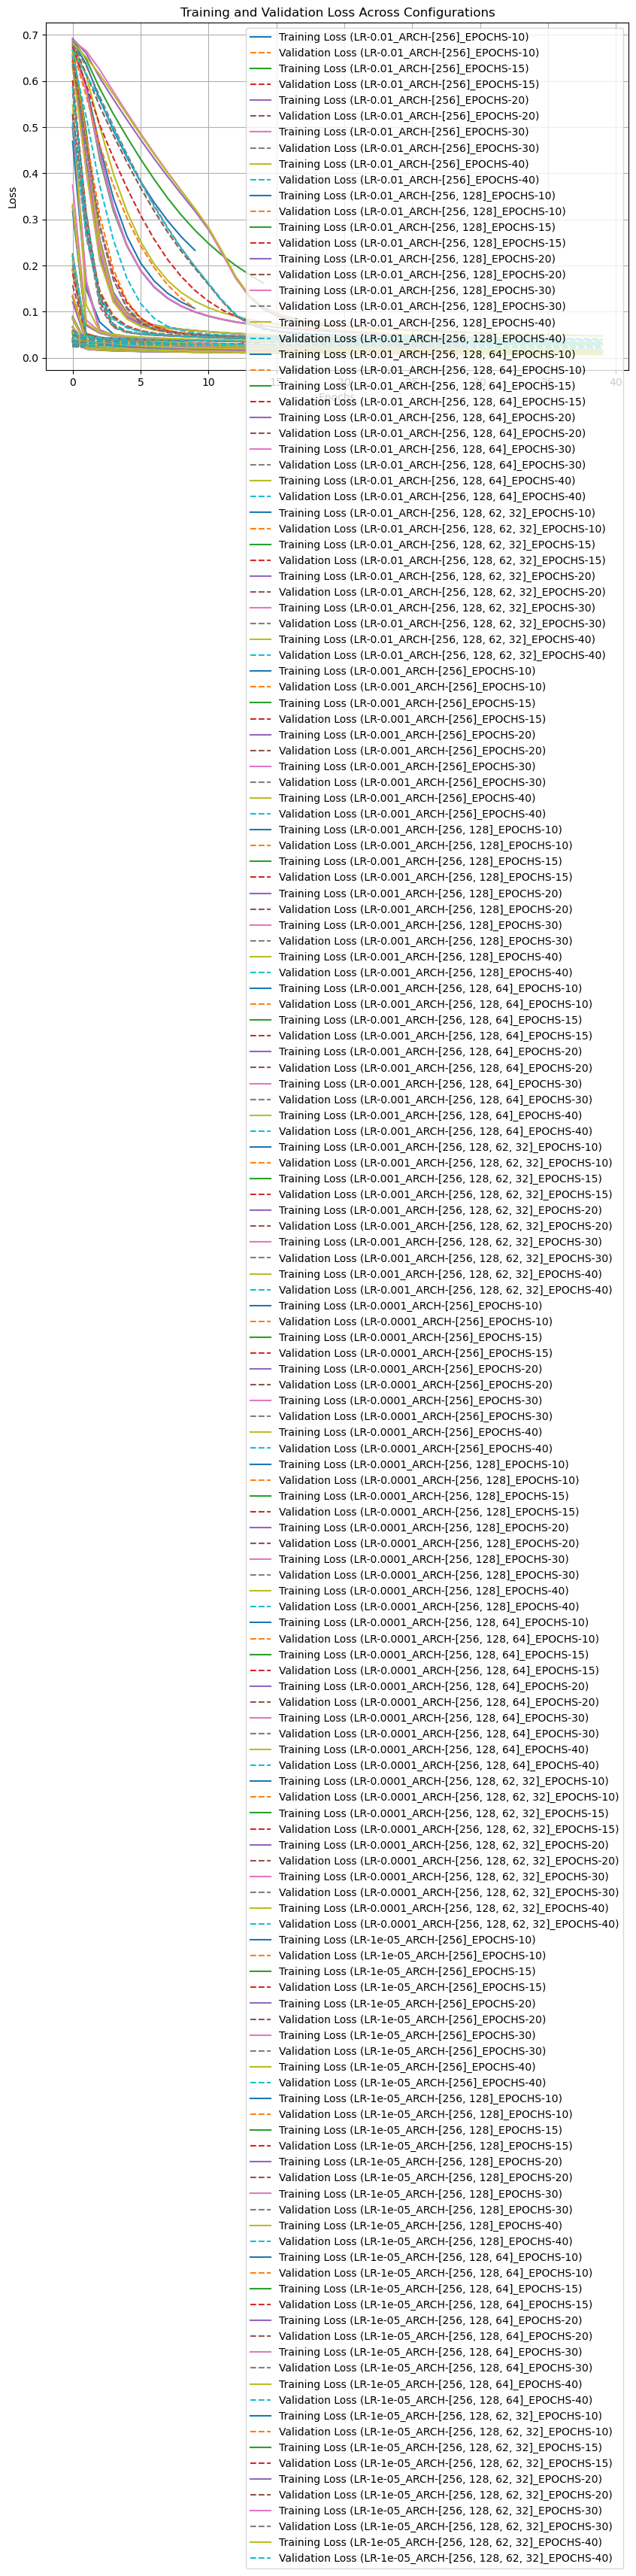


S-min @ F-max and F-max Metrics:
LR-0.01_ARCH-[256]_EPOCHS-10 -> F-max: 0.8599, S-min @ F-max: 1.3001
LR-0.01_ARCH-[256]_EPOCHS-15 -> F-max: 0.8623, S-min @ F-max: 1.2917
LR-0.01_ARCH-[256]_EPOCHS-20 -> F-max: 0.8632, S-min @ F-max: 1.3020
LR-0.01_ARCH-[256]_EPOCHS-30 -> F-max: 0.8593, S-min @ F-max: 1.3461
LR-0.01_ARCH-[256]_EPOCHS-40 -> F-max: 0.8640, S-min @ F-max: 1.2813
LR-0.01_ARCH-[256, 128]_EPOCHS-10 -> F-max: 0.8600, S-min @ F-max: 1.3142
LR-0.01_ARCH-[256, 128]_EPOCHS-15 -> F-max: 0.8620, S-min @ F-max: 1.2816
LR-0.01_ARCH-[256, 128]_EPOCHS-20 -> F-max: 0.8666, S-min @ F-max: 1.1973
LR-0.01_ARCH-[256, 128]_EPOCHS-30 -> F-max: 0.8609, S-min @ F-max: 1.2877
LR-0.01_ARCH-[256, 128]_EPOCHS-40 -> F-max: 0.8678, S-min @ F-max: 1.1858
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-10 -> F-max: 0.8545, S-min @ F-max: 1.4079
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-15 -> F-max: 0.8536, S-min @ F-max: 1.3759
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-20 -> F-max: 0.8590, S-min @ F-max: 1.3361
LR-0.01_ARCH-[256

In [ ]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}  
threshold_range = np.arange(0.1, 1.0, 0.1)  # Example range: [0.01, 0.99]

for lr in learning_rates:
    for arch in architectures:
        for num_epochs in epoch_counts:
            print(f"\nTraining with LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

            model = FFNN(
                input_dim=data_train_embeddings.shape[1], 
                hidden_dims=arch, 
                output_dim=data_train_labels.shape[1]
            )
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCEWithLogitsLoss()
            train_losses, val_losses = train_model(
                model, data_train_loader, data_val_loader, 
                criterion, optimizer, num_epochs, device
            )
            config_key = f"LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}"
            training_losses[config_key] = train_losses
            validation_losses[config_key] = val_losses
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for x_batch, y_batch in data_val_loader:
                    x_batch = x_batch.to(device)
                    outputs = model(x_batch)
                    preds = torch.sigmoid(outputs).cpu().numpy()  
                    all_preds.append(preds)
                    all_targets.append(y_batch.cpu().numpy())

            y_pred_probs = np.vstack(all_preds)
            y_true = np.vstack(all_targets)

            smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                ic_dict, y_true, y_pred_probs, threshold_range=threshold_range, mlb=data_mlb
            )
            smin_fmax_metrics[config_key] = {
                "F-max": fmax,
                "S-min @ F-max": s_at_fmax,
                "Best Threshold (F-max)": best_threshold_f,
                "Best Threshold (S-min)": best_threshold_s
            }
            results_file = f"metrics_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
            results_df.to_csv(results_file, index=False)
            print(f"Saved metrics to: {results_file}")

            print(f"Completed training and evaluation for config: LR={lr}, ARCH={arch}, EPOCHS={num_epochs}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], label=f'Validation Loss ({key})', linestyle='--')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [ ]:
metrics_df = pd.DataFrame.from_dict(smin_fmax_metrics, orient='index').reset_index()
metrics_df.rename(columns={"index": "Configuration"}, inplace=True)


metrics_df

,Configuration,F-max,S-min @ F-max,Best Threshold (F-max),Best Threshold (S-min)
0,LR-0.01_ARCH-[256]_EPOCHS-10,0.859916,1.300105,0.4,0.3
1,LR-0.01_ARCH-[256]_EPOCHS-15,0.862337,1.291711,0.4,0.3
2,LR-0.01_ARCH-[256]_EPOCHS-20,0.863188,1.301987,0.4,0.3
3,LR-0.01_ARCH-[256]_EPOCHS-30,0.859297,1.346118,0.4,0.3
4,LR-0.01_ARCH-[256]_EPOCHS-40,0.863982,1.281275,0.4,0.3
...,...,...,...,...,...
75,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-10",0.666199,3.193996,0.9,0.9
76,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-15",0.671790,3.192968,0.6,0.6
77,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-20",0.695871,2.722657,0.3,0.3
78,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-30",0.715335,2.731229,0.3,0.2


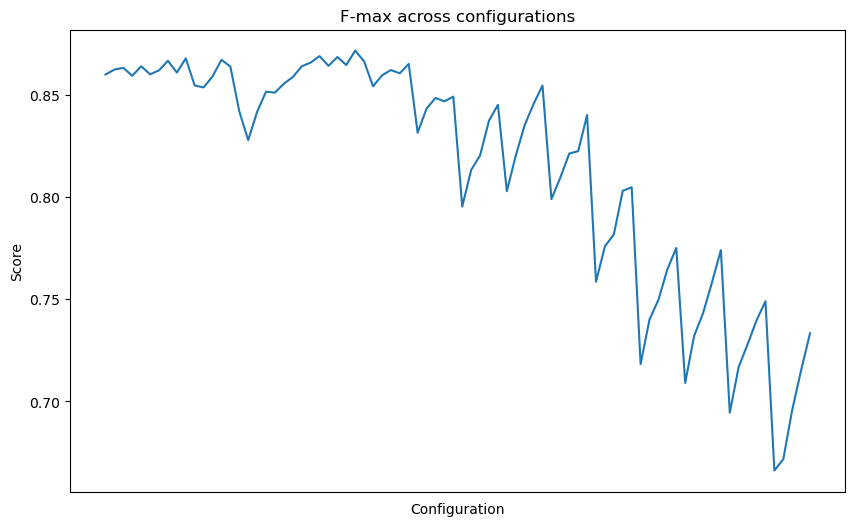

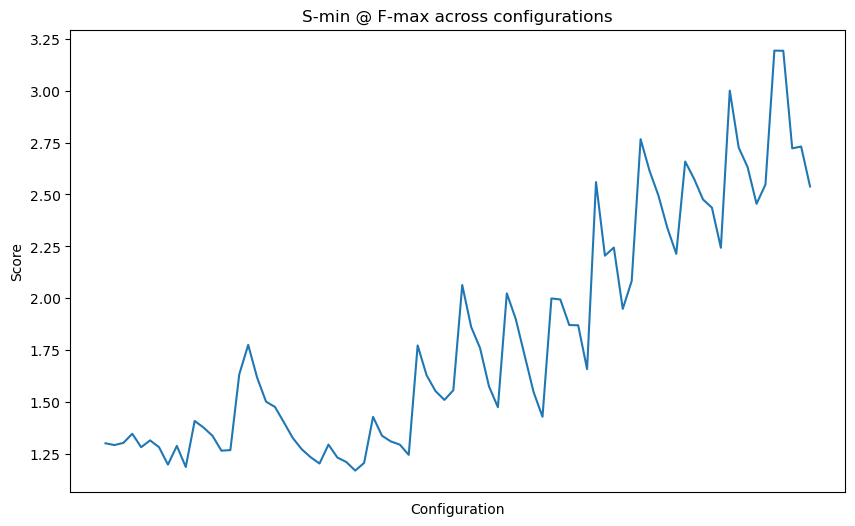

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["F-max"], label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 

plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["S-min @ F-max"], label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 


In [ ]:
def find_best_config(metrics_df):
    sorted_df = metrics_df.sort_values(by=["F-max", "S-min @ F-max"], ascending=[False, True])
    return sorted_df.iloc[0]

best_config = find_best_config(metrics_df)
best_config

Configuration             LR-0.001_ARCH-[256, 128]_EPOCHS-30
F-max                                               0.871625
S-min @ F-max                                       1.168556
Best Threshold (F-max)                                   0.3
Best Threshold (S-min)                                   0.4
Name: 28, dtype: object

In [ ]:
def find_best_config_with_overfitting(
    metrics_df, training_losses, validation_losses
):
    overfitting_scores = {}
    for config_key in training_losses:
        final_train_loss = training_losses[config_key][-1]  # Last epoch's training loss
        final_val_loss = validation_losses[config_key][-1]  # Last epoch's validation loss
        overfitting_scores[config_key] = final_val_loss - final_train_loss

    metrics_df["Overfitting_Score"] = metrics_df["Configuration"].map(overfitting_scores)
    sorted_df = metrics_df.sort_values(
        by=["F-max", "S-min @ F-max", "Overfitting_Score"], 
        ascending=[False, True, True]
    )
    return sorted_df.iloc[0]

best_config = find_best_config_with_overfitting(metrics_df, training_losses, validation_losses)
print(best_config)


Configuration             LR-0.001_ARCH-[256, 128]_EPOCHS-30
F-max                                               0.871625
S-min @ F-max                                       1.168556
Best Threshold (F-max)                                   0.3
Best Threshold (S-min)                                   0.4
Overfitting_Score                                   0.017879
Name: 28, dtype: object


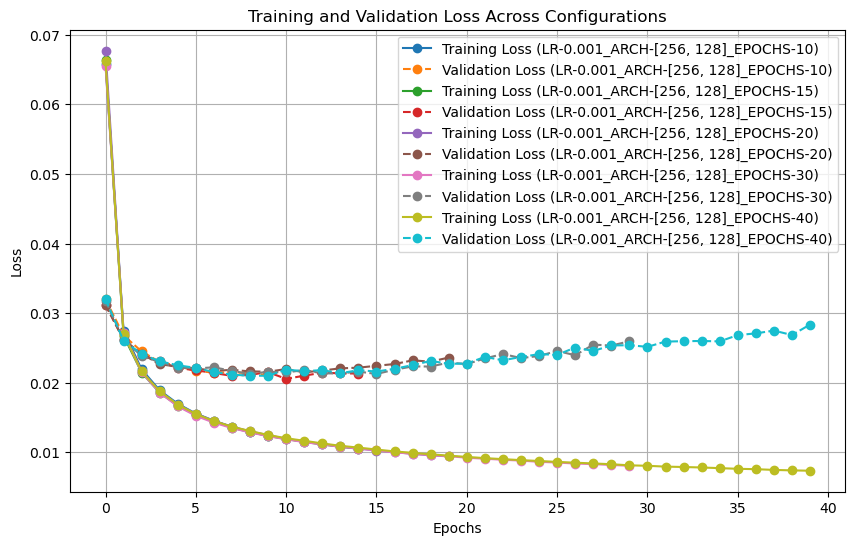

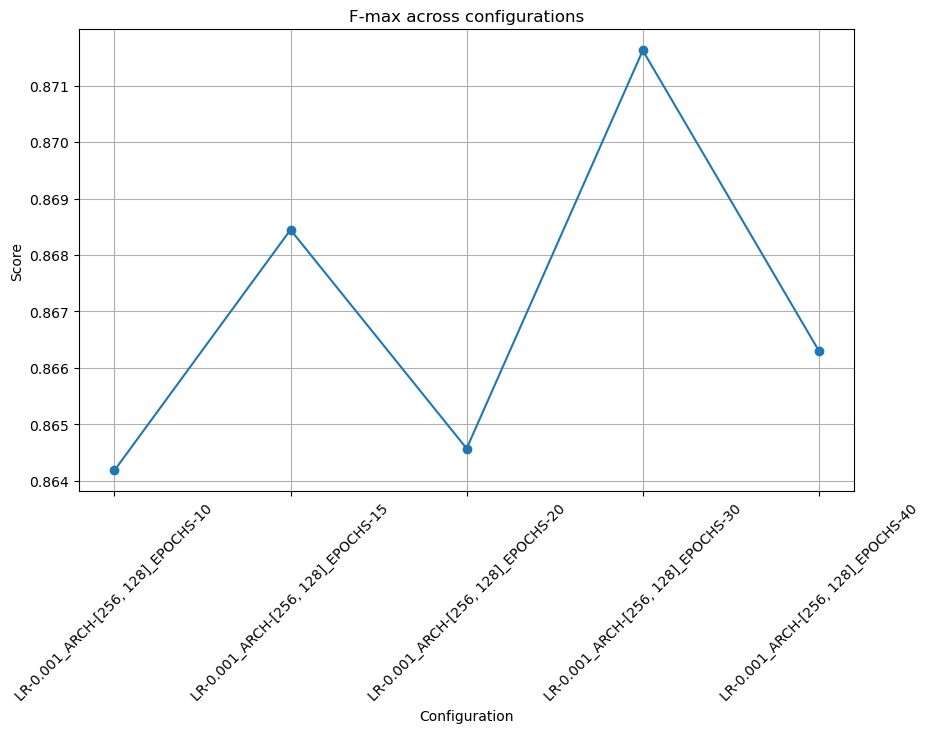

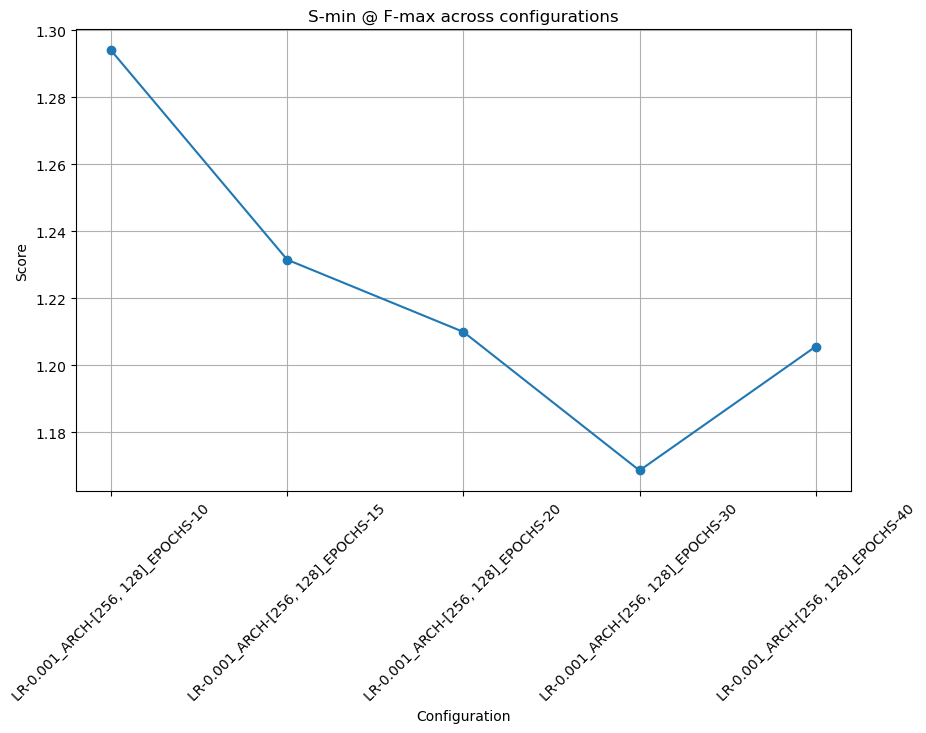

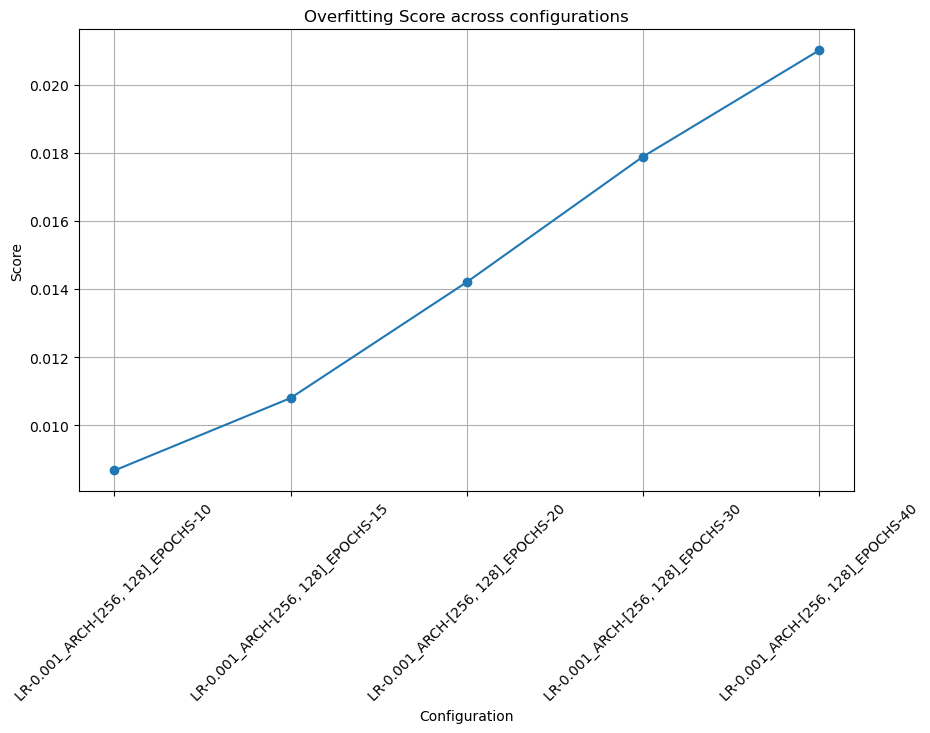

In [ ]:
configs = [key for key in training_losses.keys() if "LR-0.001_ARCH-[256, 128]" in key]
plt.figure(figsize=(10, 6))
for key in configs:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
metrics_df_subset = metrics_df[metrics_df["Configuration"].isin(configs)]

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["F-max"], marker='o', label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["S-min @ F-max"], marker='o', label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["Overfitting_Score"], marker='o', label="Overfitting Score")
plt.title("Overfitting Score across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [ ]:
metrics_df.to_csv(r'CC_architecture_tune/CCO_metrics_df.csv', index=False)

LR-0.001_ARCH-[256, 128]_EPOCHS-15 is chosen. 

In [21]:
CHOSEN_CONFIG = 'LR-0.001_ARCH-[256, 128]_EPOCHS-15'
CHOSEN_CONFIG_LR = 0.001
CHOSEN_CONFIG_ARCH = [256, 128]
CHOSEN_CONFIG_EPOCHS = 15


# Is there an advantage of using another Loss scheme for this architecture? 

In [ ]:
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

def get_level(go_term, ontology):

    try :
        return obodag[go_term].level
    except KeyError:
        return 0

data_train_GO_flat = [item for sublist in data_train_GO_list for item in sublist]
data_train_GO_list_unique = list(set(data_train_GO_flat))
data_train_GO_levels = [get_level(go_term, 'function') for go_term in data_train_GO_list_unique]

def compute_depth_weight(term_depths):
    class_weights = np.array([1 + depth/2 for depth in term_depths]) 
    return class_weights

data_train_GO_weights_depth = compute_depth_weight(data_train_GO_levels)

data_train_GO_weights_depth.shape

go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms


(255,)

In [ ]:
def compute_inverse_frequency_weight(labels):
    class_counts = np.sum(labels, axis=0)
    total_samples = labels.shape[0]
    num_classes = labels.shape[1]
    class_weights = total_samples / (num_classes * class_counts)
    return class_weights

if len(data_train_labels.shape) > 1 and data_train_labels.shape[1] > 1:  
    class_weights = compute_inverse_frequency_weight(data_train_labels)
    data_train_GO_weights_inv_freq_ = torch.tensor(class_weights, dtype=torch.float).to(device)

data_train_GO_weights_inv_freq_.shape

torch.Size([255])

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


class JaccardLoss(nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum(dim=1)
        total = (inputs + targets).sum(dim=1)
        union = total - intersection
        Jaccard = (intersection + self.smooth) / (union + self.smooth)
        return 1 - Jaccard.mean()


class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, inputs, targets):
        targets = 2 * targets - 1  # Convert {0,1} to {-1,1}
        hinge_loss = torch.mean(torch.clamp(self.margin - targets * inputs, min=0))
        return hinge_loss


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.clamp(self.clip, 1.0 - self.clip)

        loss_pos = -targets * torch.log(inputs + self.eps) * (1 - inputs) ** self.gamma_pos
        loss_neg = -(1 - targets) * torch.log(1 - inputs + self.eps) * inputs ** self.gamma_neg
        loss = loss_pos + loss_neg

        return loss.mean()





Training with BCEWithLogitsLoss_balanced, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.64s/it]

Epoch [1/15] | Train Loss: 0.0666 | Val Loss: 0.0316


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.62s/it]

Epoch [2/15] | Train Loss: 0.0267 | Val Loss: 0.0262


Epoch progress:  20%|██        | 3/15 [00:05<00:21,  1.80s/it]

Epoch [3/15] | Train Loss: 0.0212 | Val Loss: 0.0243


Epoch progress:  27%|██▋       | 4/15 [00:07<00:22,  2.07s/it]

Epoch [4/15] | Train Loss: 0.0183 | Val Loss: 0.0233


Epoch progress:  33%|███▎      | 5/15 [00:10<00:22,  2.25s/it]

Epoch [5/15] | Train Loss: 0.0165 | Val Loss: 0.0224


Epoch progress:  40%|████      | 6/15 [00:12<00:21,  2.35s/it]

Epoch [6/15] | Train Loss: 0.0152 | Val Loss: 0.0221


Epoch progress:  47%|████▋     | 7/15 [00:15<00:19,  2.44s/it]

Epoch [7/15] | Train Loss: 0.0142 | Val Loss: 0.0215


Epoch progress:  53%|█████▎    | 8/15 [00:17<00:15,  2.28s/it]

Epoch [8/15] | Train Loss: 0.0135 | Val Loss: 0.0212


Epoch progress:  60%|██████    | 9/15 [00:18<00:12,  2.04s/it]

Epoch [9/15] | Train Loss: 0.0128 | Val Loss: 0.0212


Epoch progress:  67%|██████▋   | 10/15 [00:20<00:09,  1.88s/it]

Epoch [10/15] | Train Loss: 0.0124 | Val Loss: 0.0216


Epoch progress:  73%|███████▎  | 11/15 [00:21<00:07,  1.77s/it]

Epoch [11/15] | Train Loss: 0.0118 | Val Loss: 0.0213


Epoch progress:  80%|████████  | 12/15 [00:23<00:05,  1.71s/it]

Epoch [12/15] | Train Loss: 0.0114 | Val Loss: 0.0215


Epoch progress:  87%|████████▋ | 13/15 [00:25<00:03,  1.70s/it]

Epoch [13/15] | Train Loss: 0.0111 | Val Loss: 0.0212


Epoch progress:  93%|█████████▎| 14/15 [00:26<00:01,  1.65s/it]

Epoch [14/15] | Train Loss: 0.0108 | Val Loss: 0.0216


Epoch progress: 100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Epoch [15/15] | Train Loss: 0.0105 | Val Loss: 0.0214
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:36<00:00,  2.73it/s]


F-max @ Best Threshold (0.42000000000000004): 0.8658122530190842
S-min @ Best Threshold (0.35000000000000003): 1.234952874099349
S-min @ F-max Threshold (0.42000000000000004): 1.2390113370010896
Saved metrics to: CCO_metrics_BCEWithLogitsLoss_balanced_lr0.001_arch[256, 128]_epochs15.csv
Completed BCEWithLogitsLoss_balanced | Validation Loss: 0.0214, Fmax: 0.8658, Smin: 1.2350

Training with BCEWithLogitsLoss_depth, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.68s/it]

Epoch [1/15] | Train Loss: 0.1839 | Val Loss: 0.0841


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.62s/it]

Epoch [2/15] | Train Loss: 0.0719 | Val Loss: 0.0703


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.59s/it]

Epoch [3/15] | Train Loss: 0.0568 | Val Loss: 0.0646


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.60s/it]

Epoch [4/15] | Train Loss: 0.0485 | Val Loss: 0.0605


Epoch progress:  33%|███▎      | 5/15 [00:07<00:15,  1.59s/it]

Epoch [5/15] | Train Loss: 0.0433 | Val Loss: 0.0584


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.56s/it]

Epoch [6/15] | Train Loss: 0.0397 | Val Loss: 0.0573


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.62s/it]

Epoch [7/15] | Train Loss: 0.0370 | Val Loss: 0.0574


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.60s/it]

Epoch [8/15] | Train Loss: 0.0349 | Val Loss: 0.0564


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.60s/it]

Epoch [9/15] | Train Loss: 0.0332 | Val Loss: 0.0563


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.62s/it]

Epoch [10/15] | Train Loss: 0.0318 | Val Loss: 0.0558


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.60s/it]

Epoch [11/15] | Train Loss: 0.0306 | Val Loss: 0.0556


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.63s/it]

Epoch [12/15] | Train Loss: 0.0295 | Val Loss: 0.0563


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]

Epoch [13/15] | Train Loss: 0.0285 | Val Loss: 0.0566


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.63s/it]

Epoch [14/15] | Train Loss: 0.0277 | Val Loss: 0.0569


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


Epoch [15/15] | Train Loss: 0.0270 | Val Loss: 0.0579
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:36<00:00,  2.71it/s]


F-max @ Best Threshold (0.44): 0.8657736297769879
S-min @ Best Threshold (0.36000000000000004): 1.2260664777920829
S-min @ F-max Threshold (0.44): 1.2483078600882411
Saved metrics to: CCO_metrics_BCEWithLogitsLoss_depth_lr0.001_arch[256, 128]_epochs15.csv
Completed BCEWithLogitsLoss_depth | Validation Loss: 0.0579, Fmax: 0.8658, Smin: 1.2261

Training with BCEWithLogitsLoss_inv_freq, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.68s/it]

Epoch [1/15] | Train Loss: 0.1431 | Val Loss: 0.0279


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.62s/it]

Epoch [2/15] | Train Loss: 0.0258 | Val Loss: 0.0231


Epoch progress:  20%|██        | 3/15 [00:05<00:24,  2.01s/it]

Epoch [3/15] | Train Loss: 0.0195 | Val Loss: 0.0198


Epoch progress:  27%|██▋       | 4/15 [00:08<00:24,  2.23s/it]

Epoch [4/15] | Train Loss: 0.0154 | Val Loss: 0.0174


Epoch progress:  33%|███▎      | 5/15 [00:10<00:23,  2.35s/it]

Epoch [5/15] | Train Loss: 0.0128 | Val Loss: 0.0155


Epoch progress:  40%|████      | 6/15 [00:13<00:22,  2.45s/it]

Epoch [6/15] | Train Loss: 0.0111 | Val Loss: 0.0139


Epoch progress:  47%|████▋     | 7/15 [00:16<00:20,  2.54s/it]

Epoch [7/15] | Train Loss: 0.0099 | Val Loss: 0.0129


Epoch progress:  53%|█████▎    | 8/15 [00:18<00:17,  2.54s/it]

Epoch [8/15] | Train Loss: 0.0090 | Val Loss: 0.0127


Epoch progress:  60%|██████    | 9/15 [00:21<00:15,  2.54s/it]

Epoch [9/15] | Train Loss: 0.0083 | Val Loss: 0.0121


Epoch progress:  67%|██████▋   | 10/15 [00:23<00:12,  2.53s/it]

Epoch [10/15] | Train Loss: 0.0077 | Val Loss: 0.0123


Epoch progress:  73%|███████▎  | 11/15 [00:26<00:10,  2.53s/it]

Epoch [11/15] | Train Loss: 0.0072 | Val Loss: 0.0119


Epoch progress:  80%|████████  | 12/15 [00:28<00:07,  2.53s/it]

Epoch [12/15] | Train Loss: 0.0068 | Val Loss: 0.0117


Epoch progress:  87%|████████▋ | 13/15 [00:31<00:05,  2.60s/it]

Epoch [13/15] | Train Loss: 0.0064 | Val Loss: 0.0114


Epoch progress:  93%|█████████▎| 14/15 [00:34<00:02,  2.57s/it]

Epoch [14/15] | Train Loss: 0.0061 | Val Loss: 0.0114


Epoch progress: 100%|██████████| 15/15 [00:36<00:00,  2.44s/it]

Epoch [15/15] | Train Loss: 0.0059 | Val Loss: 0.0112
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [00:36<00:00,  2.69it/s]


F-max @ Best Threshold (0.36000000000000004): 0.779126640829194
S-min @ Best Threshold (0.36000000000000004): 1.7609479642496428
S-min @ F-max Threshold (0.36000000000000004): 1.7609479642496428
Saved metrics to: CCO_metrics_BCEWithLogitsLoss_inv_freq_lr0.001_arch[256, 128]_epochs15.csv
Completed BCEWithLogitsLoss_inv_freq | Validation Loss: 0.0112, Fmax: 0.7791, Smin: 1.7609

Training with FocalLoss, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:25,  1.80s/it]

Epoch [1/15] | Train Loss: 0.0040 | Val Loss: 0.0020


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.69s/it]

Epoch [2/15] | Train Loss: 0.0017 | Val Loss: 0.0017


Epoch progress:  20%|██        | 3/15 [00:05<00:19,  1.66s/it]

Epoch [3/15] | Train Loss: 0.0013 | Val Loss: 0.0015


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch [4/15] | Train Loss: 0.0011 | Val Loss: 0.0015


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.63s/it]

Epoch [5/15] | Train Loss: 0.0010 | Val Loss: 0.0015


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.64s/it]

Epoch [6/15] | Train Loss: 0.0009 | Val Loss: 0.0015


Epoch progress:  47%|████▋     | 7/15 [00:12<00:16,  2.02s/it]

Epoch [7/15] | Train Loss: 0.0009 | Val Loss: 0.0015


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:15,  2.25s/it]

Epoch [8/15] | Train Loss: 0.0008 | Val Loss: 0.0015


Epoch progress:  60%|██████    | 9/15 [00:17<00:12,  2.14s/it]

Epoch [9/15] | Train Loss: 0.0008 | Val Loss: 0.0015


Epoch progress:  67%|██████▋   | 10/15 [00:18<00:09,  1.96s/it]

Epoch [10/15] | Train Loss: 0.0008 | Val Loss: 0.0015


Epoch progress:  73%|███████▎  | 11/15 [00:20<00:07,  1.85s/it]

Epoch [11/15] | Train Loss: 0.0007 | Val Loss: 0.0016


Epoch progress:  80%|████████  | 12/15 [00:22<00:05,  1.83s/it]

Epoch [12/15] | Train Loss: 0.0007 | Val Loss: 0.0016


Epoch progress:  87%|████████▋ | 13/15 [00:23<00:03,  1.78s/it]

Epoch [13/15] | Train Loss: 0.0007 | Val Loss: 0.0016


Epoch progress:  93%|█████████▎| 14/15 [00:25<00:01,  1.75s/it]

Epoch [14/15] | Train Loss: 0.0007 | Val Loss: 0.0016


Epoch progress: 100%|██████████| 15/15 [00:27<00:00,  1.81s/it]


Epoch [15/15] | Train Loss: 0.0006 | Val Loss: 0.0016
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:37<00:00,  2.61it/s]


F-max @ Best Threshold (0.46): 0.8711901385949171
S-min @ Best Threshold (0.44): 1.1915927079693347
S-min @ F-max Threshold (0.46): 1.2011221710759805
Saved metrics to: CCO_metrics_FocalLoss_lr0.001_arch[256, 128]_epochs15.csv
Completed FocalLoss | Validation Loss: 0.0016, Fmax: 0.8712, Smin: 1.1916

Training with JaccardLoss, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]

Epoch [1/15] | Train Loss: 0.5507 | Val Loss: 0.5100


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Epoch [2/15] | Train Loss: 0.5105 | Val Loss: 0.5100


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.63s/it]

Epoch [3/15] | Train Loss: 0.5060 | Val Loss: 0.4924


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.61s/it]

Epoch [4/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  33%|███▎      | 5/15 [00:08<00:15,  1.59s/it]

Epoch [5/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.58s/it]

Epoch [6/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.64s/it]

Epoch [7/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.60s/it]

Epoch [8/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.59s/it]

Epoch [9/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:07,  1.57s/it]

Epoch [10/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.55s/it]

Epoch [11/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.56s/it]

Epoch [12/15] | Train Loss: 0.4904 | Val Loss: 0.4924


Epoch progress:  87%|████████▋ | 13/15 [00:20<00:03,  1.59s/it]

Epoch [13/15] | Train Loss: 0.4904 | Val Loss: 0.4924


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.59s/it]

Epoch [14/15] | Train Loss: 0.4903 | Val Loss: 0.4924


Epoch progress: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]

Epoch [15/15] | Train Loss: 0.4903 | Val Loss: 0.4924
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [00:36<00:00,  2.68it/s]


F-max @ Best Threshold (0.01): 0.612862762715876
S-min @ Best Threshold (0.01): 2.9055784506017215
S-min @ F-max Threshold (0.01): 2.9055784506017215
Saved metrics to: CCO_metrics_JaccardLoss_lr0.001_arch[256, 128]_epochs15.csv
Completed JaccardLoss | Validation Loss: 0.4924, Fmax: 0.6129, Smin: 2.9056

Training with HingeLoss, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.65s/it]

Epoch [1/15] | Train Loss: 0.0606 | Val Loss: 0.0254


Epoch progress:  13%|█▎        | 2/15 [00:03<00:20,  1.55s/it]

Epoch [2/15] | Train Loss: 0.0225 | Val Loss: 0.0225


Epoch progress:  20%|██        | 3/15 [00:05<00:22,  1.84s/it]

Epoch [3/15] | Train Loss: 0.0191 | Val Loss: 0.0207


Epoch progress:  27%|██▋       | 4/15 [00:07<00:22,  2.08s/it]

Epoch [4/15] | Train Loss: 0.0171 | Val Loss: 0.0200


Epoch progress:  33%|███▎      | 5/15 [00:10<00:22,  2.23s/it]

Epoch [5/15] | Train Loss: 0.0154 | Val Loss: 0.0194


Epoch progress:  40%|████      | 6/15 [00:12<00:20,  2.32s/it]

Epoch [6/15] | Train Loss: 0.0142 | Val Loss: 0.0190


Epoch progress:  47%|████▋     | 7/15 [00:15<00:18,  2.37s/it]

Epoch [7/15] | Train Loss: 0.0133 | Val Loss: 0.0187


Epoch progress:  53%|█████▎    | 8/15 [00:16<00:14,  2.10s/it]

Epoch [8/15] | Train Loss: 0.0125 | Val Loss: 0.0184


Epoch progress:  60%|██████    | 9/15 [00:18<00:11,  1.93s/it]

Epoch [9/15] | Train Loss: 0.0119 | Val Loss: 0.0184


Epoch progress:  67%|██████▋   | 10/15 [00:19<00:09,  1.80s/it]

Epoch [10/15] | Train Loss: 0.0113 | Val Loss: 0.0182


Epoch progress:  73%|███████▎  | 11/15 [00:21<00:06,  1.72s/it]

Epoch [11/15] | Train Loss: 0.0109 | Val Loss: 0.0184


Epoch progress:  80%|████████  | 12/15 [00:22<00:04,  1.66s/it]

Epoch [12/15] | Train Loss: 0.0104 | Val Loss: 0.0184


Epoch progress:  87%|████████▋ | 13/15 [00:24<00:03,  1.65s/it]

Epoch [13/15] | Train Loss: 0.0101 | Val Loss: 0.0179


Epoch progress:  93%|█████████▎| 14/15 [00:26<00:01,  1.61s/it]

Epoch [14/15] | Train Loss: 0.0097 | Val Loss: 0.0182


Epoch progress: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


Epoch [15/15] | Train Loss: 0.0094 | Val Loss: 0.0184
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:42<00:00,  2.32it/s]


F-max @ Best Threshold (0.38): 0.8653094048045605
S-min @ Best Threshold (0.33): 1.3005745206745458
S-min @ F-max Threshold (0.38): 1.3268496223420383
Saved metrics to: CCO_metrics_HingeLoss_lr0.001_arch[256, 128]_epochs15.csv
Completed HingeLoss | Validation Loss: 0.0184, Fmax: 0.8653, Smin: 1.3006

Training with AsymmetricLoss, LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:26,  1.88s/it]

Epoch [1/15] | Train Loss: 0.0087 | Val Loss: 0.0059


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Epoch [2/15] | Train Loss: 0.0047 | Val Loss: 0.0052


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.63s/it]

Epoch [3/15] | Train Loss: 0.0039 | Val Loss: 0.0049


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.59s/it]

Epoch [4/15] | Train Loss: 0.0034 | Val Loss: 0.0048


Epoch progress:  33%|███▎      | 5/15 [00:08<00:15,  1.59s/it]

Epoch [5/15] | Train Loss: 0.0031 | Val Loss: 0.0048


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.60s/it]

Epoch [6/15] | Train Loss: 0.0029 | Val Loss: 0.0048


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch [7/15] | Train Loss: 0.0028 | Val Loss: 0.0051


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch [8/15] | Train Loss: 0.0027 | Val Loss: 0.0049


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.64s/it]

Epoch [9/15] | Train Loss: 0.0026 | Val Loss: 0.0050


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.63s/it]

Epoch [10/15] | Train Loss: 0.0025 | Val Loss: 0.0049


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.63s/it]

Epoch [11/15] | Train Loss: 0.0024 | Val Loss: 0.0051


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.62s/it]

Epoch [12/15] | Train Loss: 0.0023 | Val Loss: 0.0051


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch [13/15] | Train Loss: 0.0023 | Val Loss: 0.0052


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch [14/15] | Train Loss: 0.0022 | Val Loss: 0.0052


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


Epoch [15/15] | Train Loss: 0.0022 | Val Loss: 0.0053
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [00:40<00:00,  2.43it/s]

F-max @ Best Threshold (0.5700000000000001): 0.867121357485228
S-min @ Best Threshold (0.56): 1.2141685824247392
S-min @ F-max Threshold (0.5700000000000001): 1.2178840653841787
Saved metrics to: CCO_metrics_AsymmetricLoss_lr0.001_arch[256, 128]_epochs15.csv
Completed AsymmetricLoss | Validation Loss: 0.0053, Fmax: 0.8671, Smin: 1.2142


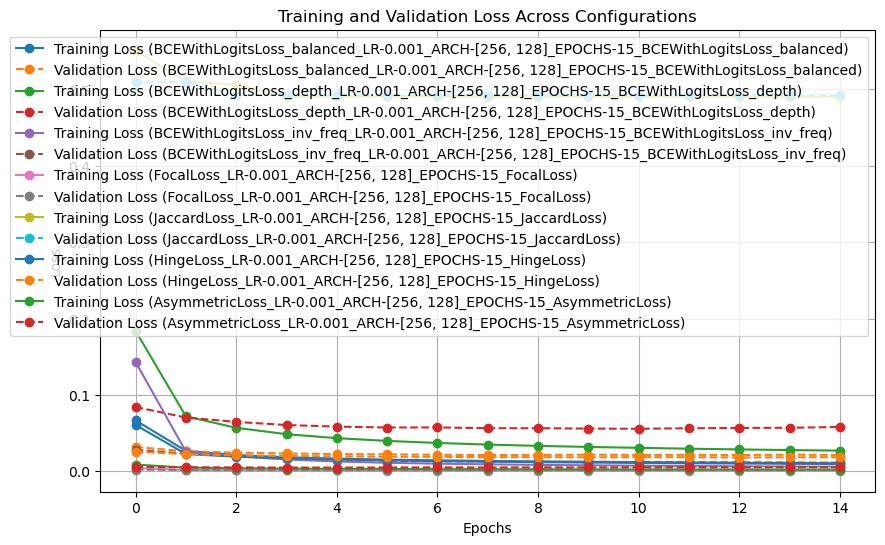


S-min @ F-max and F-max Metrics:
BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256, 128]_EPOCHS-15_BCEWithLogitsLoss_balanced -> F-max: 0.8658, S-min @ F-max: 1.2390
BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256, 128]_EPOCHS-15_BCEWithLogitsLoss_depth -> F-max: 0.8658, S-min @ F-max: 1.2483
BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256, 128]_EPOCHS-15_BCEWithLogitsLoss_inv_freq -> F-max: 0.7791, S-min @ F-max: 1.7609
FocalLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-15_FocalLoss -> F-max: 0.8712, S-min @ F-max: 1.2011
JaccardLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-15_JaccardLoss -> F-max: 0.6129, S-min @ F-max: 2.9056
HingeLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-15_HingeLoss -> F-max: 0.8653, S-min @ F-max: 1.3268
AsymmetricLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-15_AsymmetricLoss -> F-max: 0.8671, S-min @ F-max: 1.2179
Process finished. Loss plot and metric evaluations completed.


In [ ]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}

threshold_range = np.arange(0.01, 1.0, 0.01)

architectures = [CHOSEN_CONFIG_ARCH]  
learning_rates = [CHOSEN_CONFIG_LR]
epoch_counts = [CHOSEN_CONFIG_EPOCHS]

loss_functions = {
    'BCEWithLogitsLoss_balanced': nn.BCEWithLogitsLoss(),
    'BCEWithLogitsLoss_depth': nn.BCEWithLogitsLoss(
        weight=torch.tensor(data_train_GO_weights_depth, dtype=torch.float).to(device)
    ),
    'BCEWithLogitsLoss_inv_freq': nn.BCEWithLogitsLoss(weight=data_train_GO_weights_inv_freq_),
    'FocalLoss': FocalLoss(),
    'JaccardLoss': JaccardLoss(),
    'HingeLoss': HingeLoss(),
    'AsymmetricLoss': AsymmetricLoss()
}

for loss_name, loss_fn in loss_functions.items():
    for lr in learning_rates:
        for arch in architectures:
            for num_epochs in epoch_counts:
                print(f"\nTraining with {loss_name}, LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

                model = FFNN(
                    input_dim=data_train_embeddings.shape[1], 
                    hidden_dims=arch, 
                    output_dim=data_train_labels.shape[1]
                )

                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_losses, val_losses = train_model(
                    model, data_train_loader, data_val_loader, 
                    loss_fn, optimizer, num_epochs, device
                )

                config_key = f"{loss_name}_LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}_{loss_name}"
                training_losses[config_key] = train_losses
                validation_losses[config_key] = val_losses

                all_preds = []
                all_targets = []
                with torch.no_grad():
                    for x_batch, y_batch in data_val_loader:
                        x_batch = x_batch.to(device)
                        outputs = model(x_batch)
                        preds = torch.sigmoid(outputs).cpu().numpy()  
                        all_preds.append(preds)
                        all_targets.append(y_batch.cpu().numpy())

                y_pred_probs = np.vstack(all_preds)
                y_true = np.vstack(all_targets)

                smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                    ic_dict=ic_dict,
                    y_true=y_true,
                    y_pred_probs=y_pred_probs,
                    threshold_range=threshold_range,
                    n_jobs=1,
                    mlb=data_mlb
                )

                smin_fmax_metrics[config_key] = {
                    "F-max": fmax,
                    "S-min @ F-max": s_at_fmax,
                    "Best Threshold (F-max)": best_threshold_f,
                    "Best Threshold (S-min)": best_threshold_s
                }

                results_file = f"metrics_{loss_name}_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
                results_df.to_csv(results_file, index=False)
                print(f"Saved metrics to: {results_file}")

                print(f"Completed {loss_name} | Validation Loss: {val_losses[-1]:.4f}, "
                      f"Fmax: {fmax:.4f}, Smin: {smin:.4f}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Print F-max and S-min @ F-max metrics for all configurations
print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [26]:
smin_fmax_metrics

{'BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256, 128]_EPOCHS-15_BCEWithLogitsLoss_balanced': {'F-max': 0.8658122530190842,
  'S-min @ F-max': 1.2390113370010896,
  'Best Threshold (F-max)': 0.42000000000000004,
  'Best Threshold (S-min)': 0.35000000000000003},
 'BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256, 128]_EPOCHS-15_BCEWithLogitsLoss_depth': {'F-max': 0.8657736297769879,
  'S-min @ F-max': 1.2483078600882411,
  'Best Threshold (F-max)': 0.44,
  'Best Threshold (S-min)': 0.36000000000000004},
 'BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256, 128]_EPOCHS-15_BCEWithLogitsLoss_inv_freq': {'F-max': 0.779126640829194,
  'S-min @ F-max': 1.7609479642496428,
  'Best Threshold (F-max)': 0.36000000000000004,
  'Best Threshold (S-min)': 0.36000000000000004},
 'FocalLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-15_FocalLoss': {'F-max': 0.8711901385949171,
  'S-min @ F-max': 1.2011221710759805,
  'Best Threshold (F-max)': 0.46,
  'Best Threshold (S-min)': 0.44},
 'JaccardLoss_LR-0.001_ARCH-[256, 128]_EPO